In [1]:
from collections import Counter, defaultdict
import itertools
import string
import pickle


from graph_tool import Graph
from graph_tool.draw import graph_draw
import matplotlib.pyplot as plt
import networkx as nx
import nltk
import pandas as pd


In [2]:
df = pd.read_csv("positive_pairs.tsv", sep="\t")
df

word_a   word_b  rhyme
0             stall   skrall      1
1              ving     ting      1
2             orden   horden      1
3             taler   svaler      1
4         juleskikk    blikk      1
...             ...      ...    ...
7233         spratt     datt      1
7234          brøde     døde      1
7235  gjennomgløder    føder      1
7236            løs      røs      1
7237       sjenerer  manerer      1

[7238 rows x 3 columns]

In [3]:
pairs = set(zip(*(df.word_a, df.word_b)))
len(pairs)

7238

In [4]:
vocab = set(df.word_a)
vocab.update(set(df.word_b))
len(vocab)

6290

In [5]:
s = "\t".join(vocab)
with open("annotation_pairs_vocab.tsv", "w+") as f:
    f.write(s)

## Plot rhyme pair graph

In [6]:
edges = pairs.copy()
vertices = list(vocab)

G = Graph(directed=False)

vertices_ = G.add_vertex(len(vertices))

vertex_lookup = {v: v_ for v, v_ in zip(vertices, vertices_)}
vertex_lookup

for w1, w2 in edges:
    G.add_edge(vertex_lookup[w1], vertex_lookup[w2])

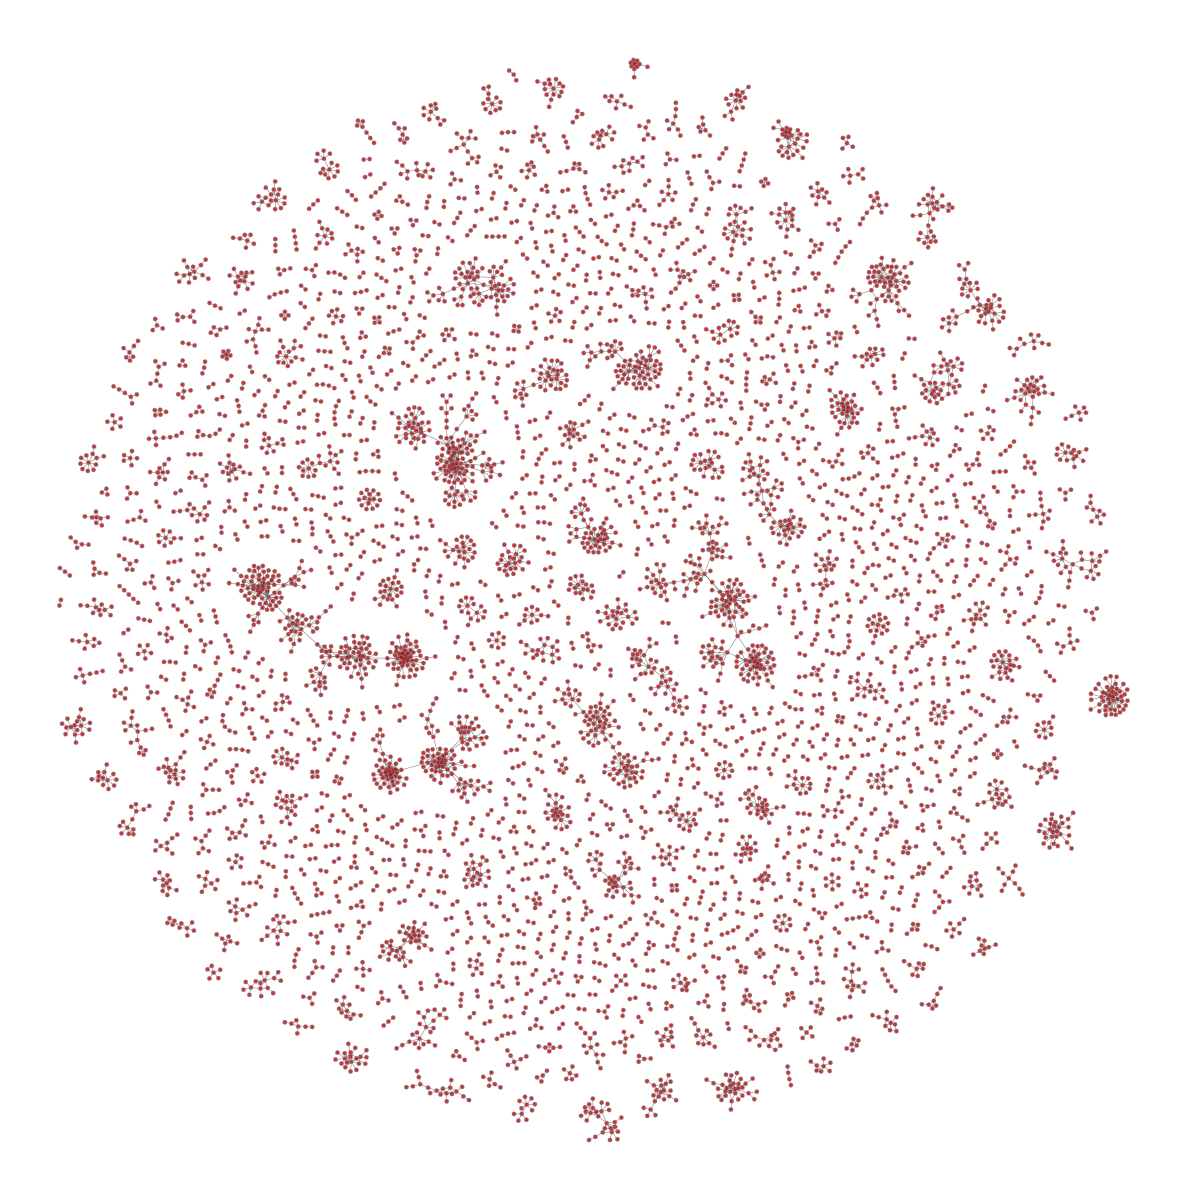

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fef79343280, at 0x7fef79343670>

In [7]:
graph_draw(G)

## Get buckets from graph
### Connect rhymes via overlapping rhyme pairs
If A and B rhyme, and B and C rhyme, A and C should also rhyme. 
Go through each rhyme pair and create rhyming buckets.

In [8]:
# G = nx.Graph()

# edges = pairs.copy()
# vertices = list(vocab)

# G.add_nodes_from(vertices)
# G.add_edges_from(edges)

# nx.write_edgelist(G, "rhyme_graph.edgelist")
# buckets = list(nx.connected_components(G))

# with open('rhyme_graph_buckets.pickle','wb') as f:
#     pickle.dump(buckets, f)

G = nx.read_edgelist("rhyme_graph.edgelist")
with open('rhyme_graph_buckets.pickle','rb') as f:
    buckets = pickle.load(f)

In [9]:
len(list(G.edges))

7238

In [10]:
len(buckets), len(pairs)

(1259, 7238)

## Check buckets

In [11]:
twos = sum(len(bucket)==2 for bucket in buckets)
not_twos = [bucket for bucket in buckets if len(bucket)>2]

print(f"""
There are {len(buckets)} connected components in the graph.
Of these, {twos} are simply isolated rhyme pairs,
meaning {len(buckets) - twos} of the components have more than 2 vertices.
The average number of vertices in the >2 components is {sum(len(bucket) for bucket in not_twos)/len(not_twos)}.
""")


There are 1259 connected components in the graph.
Of these, 727 are simply isolated rhyme pairs,
meaning 532 of the components have more than 2 vertices.
The average number of vertices in the >2 components is 9.090225563909774.



In [12]:
not_twos.sort(key=len, reverse=True)
for i, bucket in enumerate(not_twos):
    print(len(bucket), "\t" , i)
    print(bucket)

227 	 0
{'ildstråleflor', 'stråleflor', 'jo', 'fugleværet', 'gjerde', 'flor', 'motor', 'mot', 'bort', 'bero', 'redningsmann', 'hvor', 'slåpetornstrand', 'gror', 'rognekjæret', 'perlerand', 'druer', 'gudelære', 'ørkensand', 'klipperand', 'skjæret', 'duer', 'Bentsebro', 'motormann', 'tidevann', 'tinderand', 'bot', 'gravgårds-tuer', 'solstrålebrann', 'ror', 'dro', 'gjerdet', 'perleport', 'Sand', 'fedreland', 'stod', 'hor', 'kor', 'gjort', 'fjelebod', 'fortæret', 'sjelebod', 'ere', 'fuglekor', 'rand', 'været', 'mod', 'sort', 'kristenblod', 'forlot', 'sjungekor', 'sno', 'leie', 'bann', 'tort', 'ære', 'han', 'flo', 'tann', 'tæret', 'buer', 'sko', 'ifjor', 'kort', 'veie', 'alterbord', 'hedningjord', 'beherskero', 'rot', 'kjære', 'beskuer', 'skapermann', 'ro', 'fot', 'legerot', 'akkord', 'för', 'hvordan', 'bebor', 'no', 'fiskermann', 'spann', 'vandringsmann', 'fro', 'bor', 'iland', 'forstod', 'snor', 'strålebro', 'vann', 'svor', 'beror', 'tro', 'bror', 'Johan', 'naglebor', 'jord', 'port', 'For

In [13]:
bad_buckets_i = [0, 1, 2, 3, 4, 5, 6, 7, 8, 12, 13, 14, 19, 21, 23, 24, 36, 37, 38, 40, 41, 45, 59, 66, 74, 78]

good_buckets = [bucket for i, bucket in enumerate(not_twos) if i not in bad_buckets_i]

under_10 = sum(len(bucket)>12 for bucket in not_twos)


print(f"""
All buckets of len<10 look alright. There are {under_10} buckets of size 2<15.
In addition, {len(good_buckets)} of the larger buckets looked alright.
This means that out of the {len(not_twos)} buckets of size>2, {len(good_buckets)} were good.
{len(bad_buckets_i)} are bad""")


All buckets of len<10 look alright. There are 83 buckets of size 2<15.
In addition, 506 of the larger buckets looked alright.
This means that out of the 532 buckets of size>2, 506 were good.
26 are bad


In [14]:
with open('good_buckets.pickle','wb') as f:
    pickle.dump(good_buckets, f)

with open('good_buckets.pickle','rb') as f:
    good_buckets = pickle.load(f)
len(good_buckets)

506

In [15]:
tot_words = sum(len(bucket) for bucket in good_buckets)
print(f"""For the {len(good_buckets)} good buckets:
Total words: {tot_words}
% of vocab: {tot_words/len(vocab)*100}
Avg length: {tot_words/len(good_buckets)}
""")

For the 506 good buckets:
Total words: 3373
% of vocab: 53.6248012718601
Avg length: 6.66600790513834



In [16]:
def get_mirrored_dupes(pairs):
    l = list(pairs)
    rem = set()

    for i,(a,b) in enumerate(l):
        if (b,a) in l[i:]:
            rem.add((b, a))
    return rem

In [17]:
gb_pairs = set()

for bucket in good_buckets:
    c = list(itertools.combinations(bucket, 2))
    if c:
        rem = get_mirrored_dupes(c)
        c = set(c) - rem
        gb_pairs.update(c)

In [18]:
orig_pairs = pairs.copy()
pairs.update(gb_pairs)

In [19]:
print(f"""
All combinations of the good buckets give us {len(gb_pairs)} rhyme pairs.
Of these, {len(gb_pairs)-(len(pairs)-len(orig_pairs))} already existed in the pairs data set.
We increased the pair set by {len(pairs)-len(orig_pairs)}.
""")


All combinations of the good buckets give us 18732 rhyme pairs.
Of these, 1987 already existed in the pairs data set.
We increased the pair set by 16745.



In [20]:
words_a, words_b = zip(*pairs)
pair_df = pd.DataFrame({"word_a" : words_a, "word_b": words_b, "rhyme": [1]*len(pairs)})
pair_df.to_csv("good_buckets_positive_pairs.tsv", sep="\t", index=False)
pair_df

word_a        word_b  rhyme
0        kvinner        finner      1
1            vil          vill      1
2      tordensky  solskinnsfly      1
3         Kviste         niste      1
4            kår           vår      1
...          ...           ...    ...
23978       ritt          litt      1
23979      brede       dernede      1
23980        seg           deg      1
23981  farveller        teller      1
23982      svang    underklang      1

[23983 rows x 3 columns]

## HCS !! 
We want to try to cluster = separate the components/buckets on index 1 through 6

from https://github.com/53RT/Highly-Connected-Subgraphs-Clustering-HCS/blob/master/hcs.py

In [21]:
def highly_connected(G, E):
    """Checks if the graph G is highly connected
    Highly connected means, that splitting the graph G into subgraphs needs more than 0.5*|V| edge deletions
    This definition can be found in Section 2 of the publication.
    :param G: Graph G
    :param E: Edges needed for splitting G
    :return: True if G is highly connected, otherwise False
    """

    return len(E) > len(G.nodes) / 2


def remove_edges(G, E):
    """Removes all edges E from G
    Iterates over all edges in E and removes them from G
    :param G: Graph to remove edges from
    :param E: One or multiple Edges
    :return: Graph with edges removed
    """

    for edge in E:
        G.remove_edge(*edge)
    return G


def HCS(G):
    """Basic HCS Algorithm
    cluster labels, removed edges are stored in global variables
    :param G: Input graph
    :return: Either the input Graph if it is highly connected, otherwise a Graph composed of
    Subgraphs that build clusters
    """

    E = nx.algorithms.connectivity.cuts.minimum_edge_cut(G)

    if not highly_connected(G, E):
        G = remove_edges(G, E)
        sub_graphs = [G.subgraph(c).copy() for c in nx.connected_components(G)]

        if len(sub_graphs) == 2:
            H = HCS(sub_graphs[0])
            _H = HCS(sub_graphs[1])

            G = nx.compose(H, _H)

    return G

In [22]:
bad_buckets = [not_twos[i] for i in bad_buckets_i]
tot_len = sum(len(b) for b in bad_buckets)

print(f"Total words bad buckets: {tot_len}")
print(f"Avg words bad buckets: {tot_len/len(bad_buckets)}")

Total words bad buckets: 1463
Avg words bad buckets: 56.26923076923077


In [23]:
graphs = []

for gr in bad_buckets:
    edges = set()
    for w1 in gr:
        for w2 in list(G.neighbors(w1)):
            edges.add((w1, w2))
    comp = nx.Graph()
    comp.add_nodes_from(gr)
    comp.add_edges_from(edges)
    graphs.append(comp)

In [24]:
clusters = [HCS(comp.copy()) for comp in graphs]

In [25]:
def get_buckets_and_lost_words(x):
    connected_comps = list(nx.connected_components(x))
    words = [w for comp in connected_comps for w in comp if len(comp)==1]
    buckets = [comp for comp in connected_comps if len(comp)>1]  
    return words, buckets

In [26]:
def get_fig(size):
    if size > 200:
        return plt.figure(figsize=(30, 50))
    if size > 100:
        return plt.figure(figsize=(30, 30))
    if size > 50:
        return plt.figure(figsize=(20, 20))
    return plt.figure(figsize=(10, 10))
    

/tmp/ipykernel_141327/3870030294.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  return plt.figure(figsize=(10, 10))


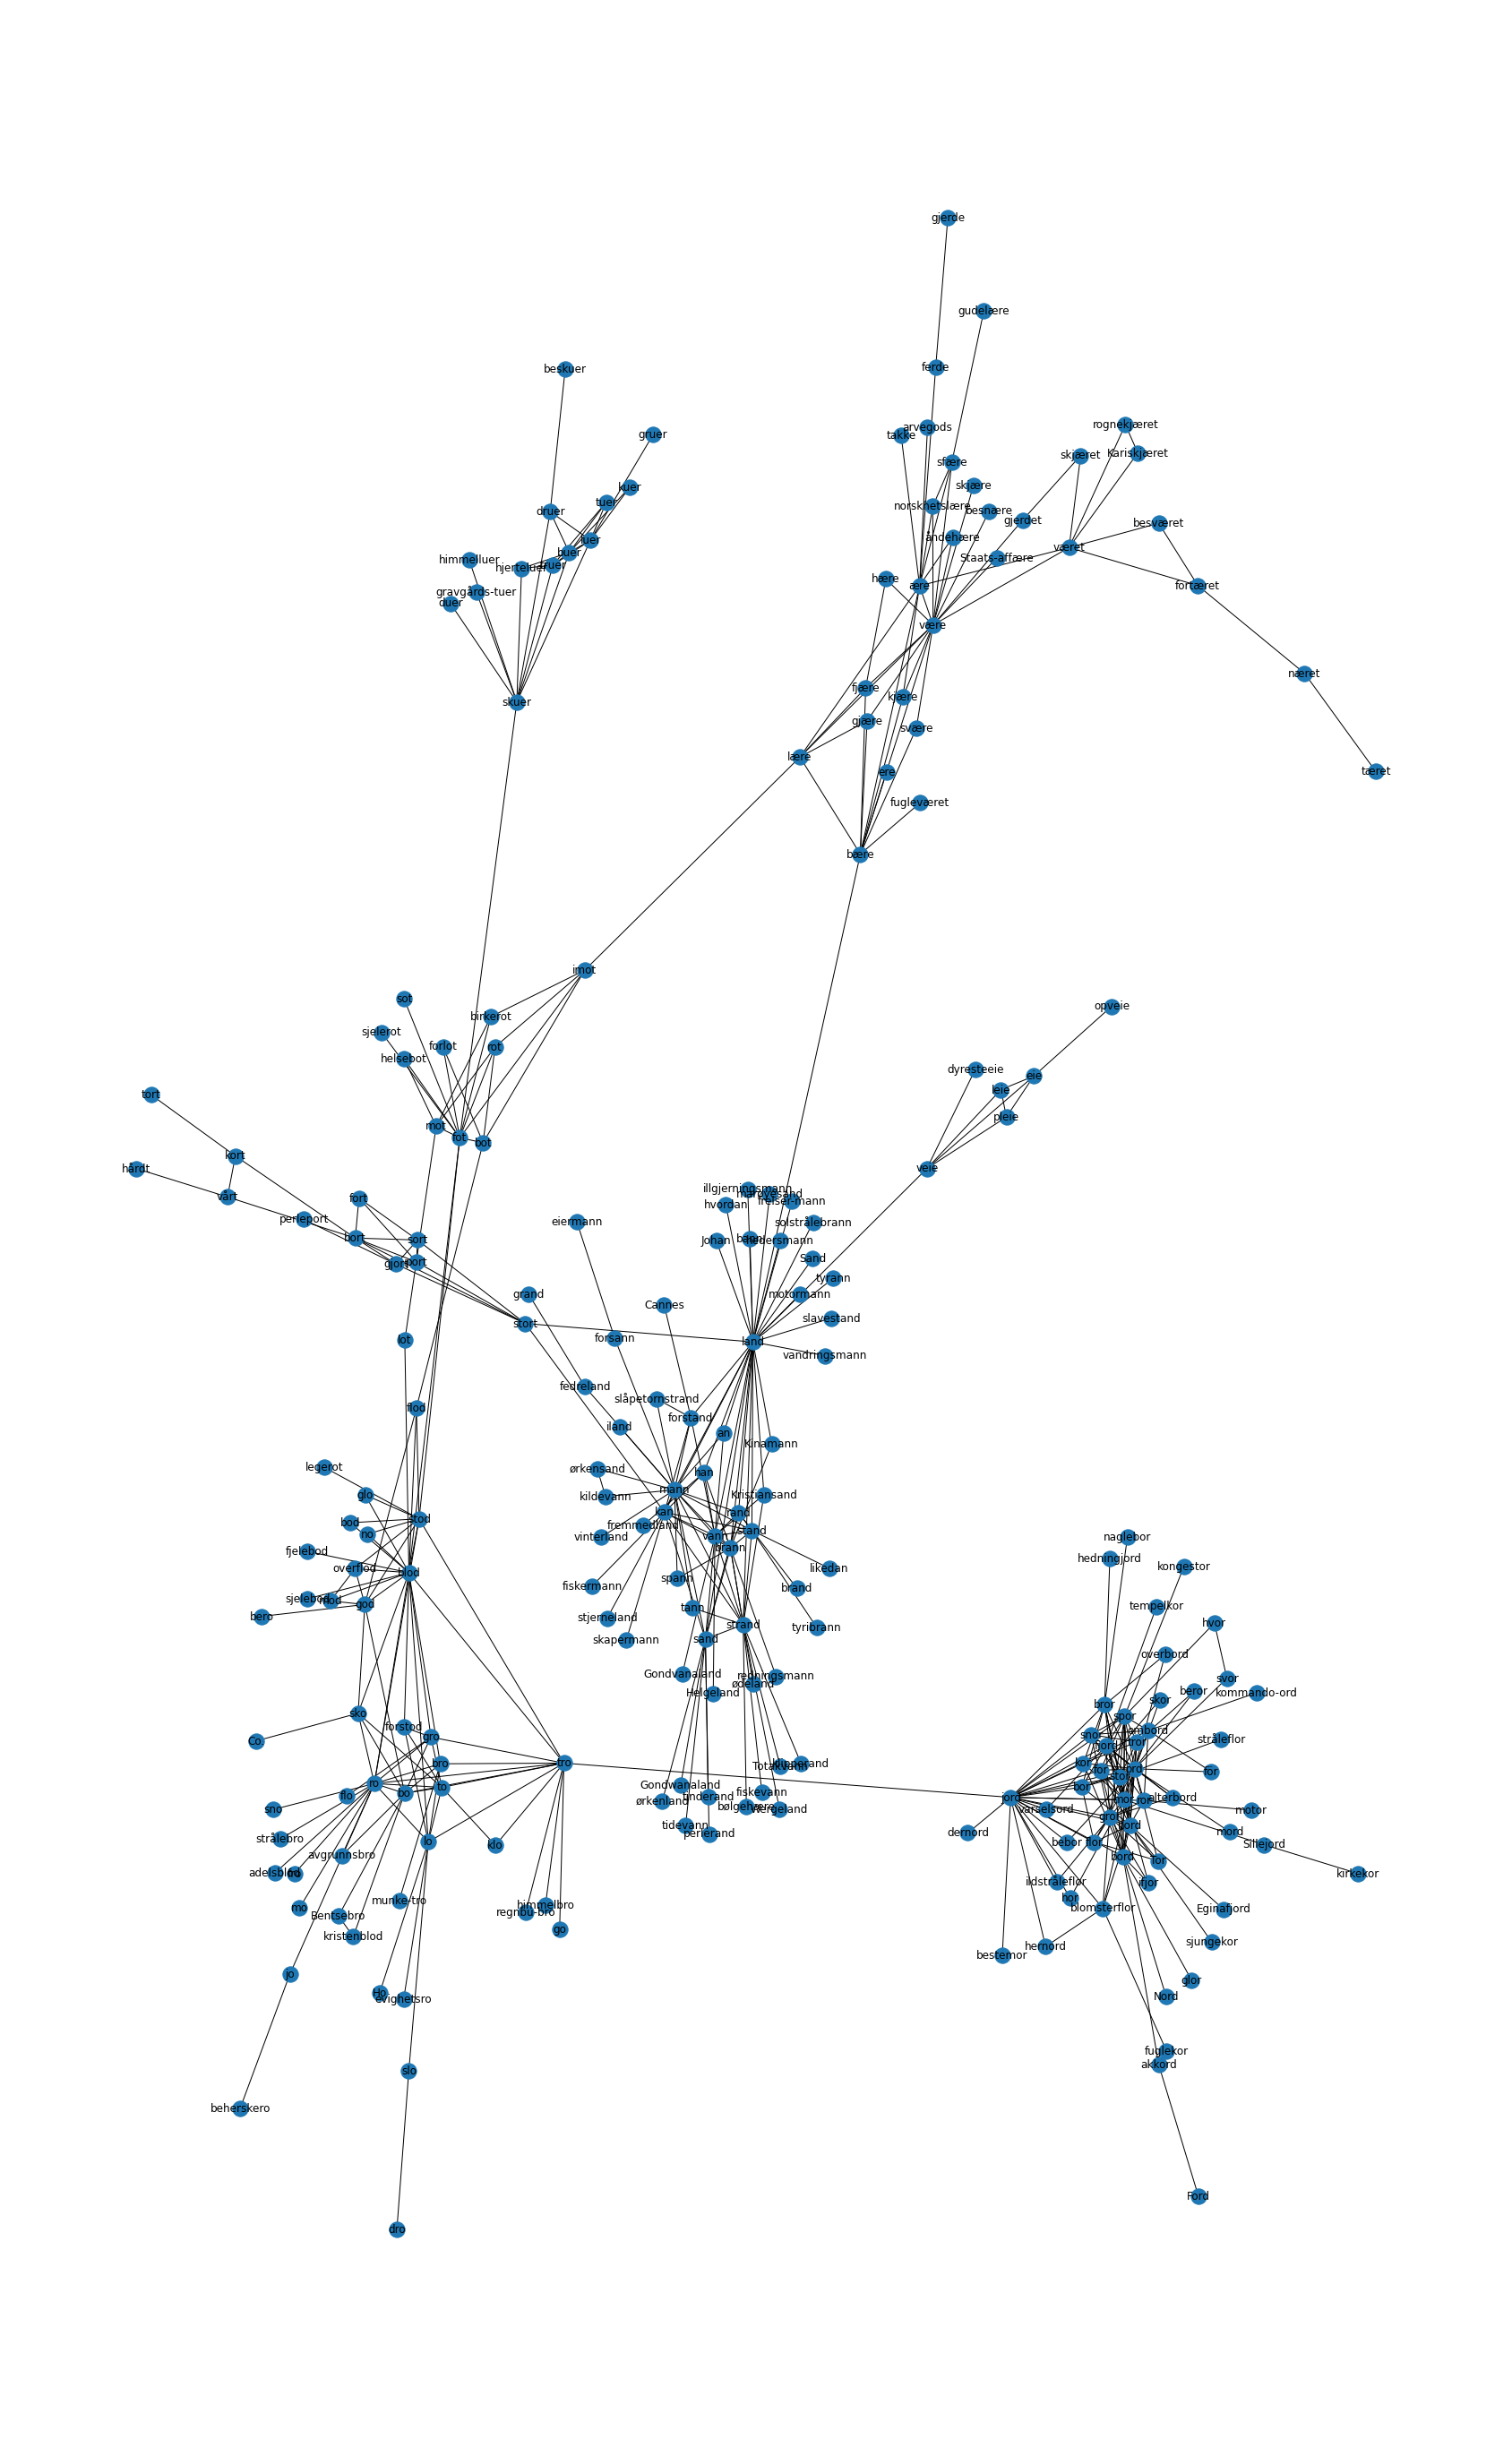

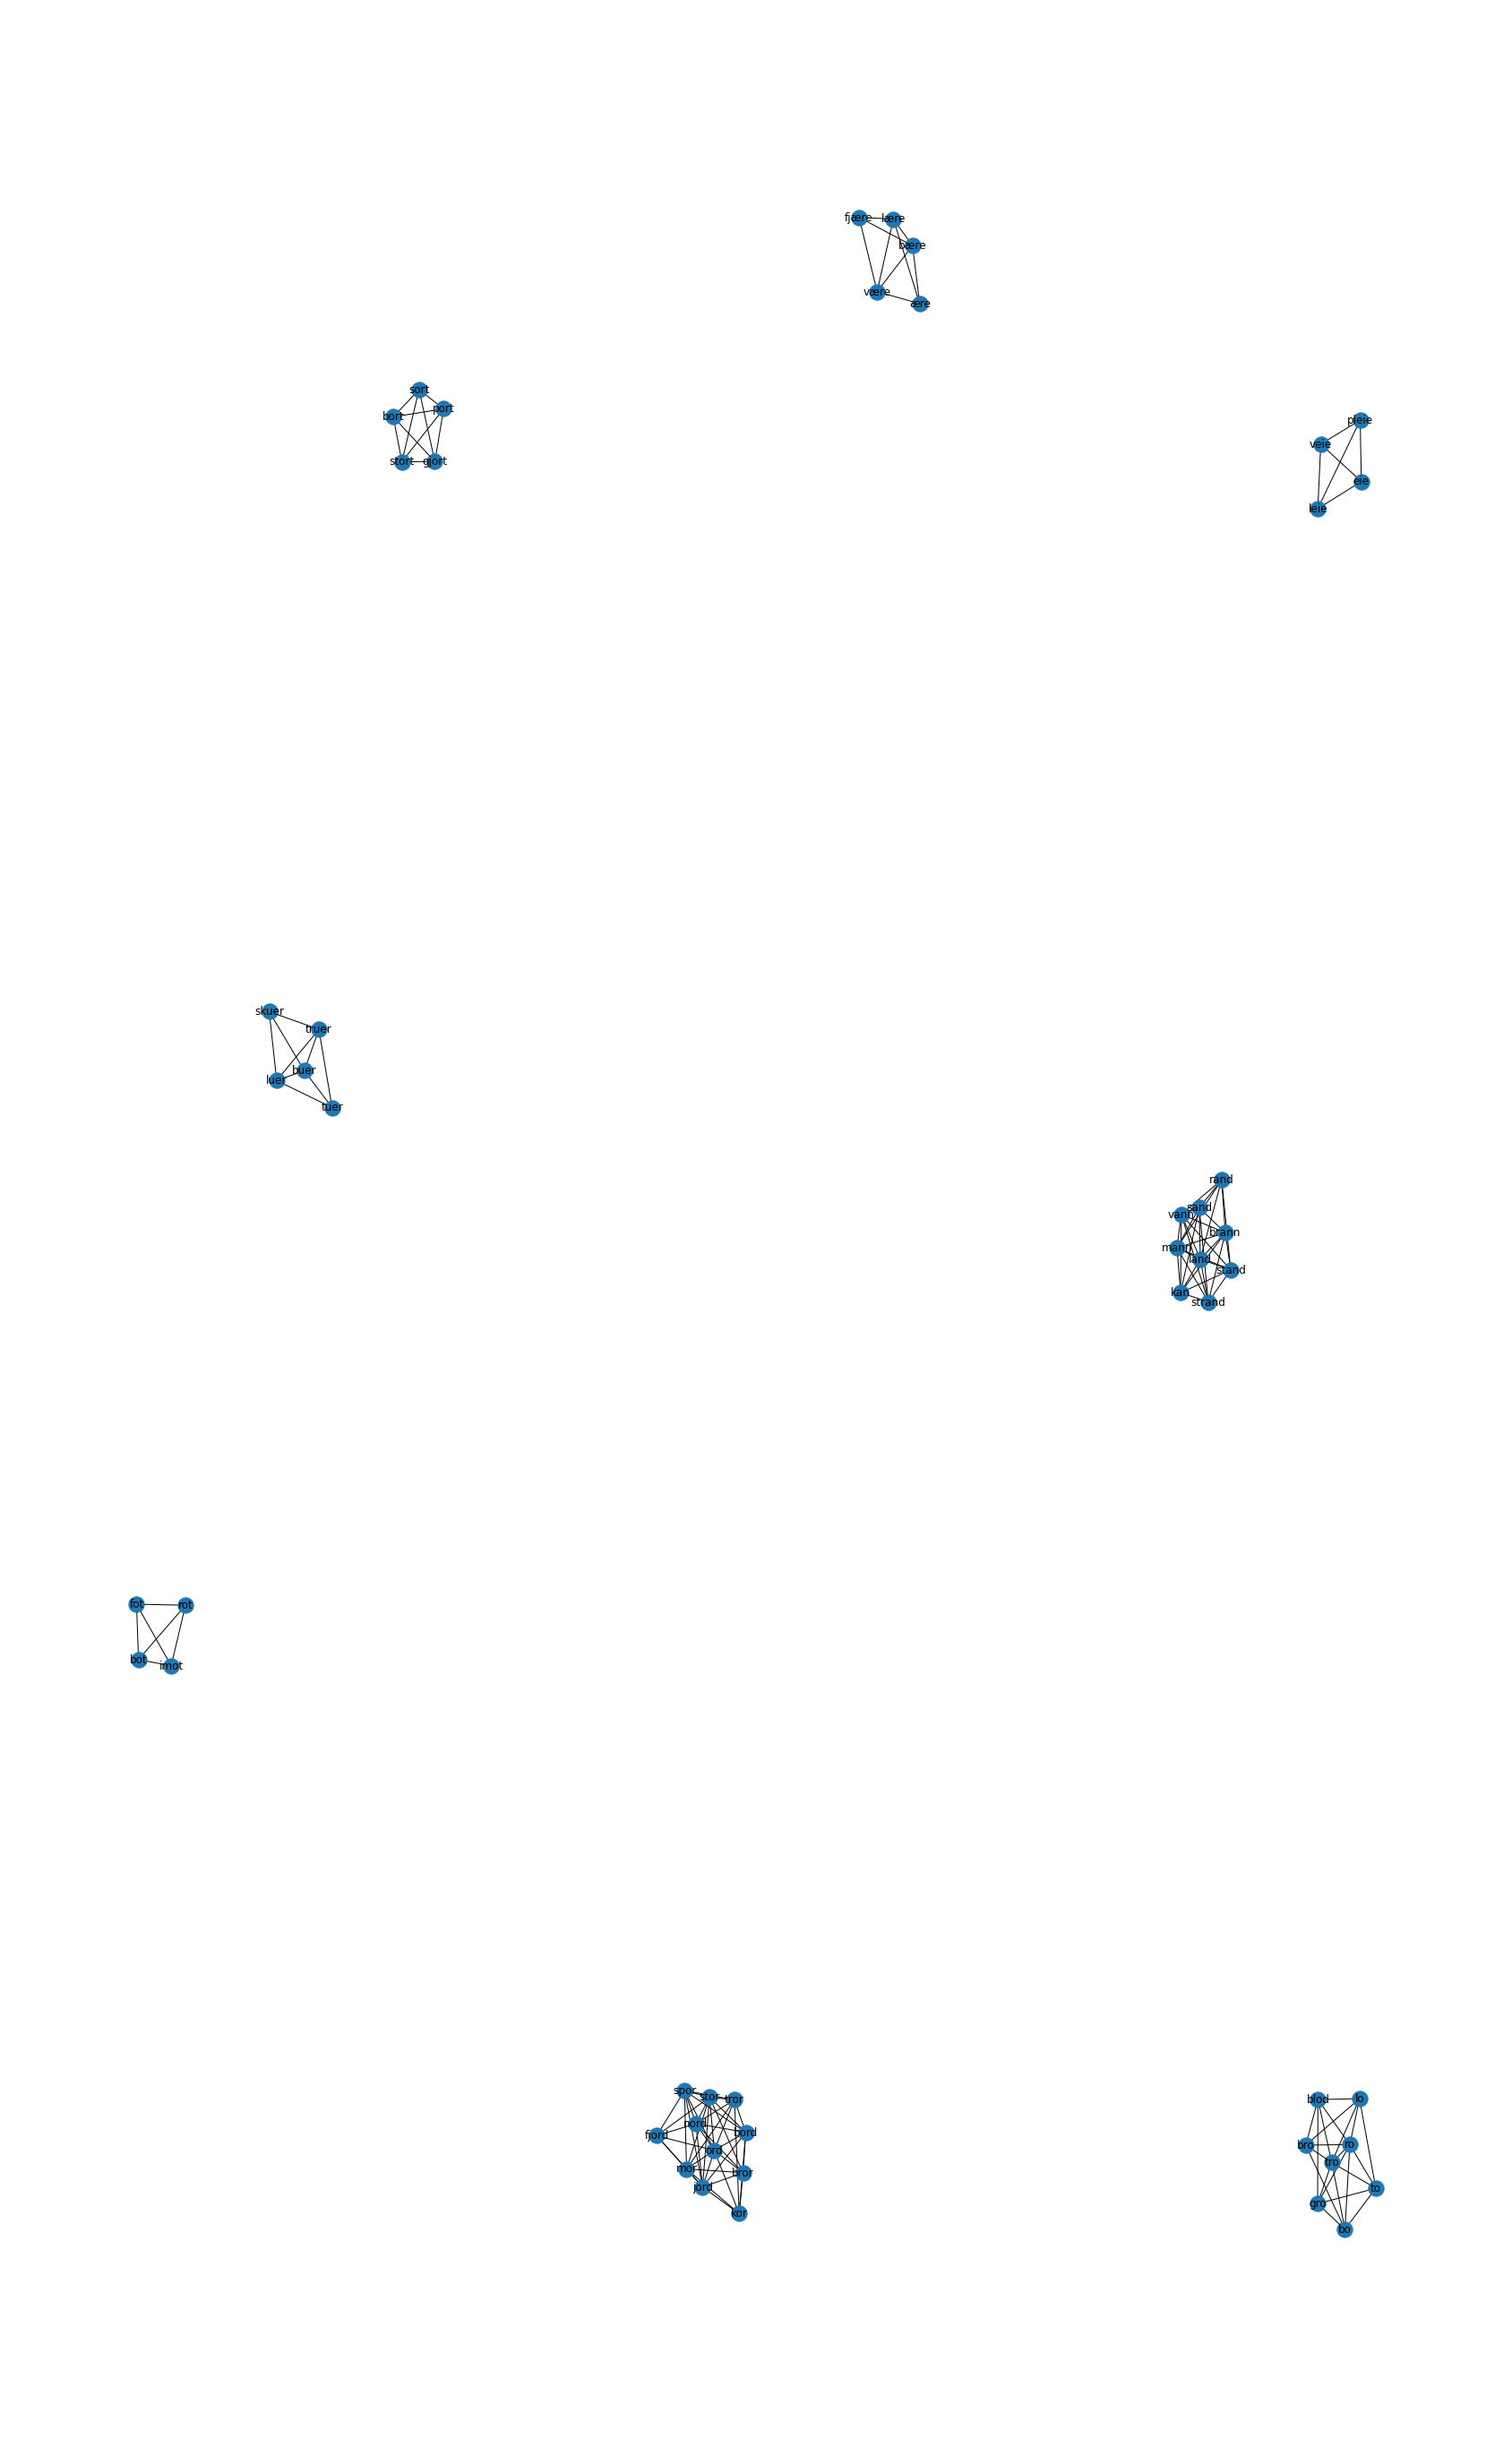

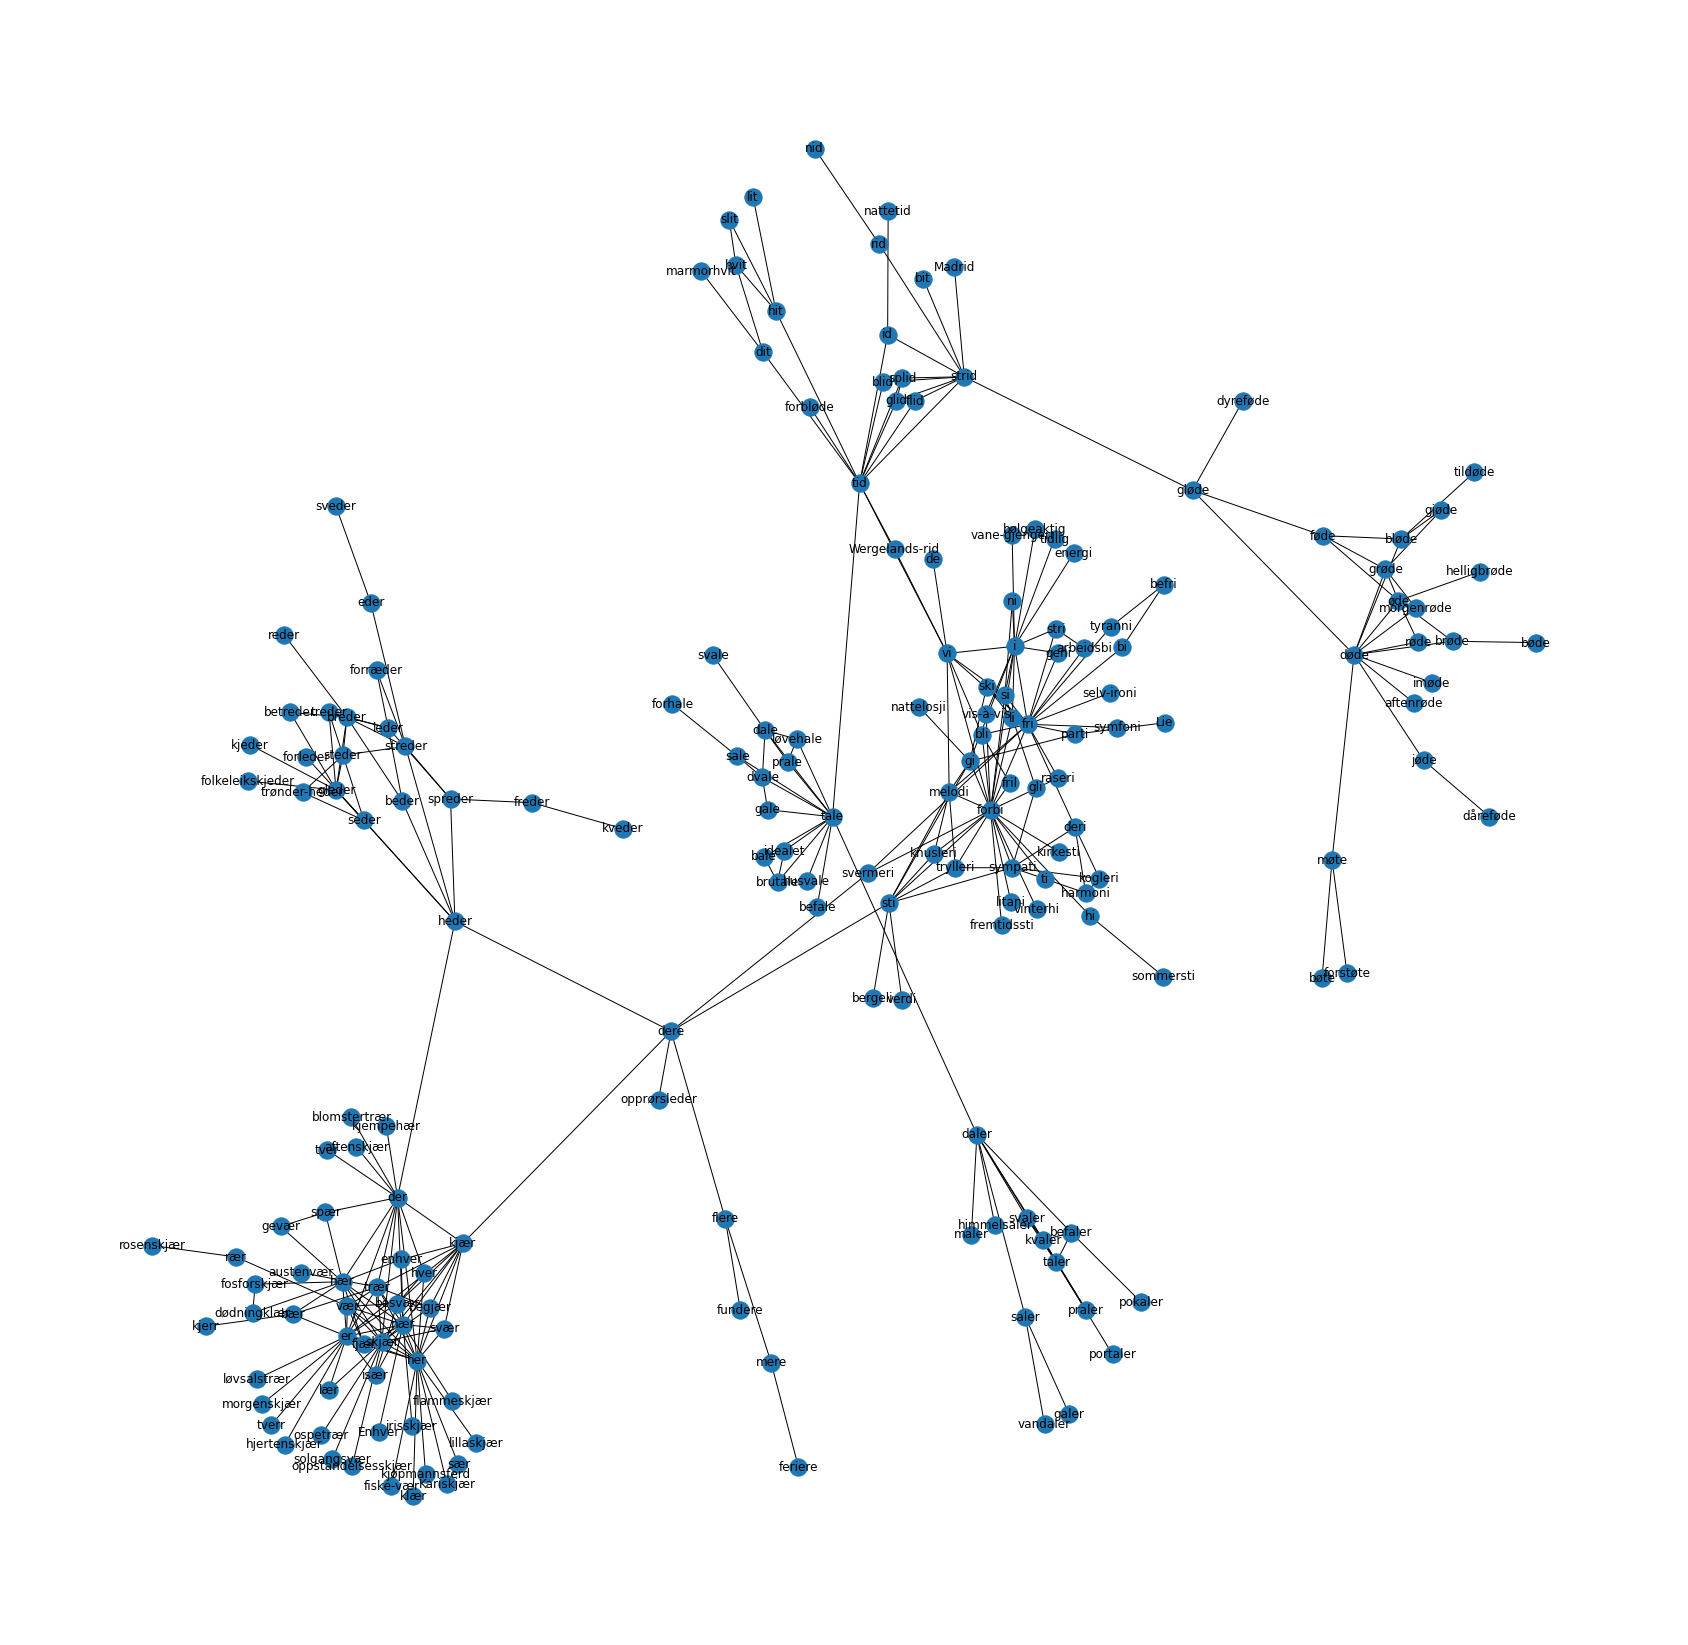

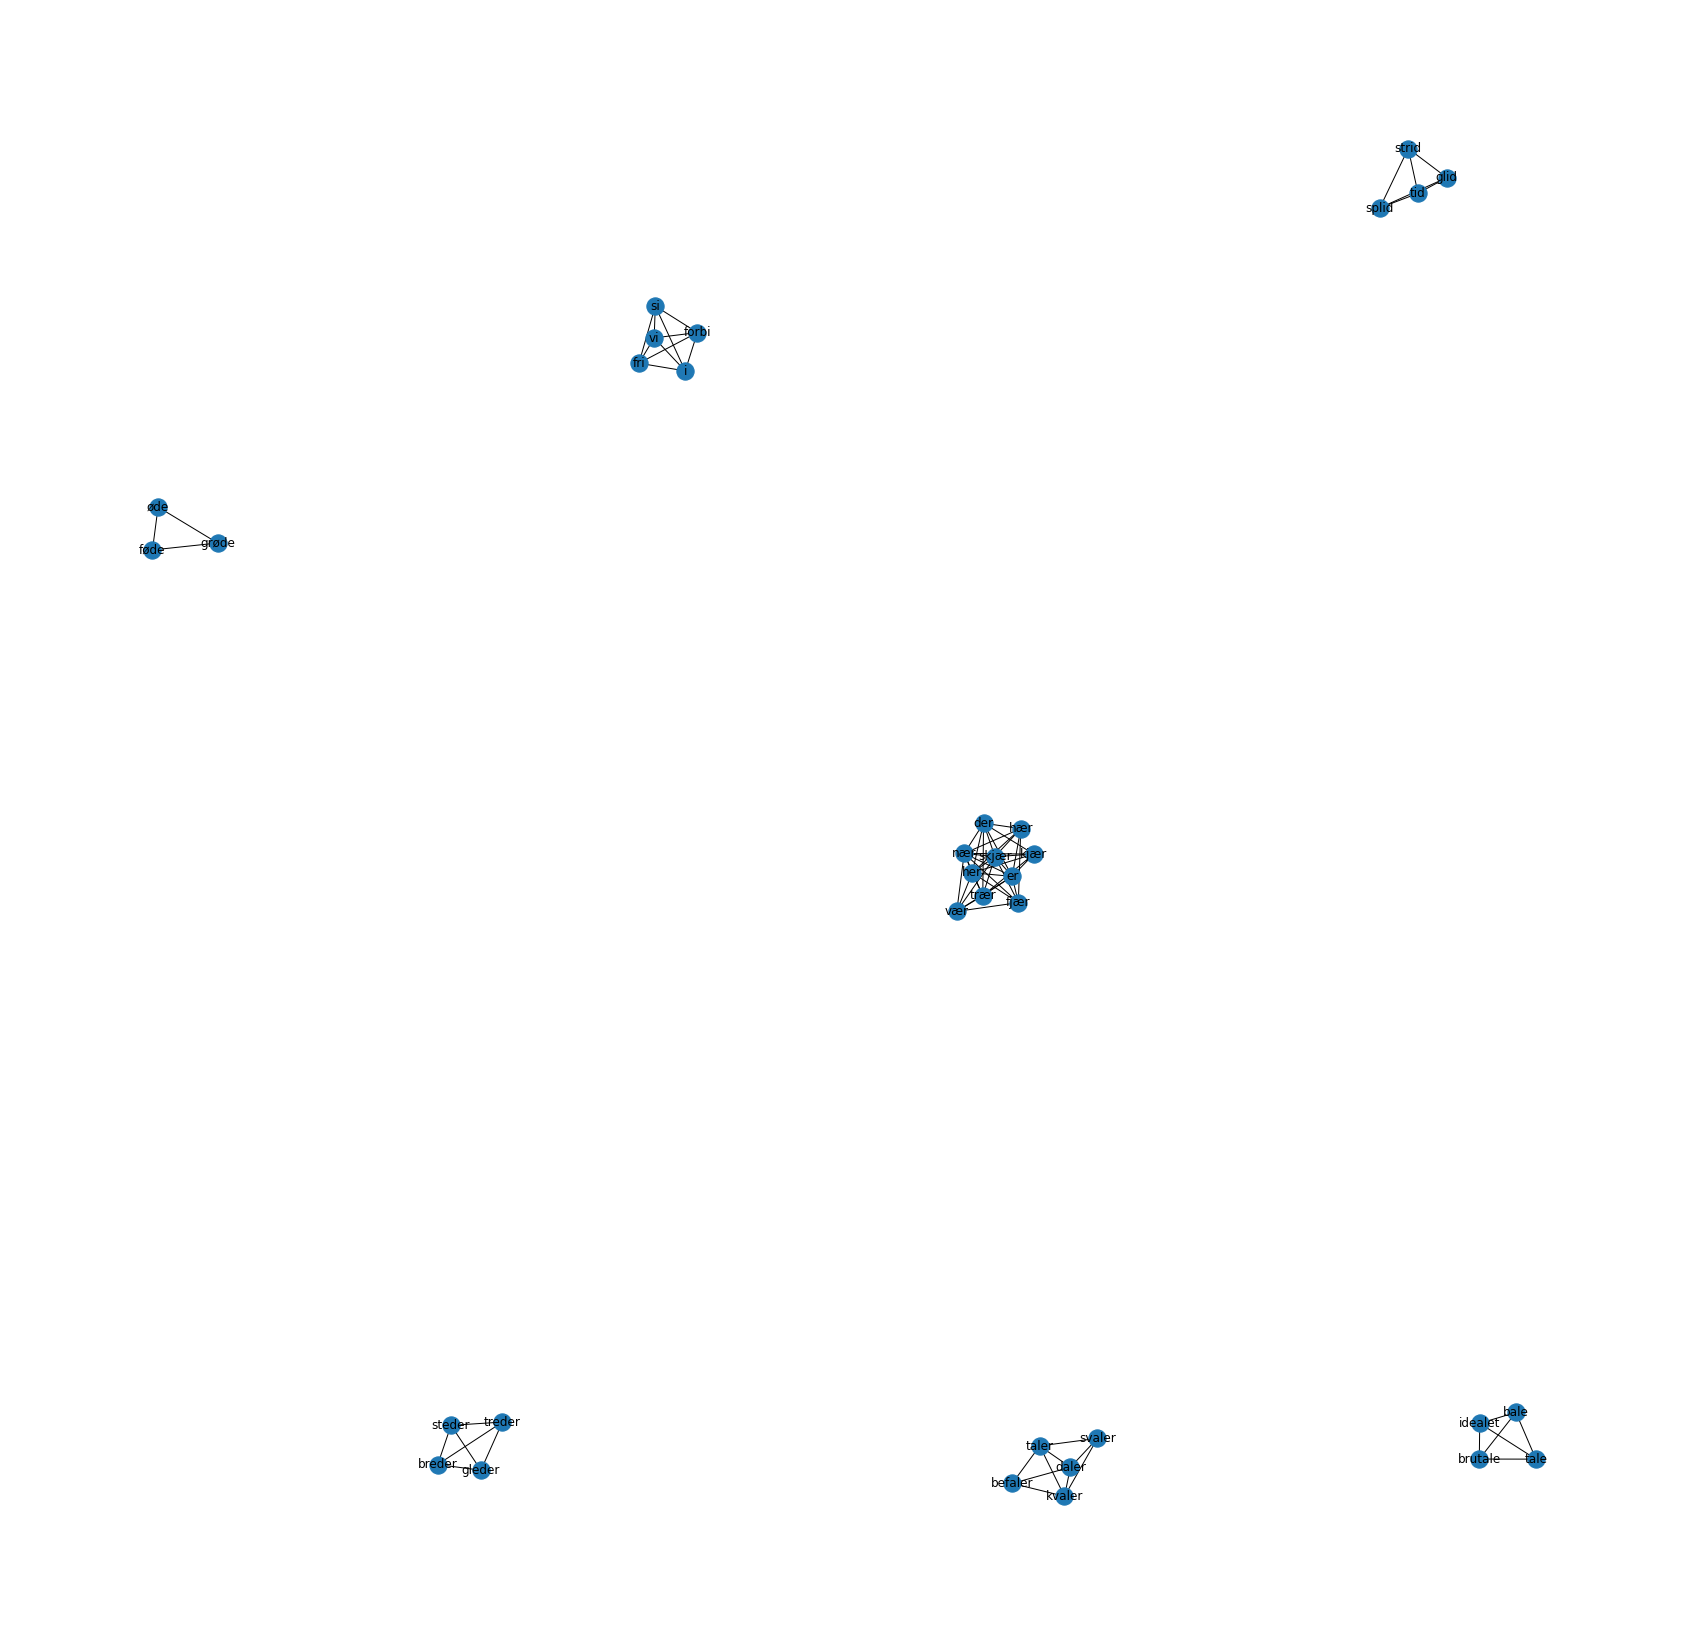

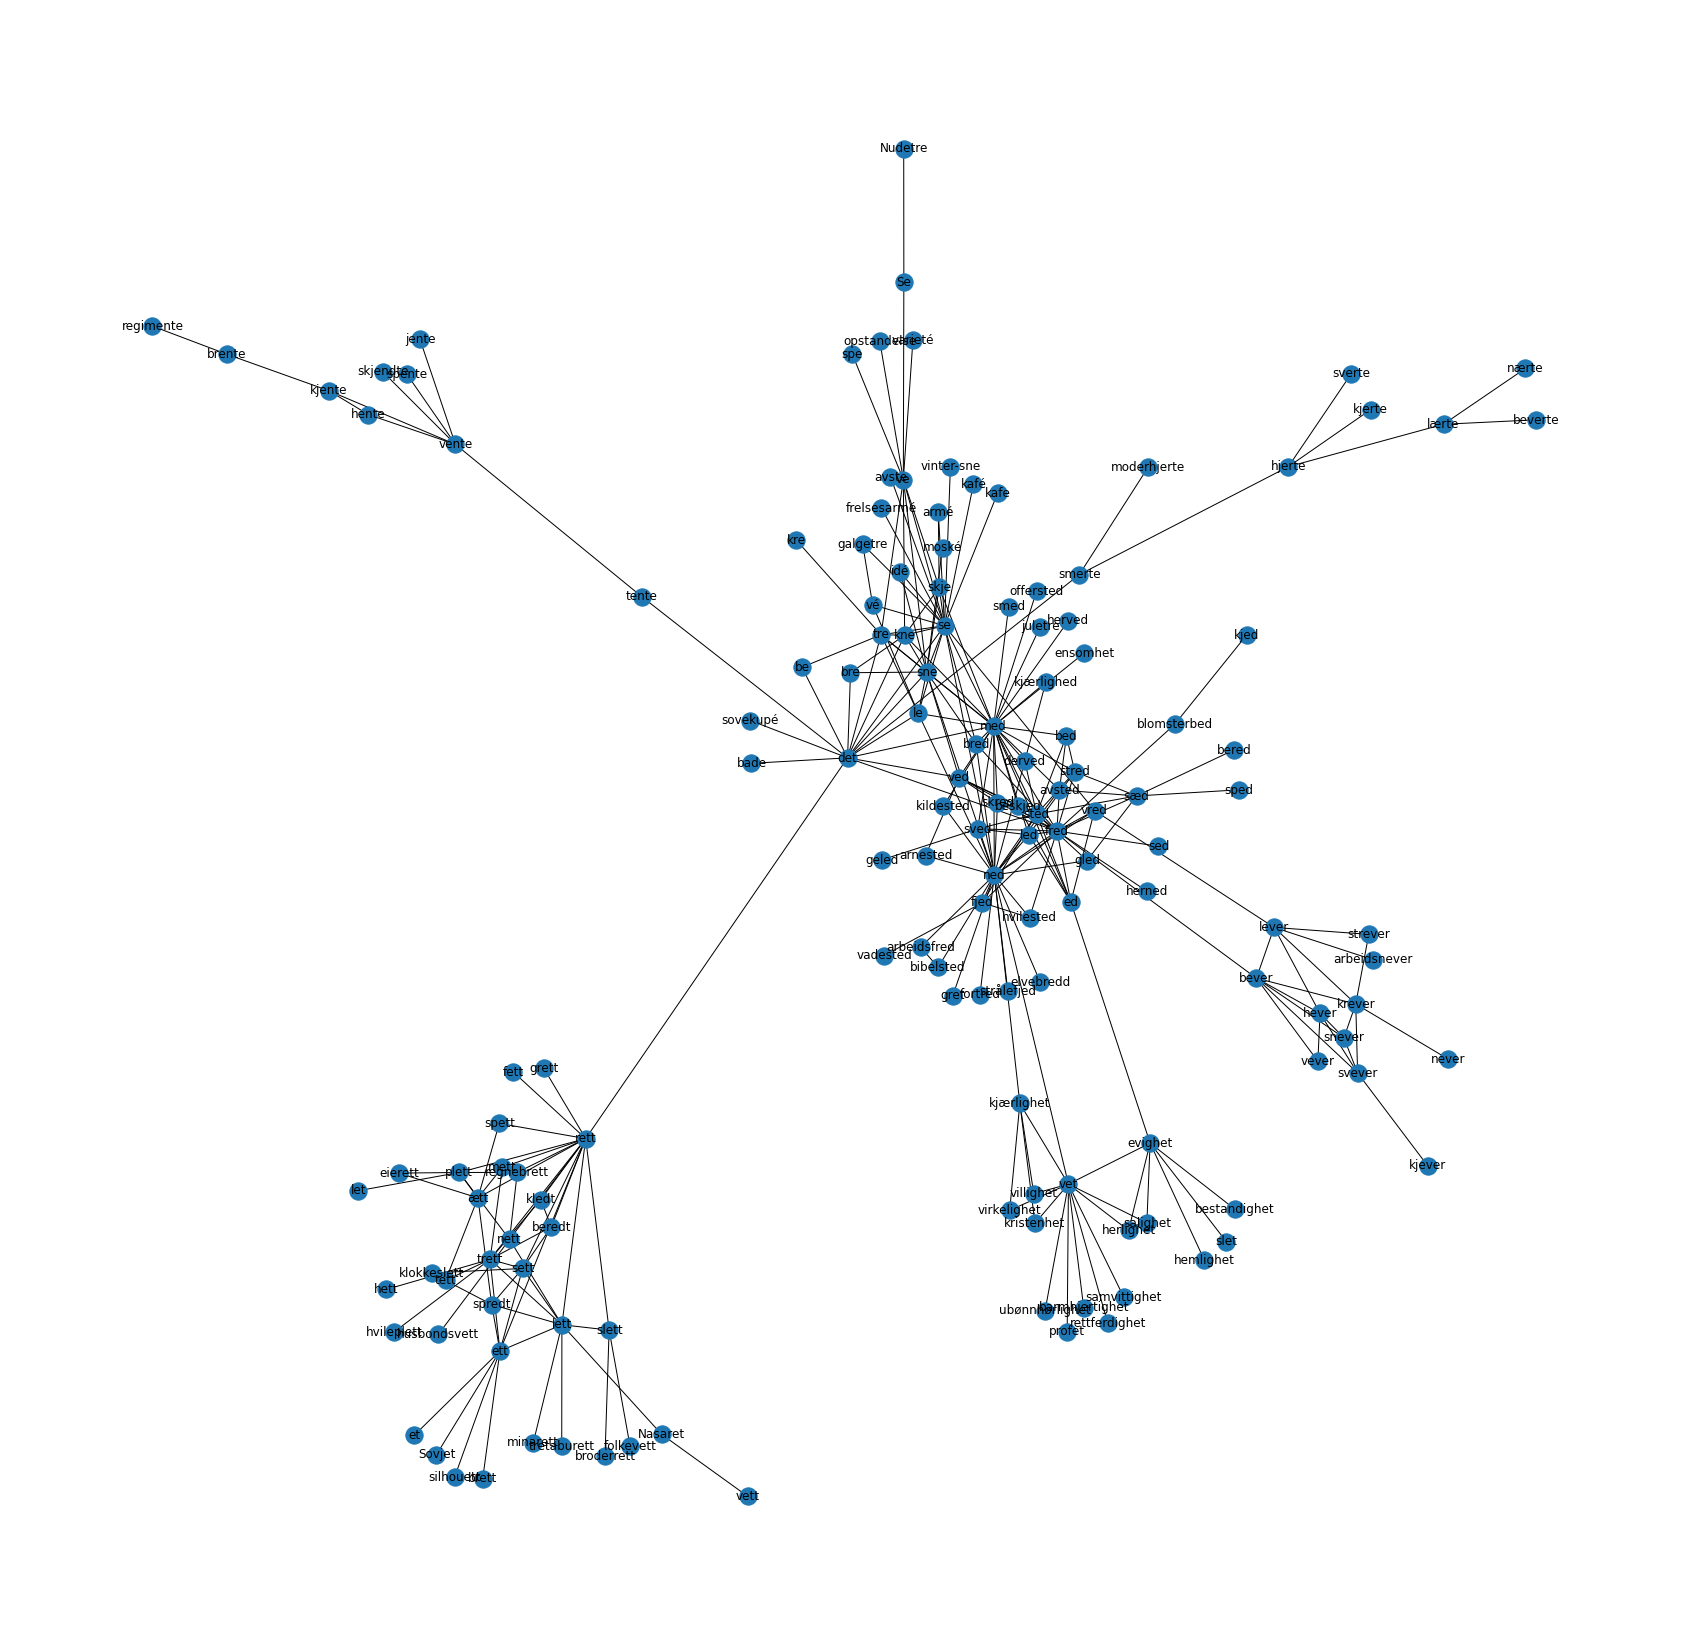

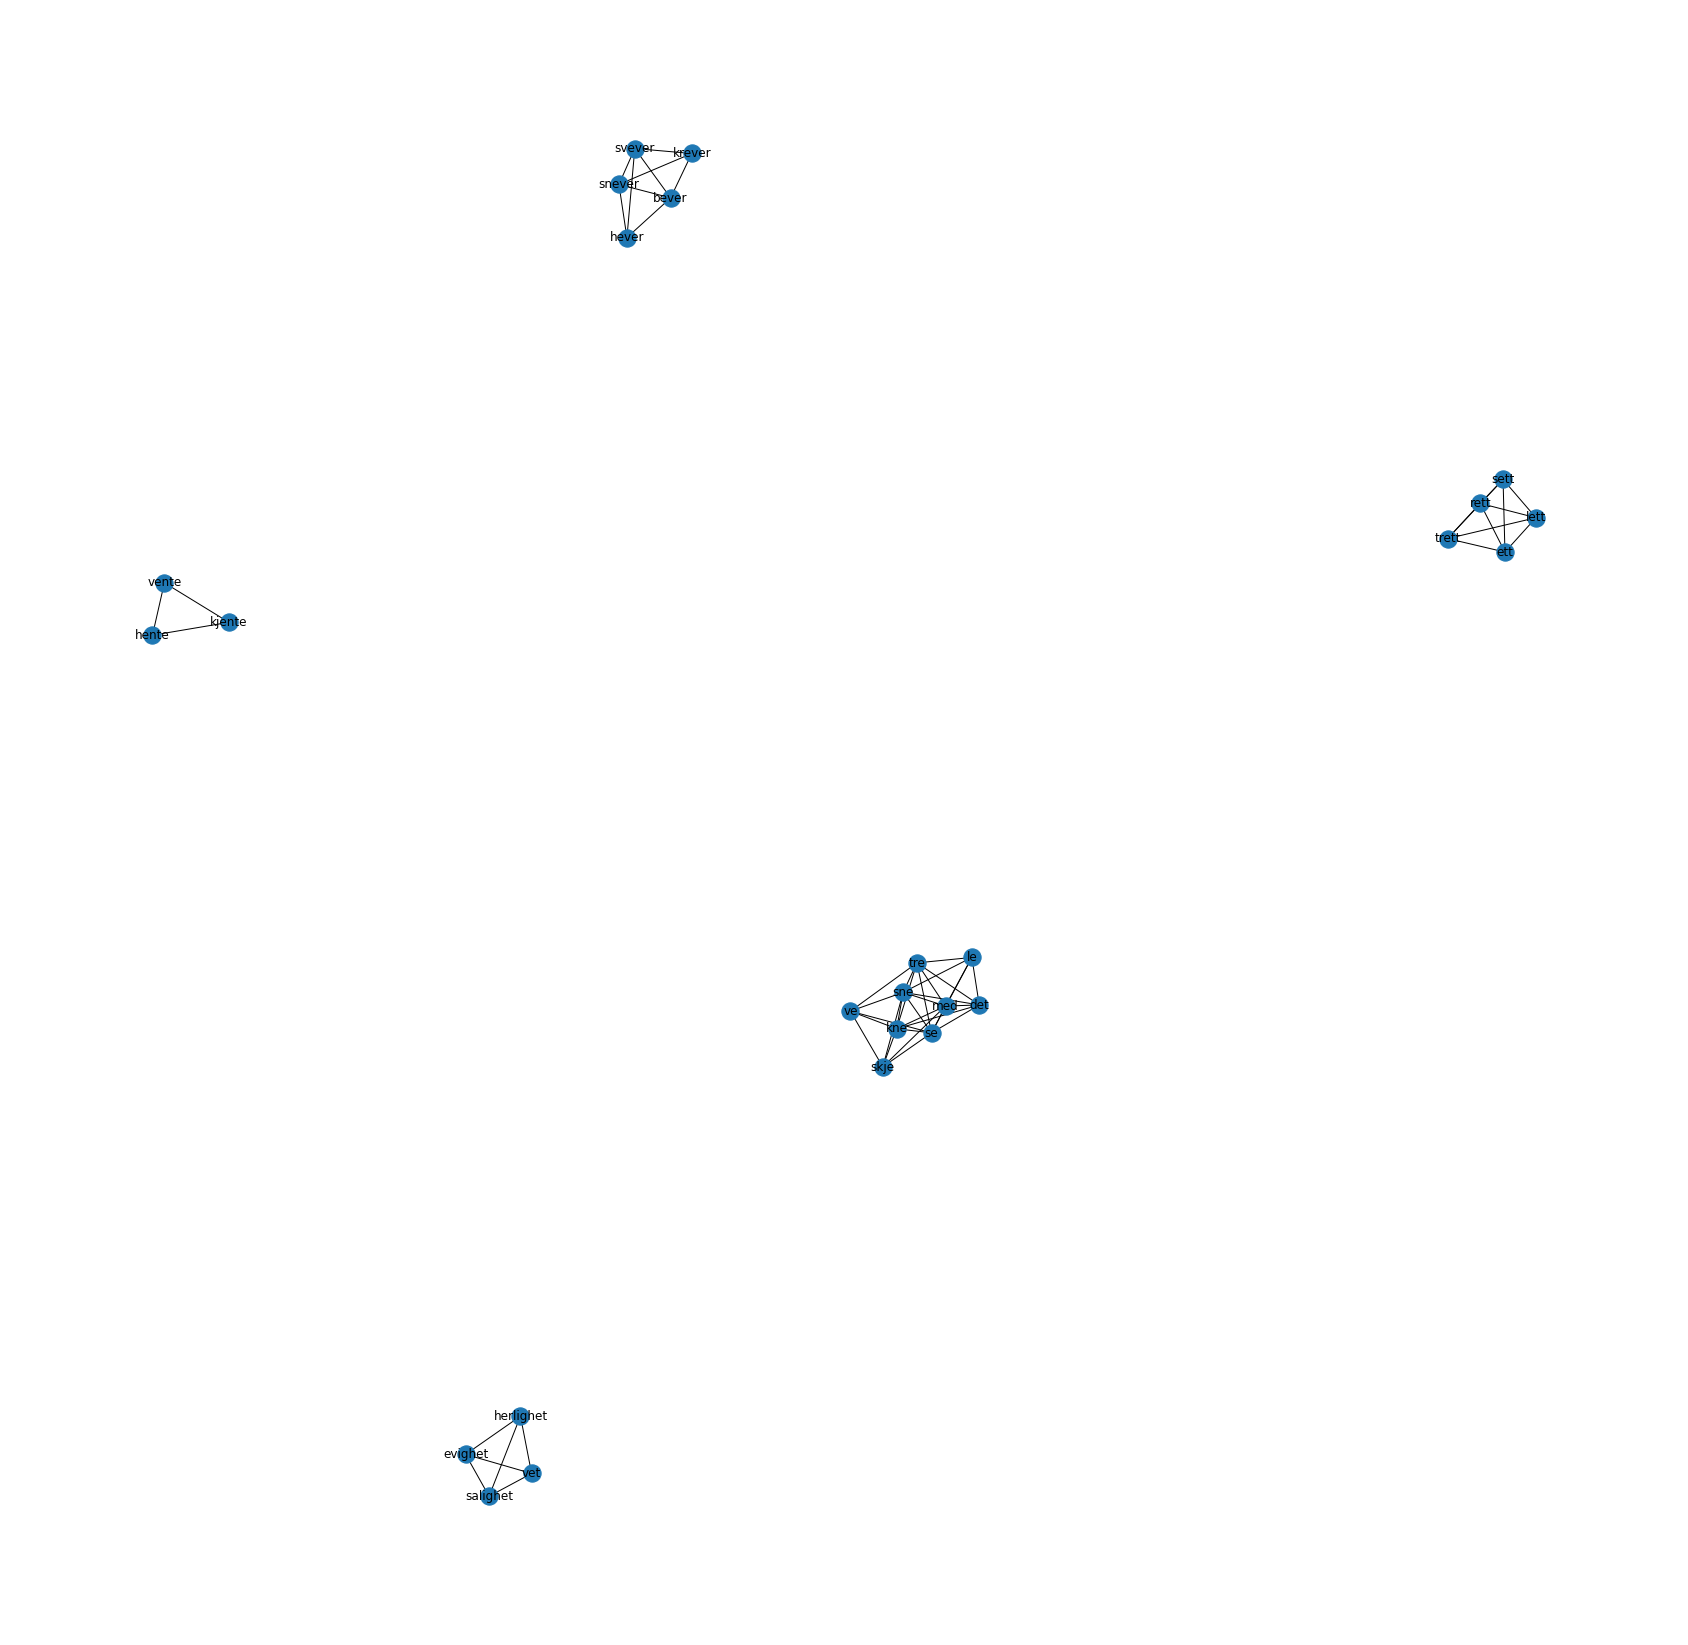

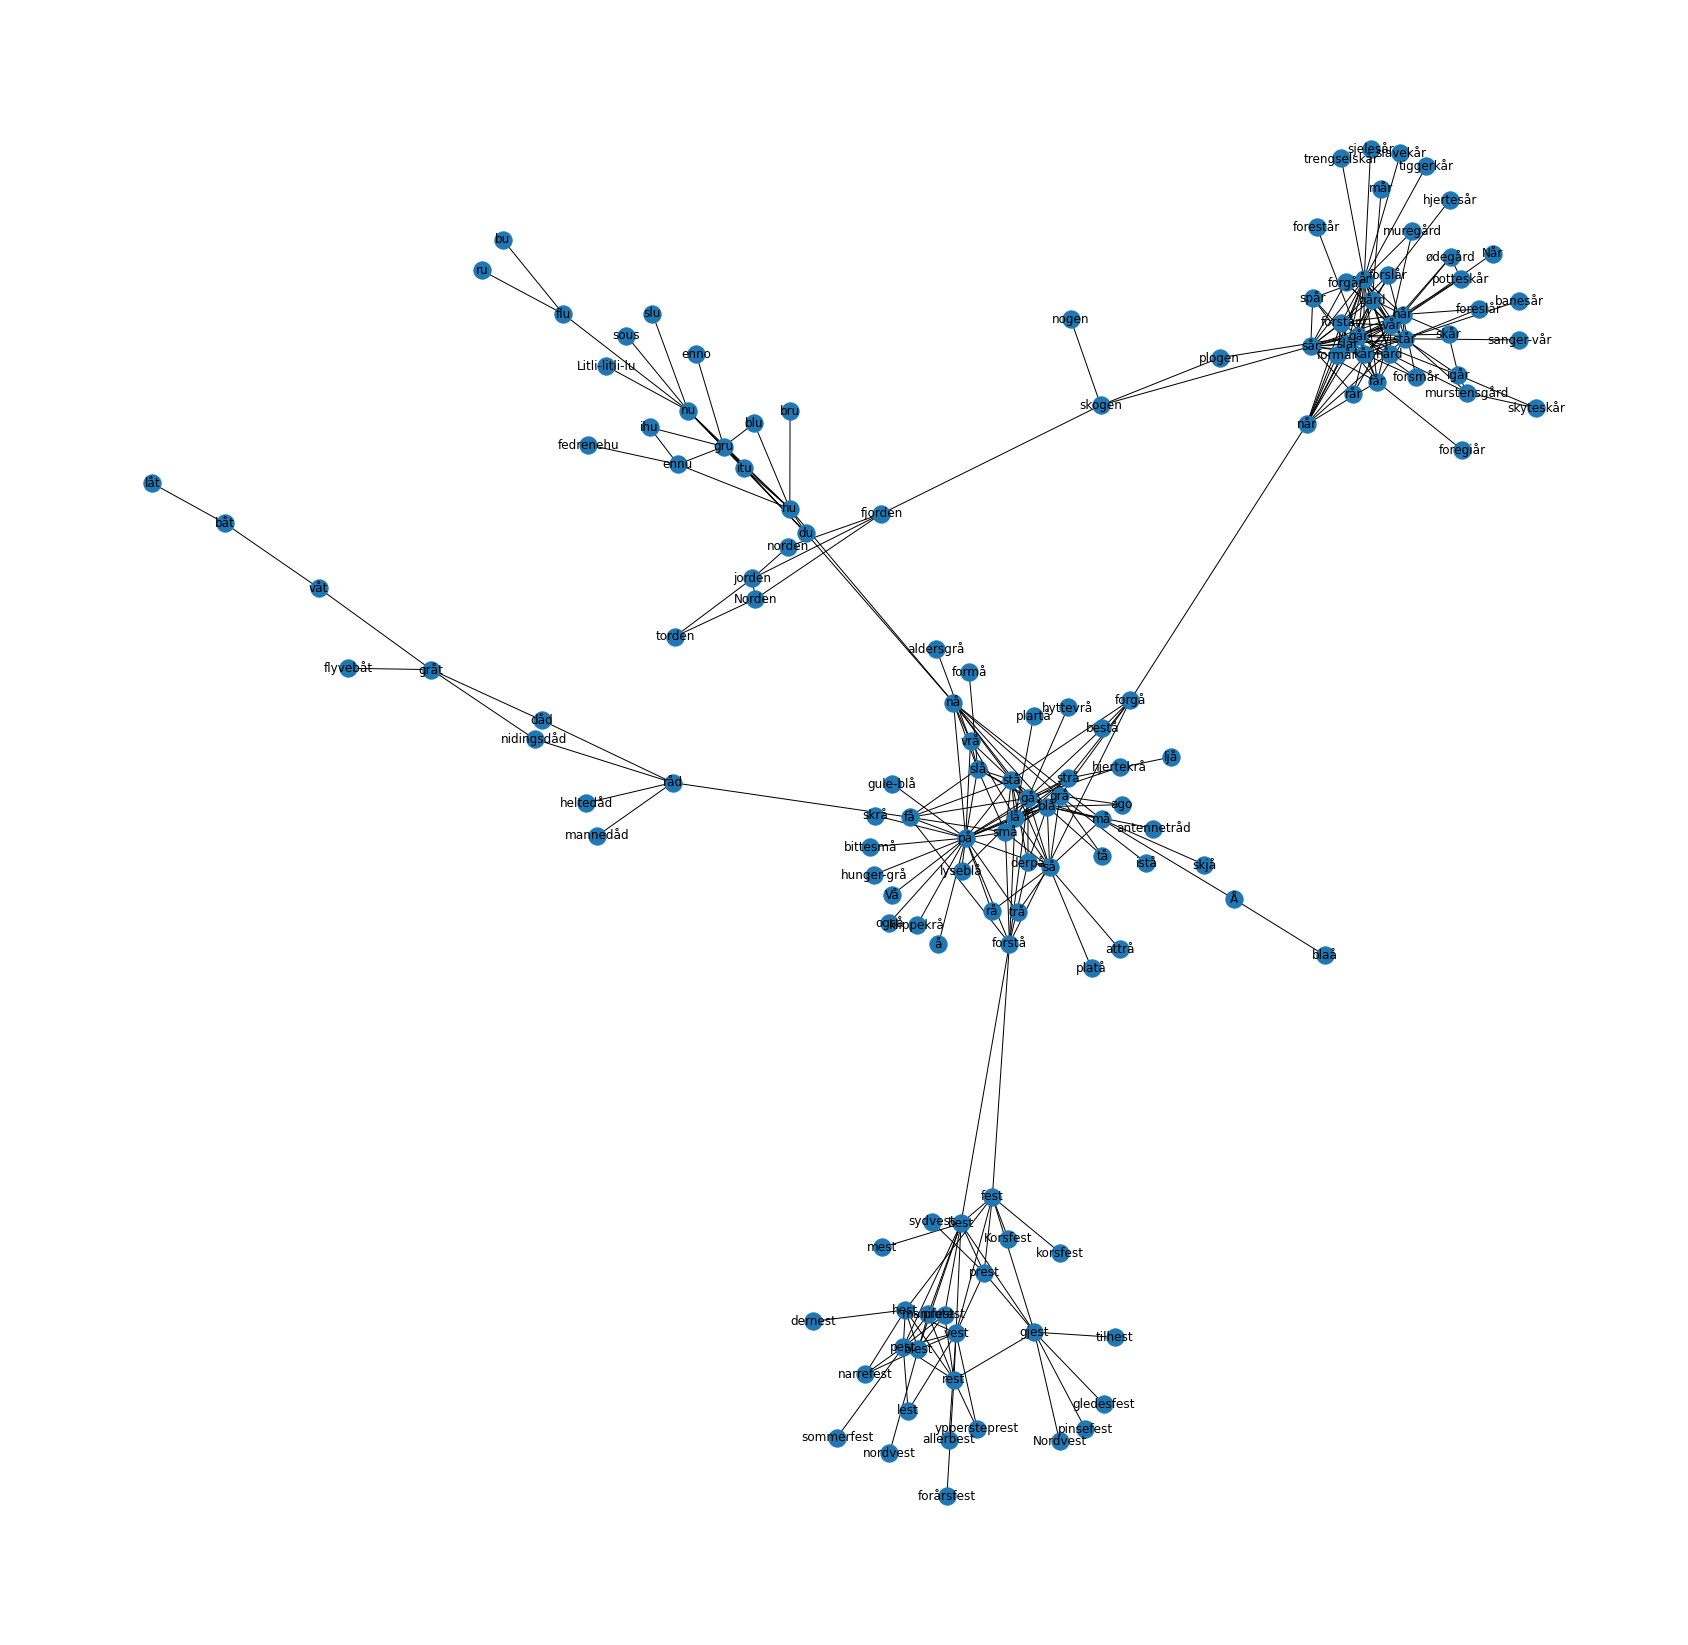

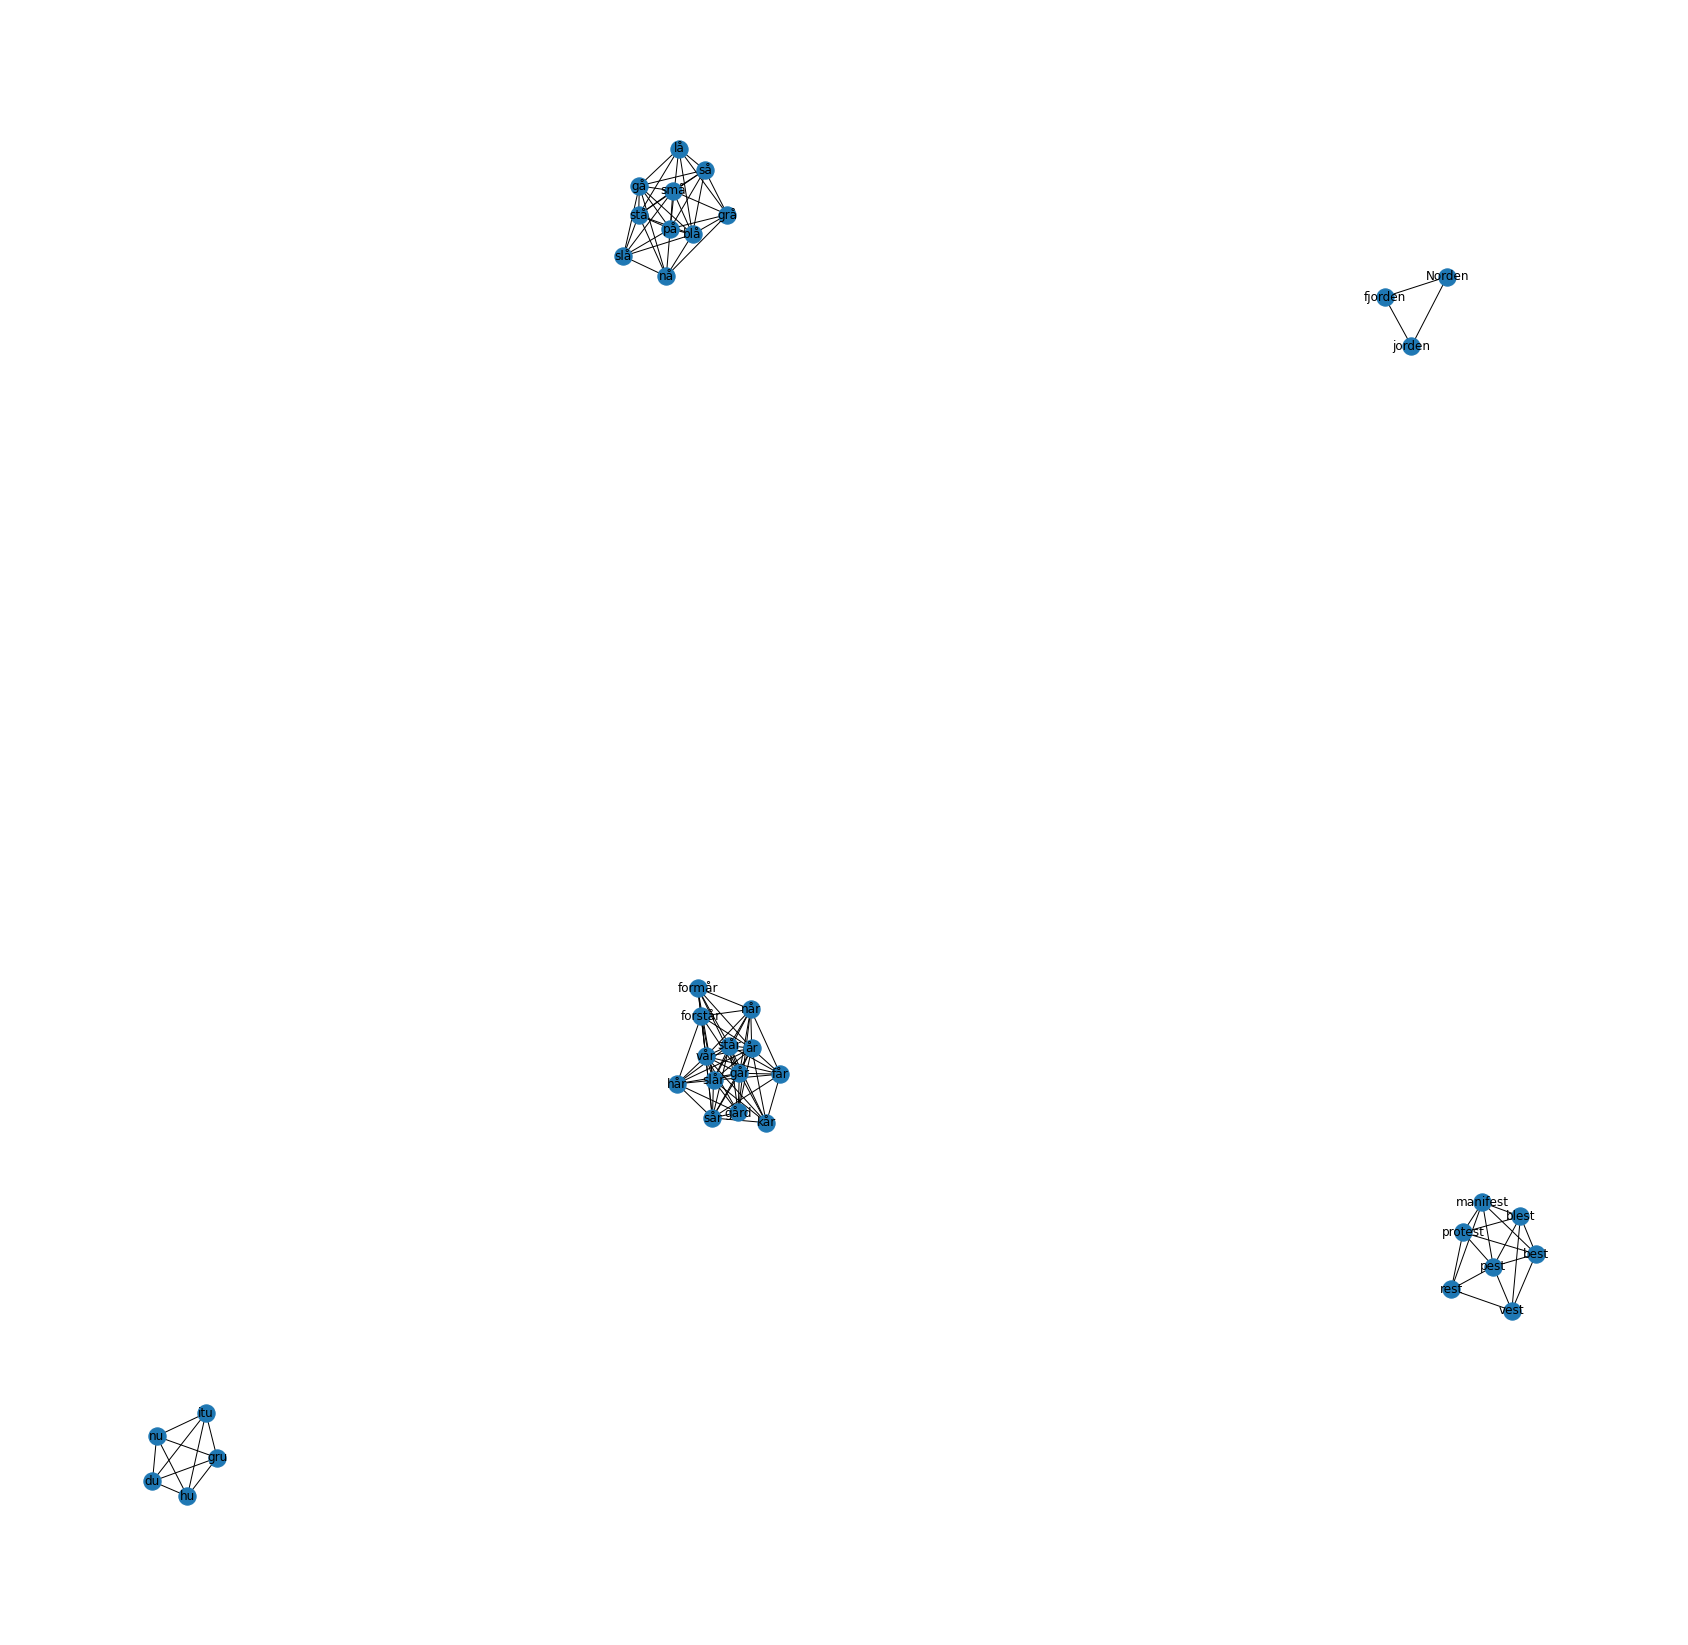

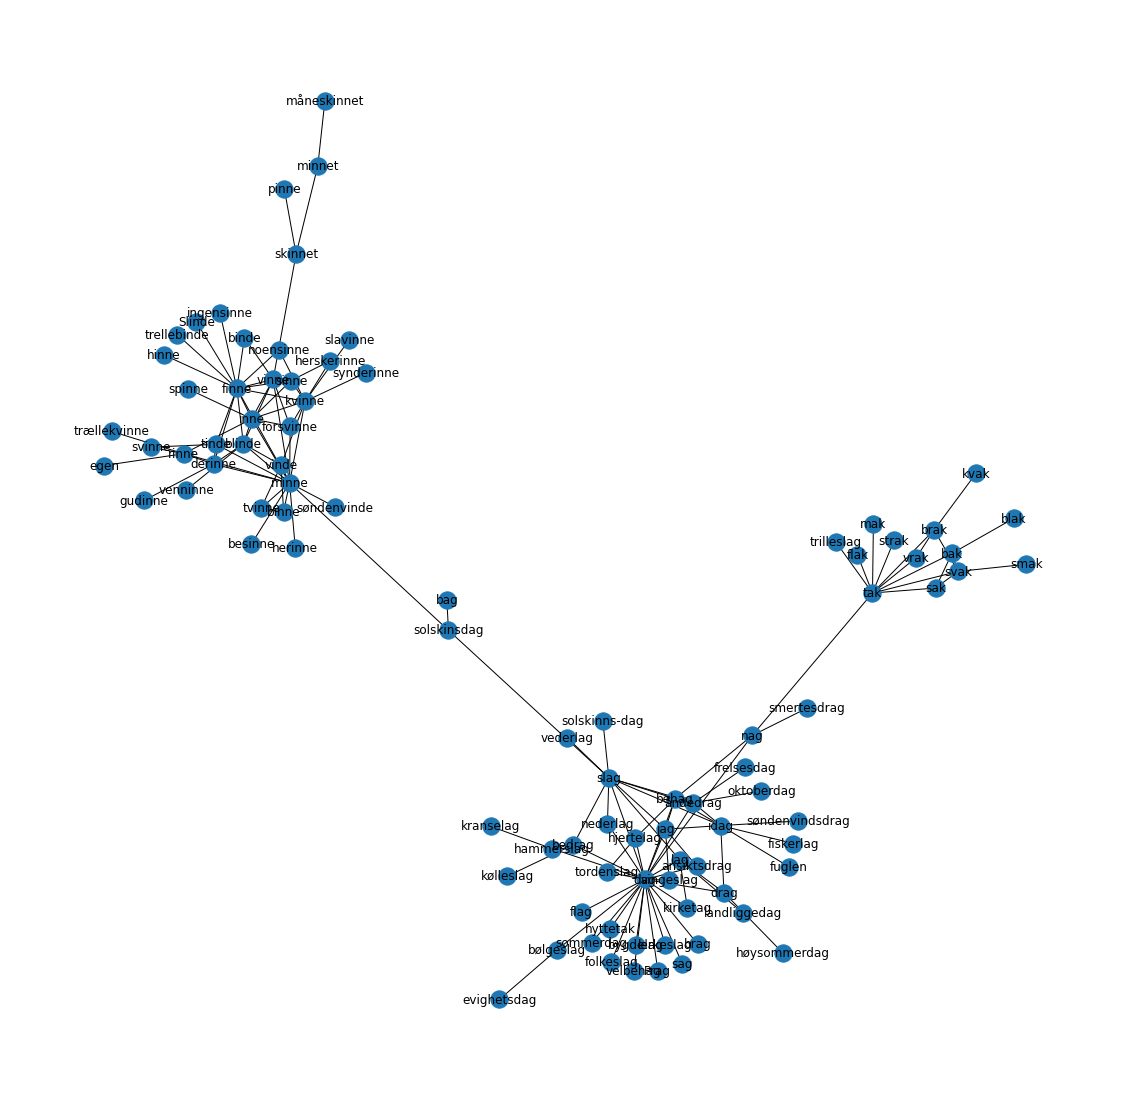

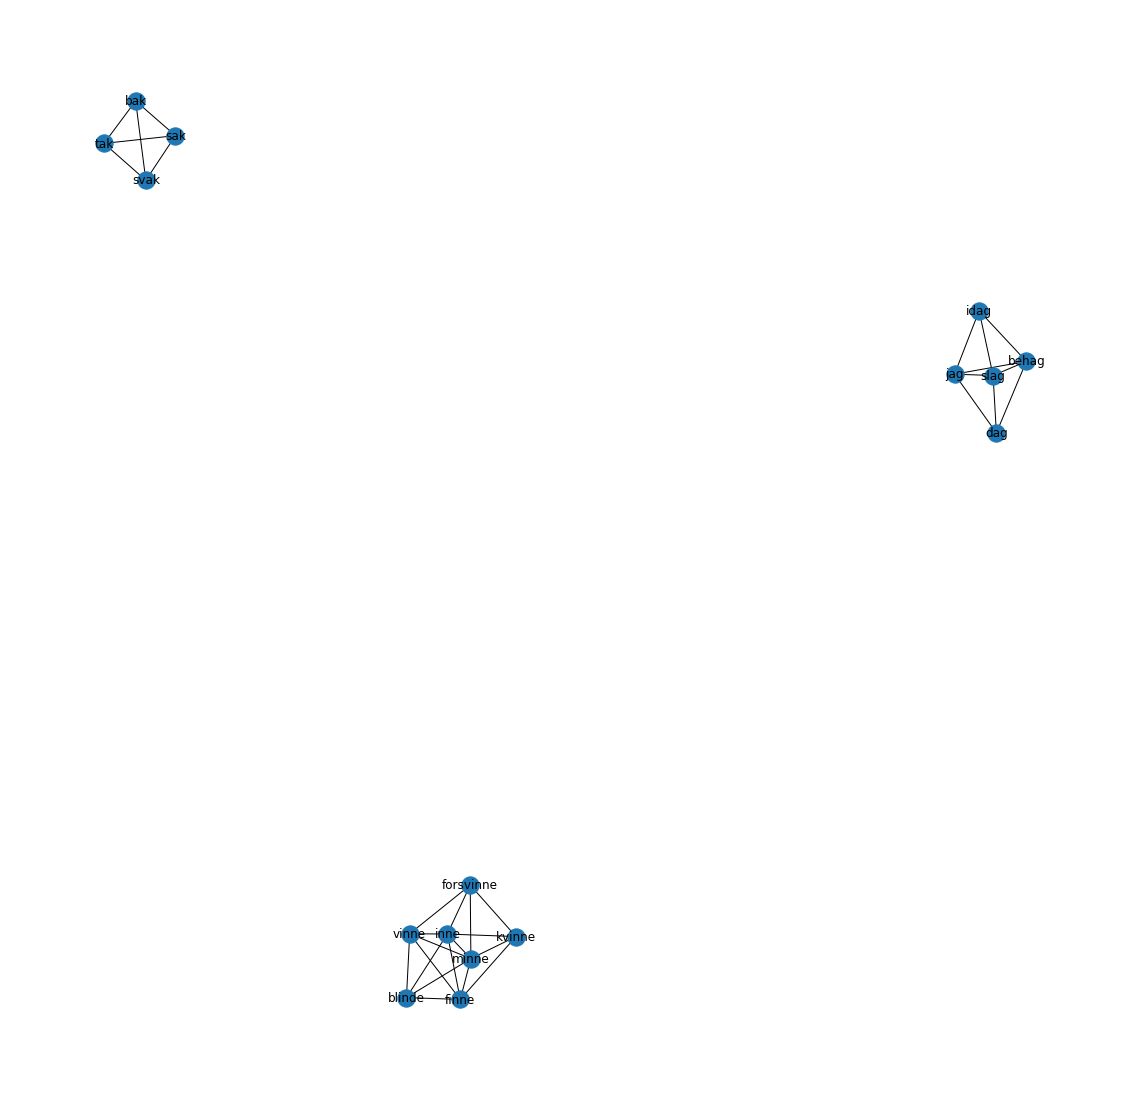

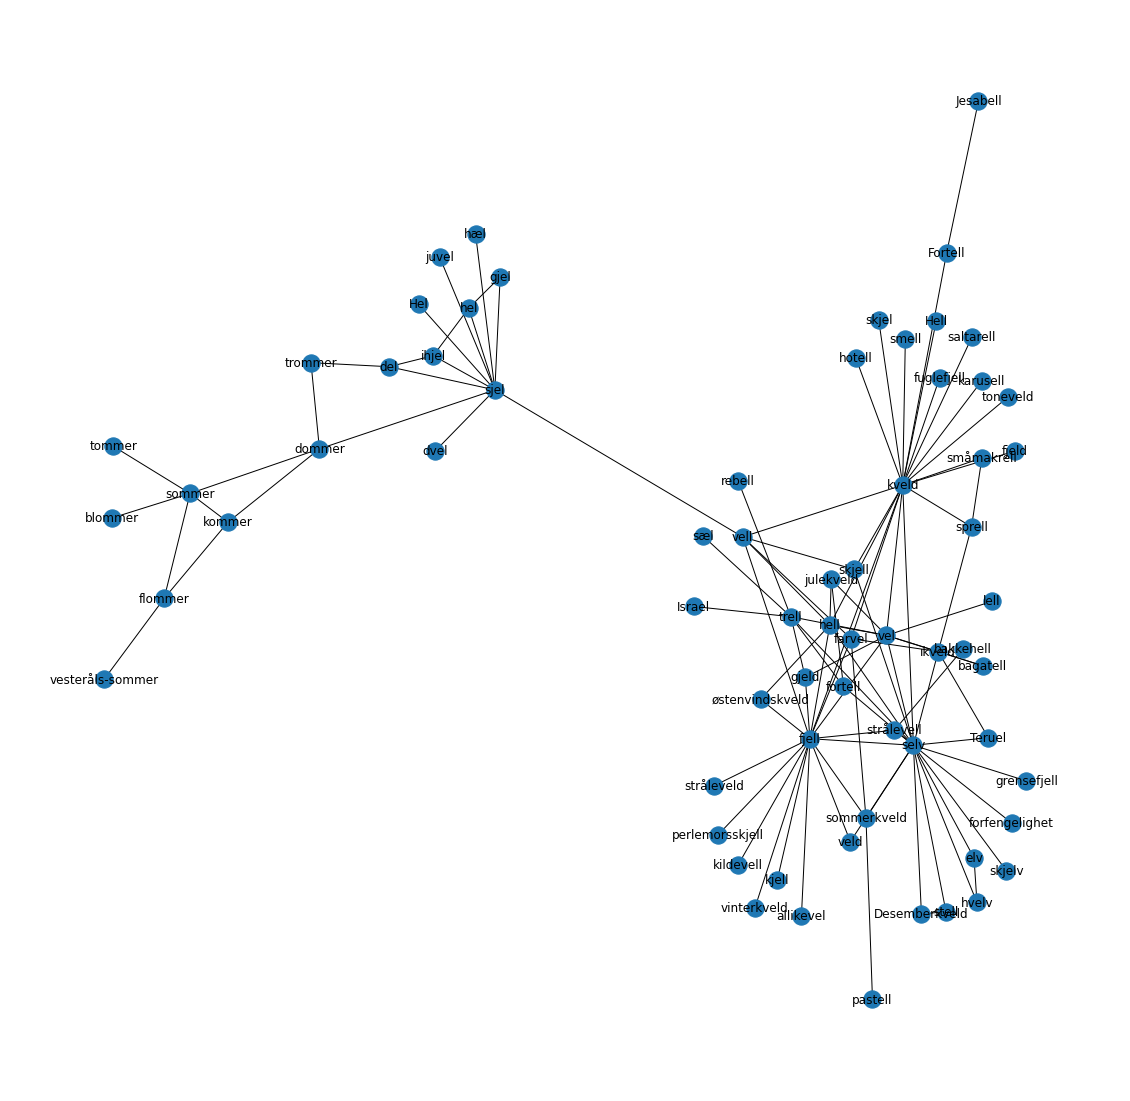

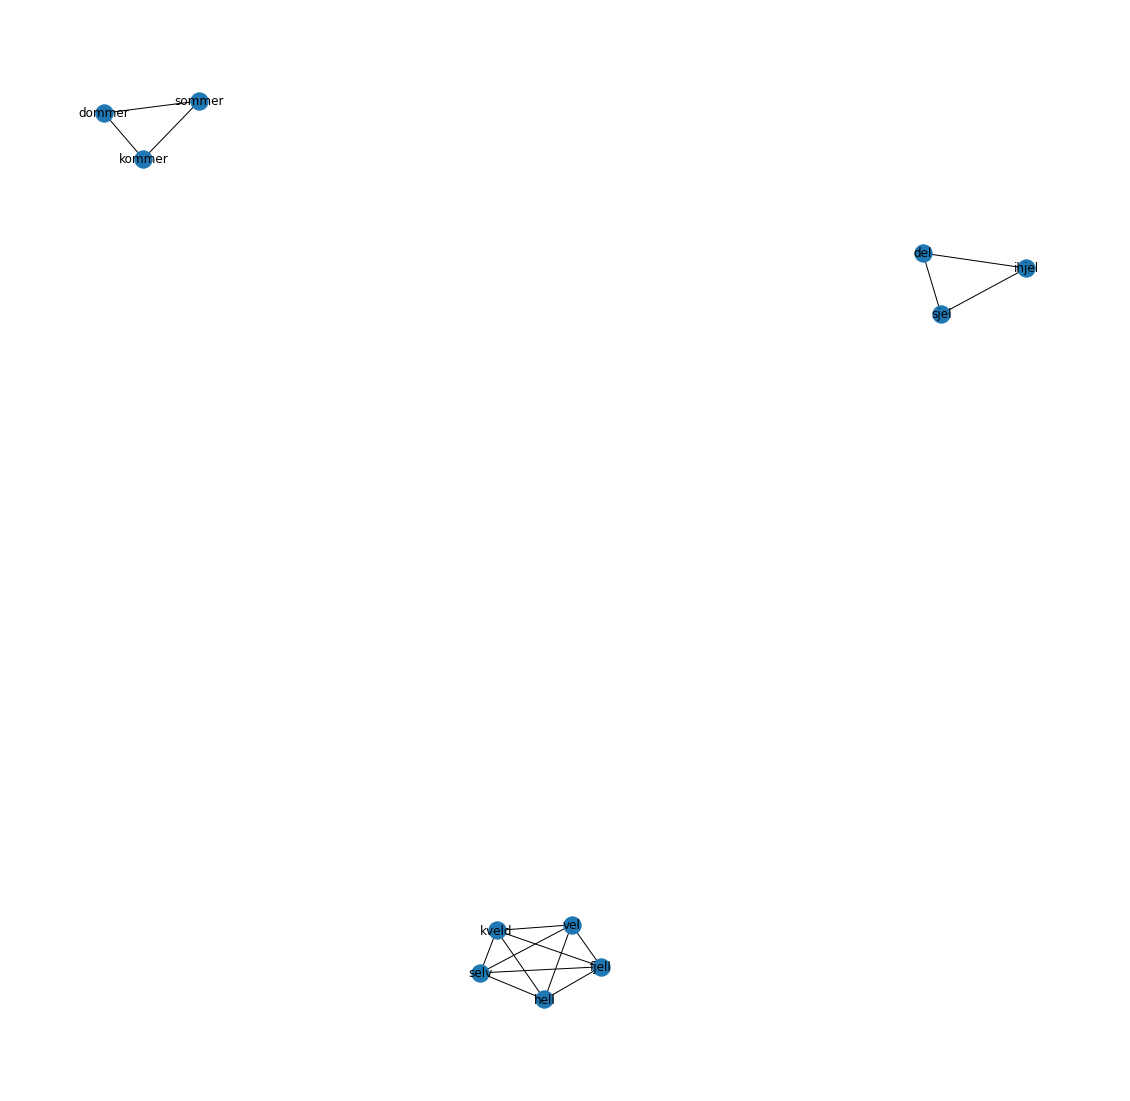

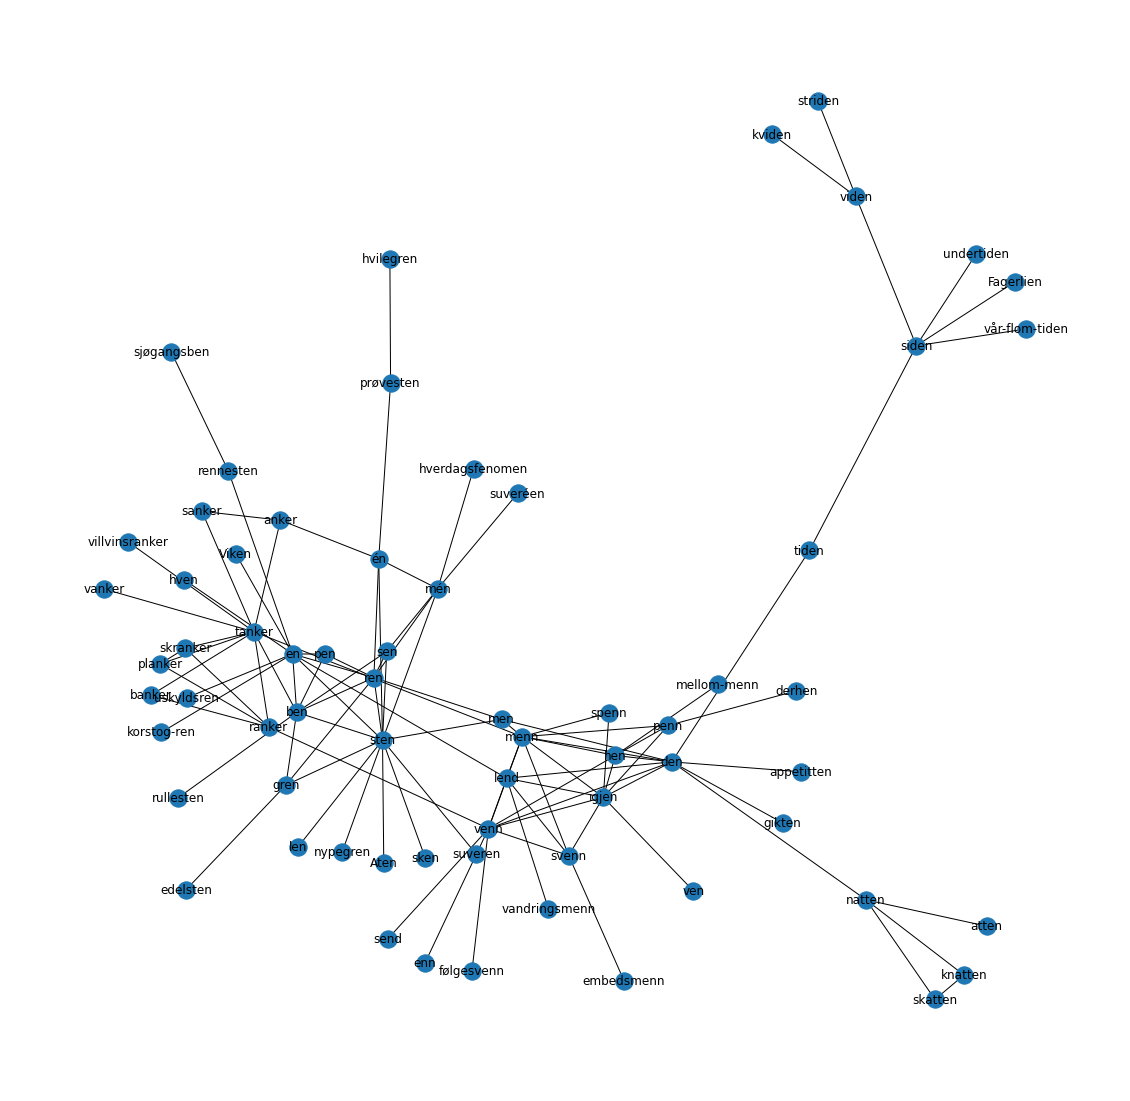

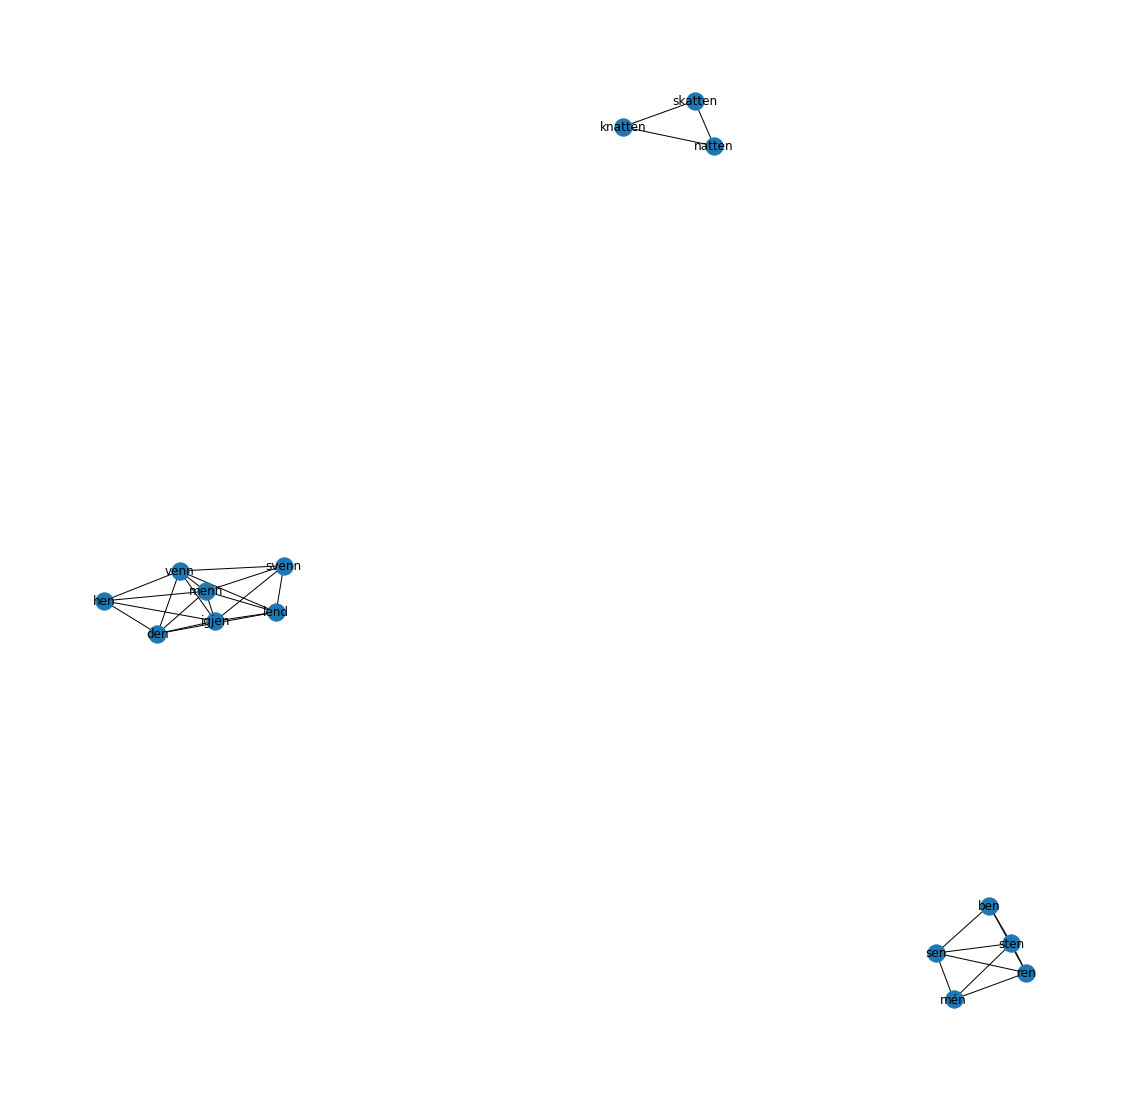

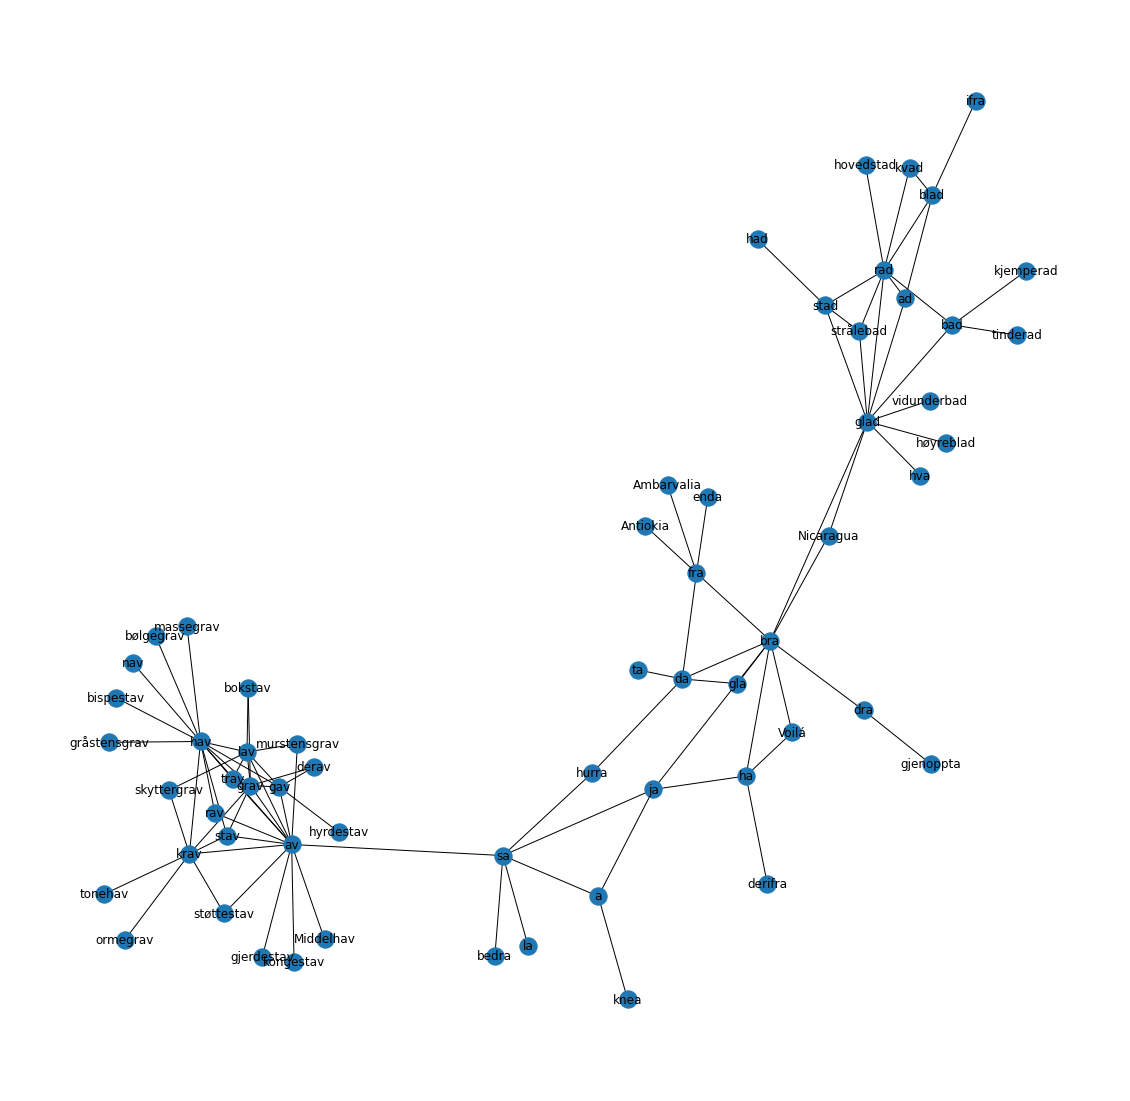

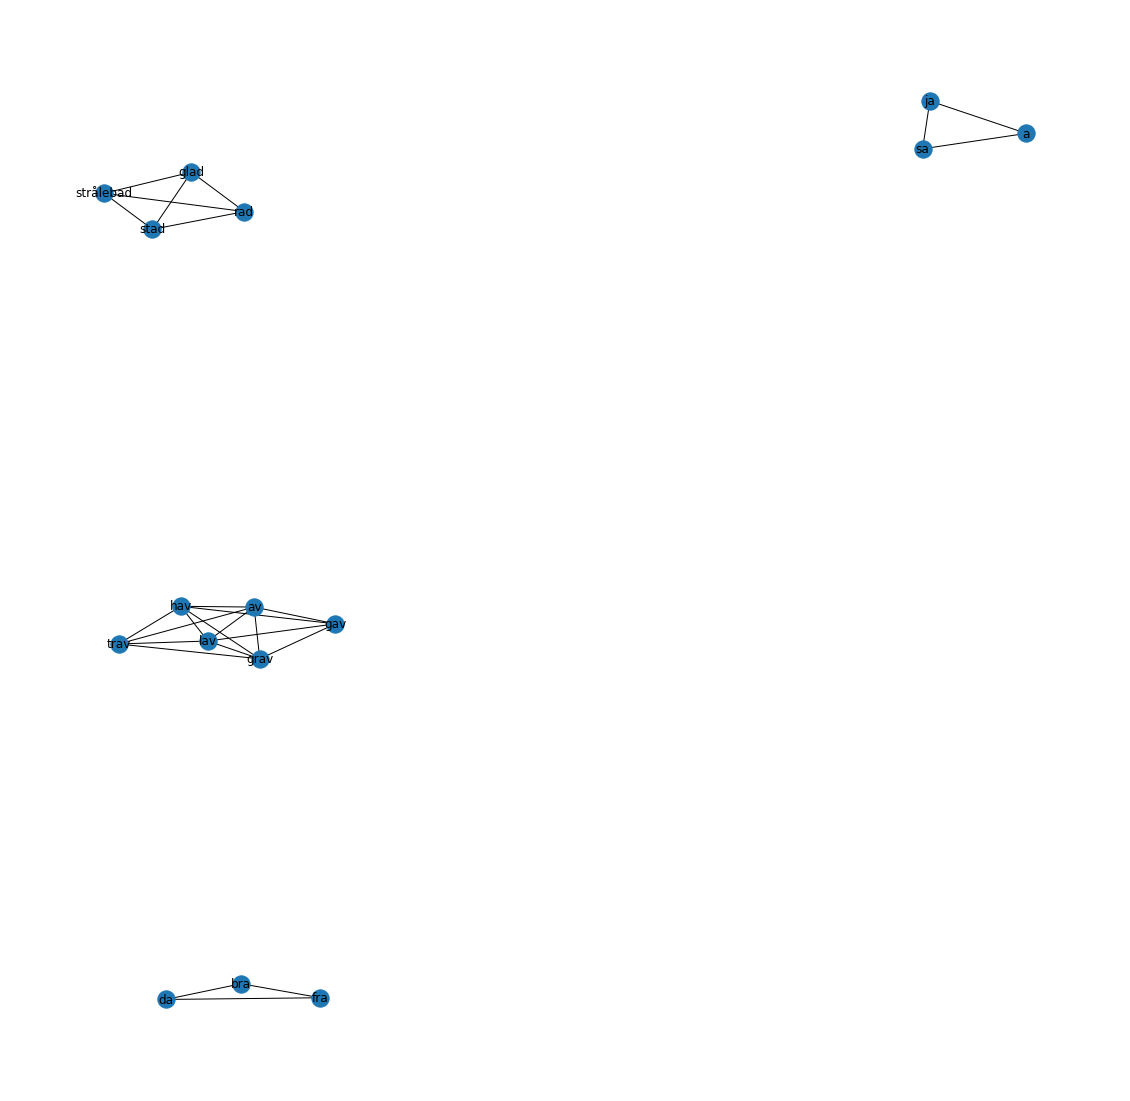

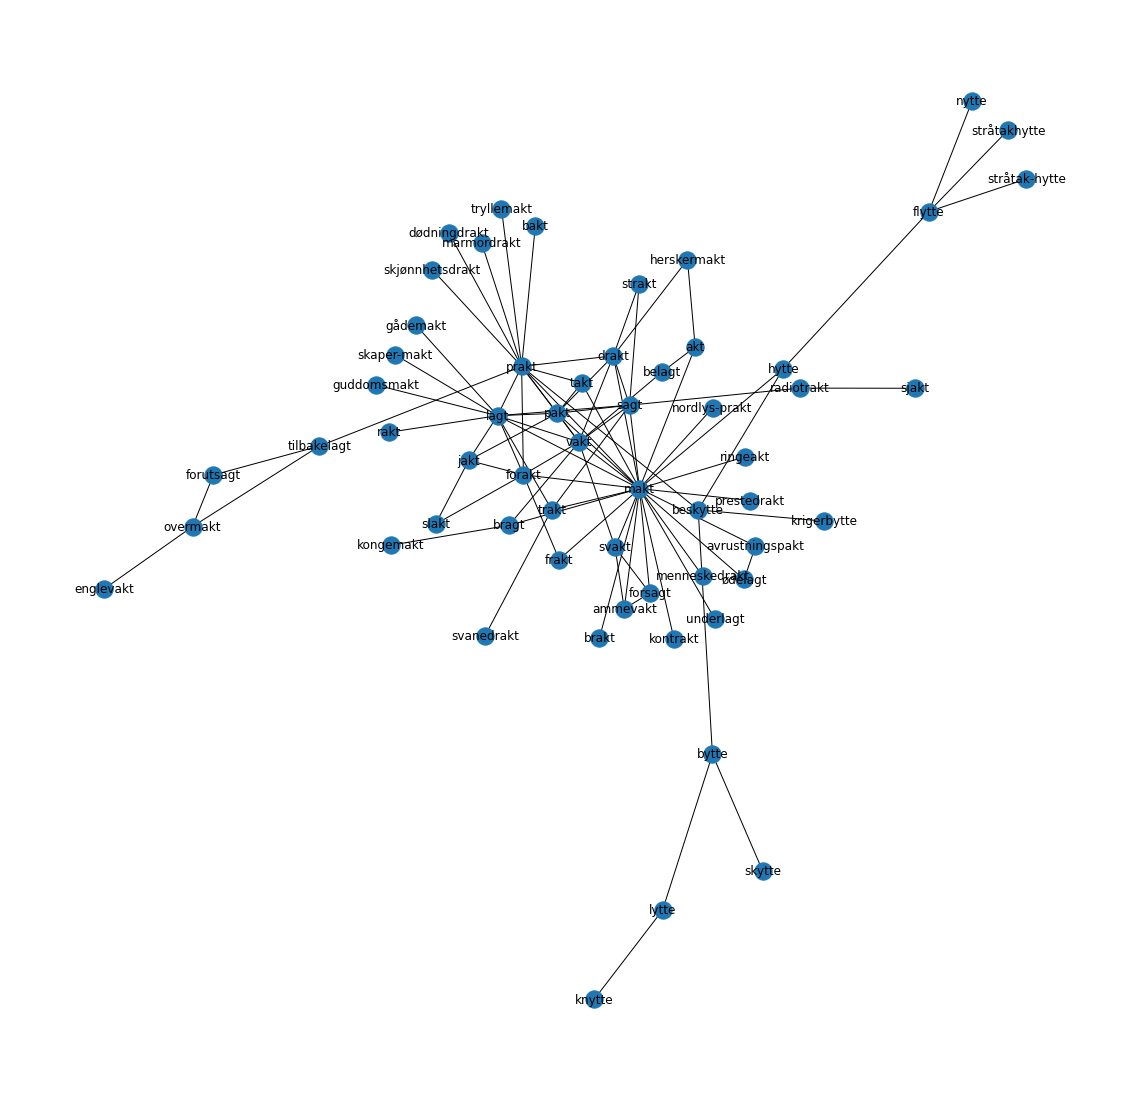

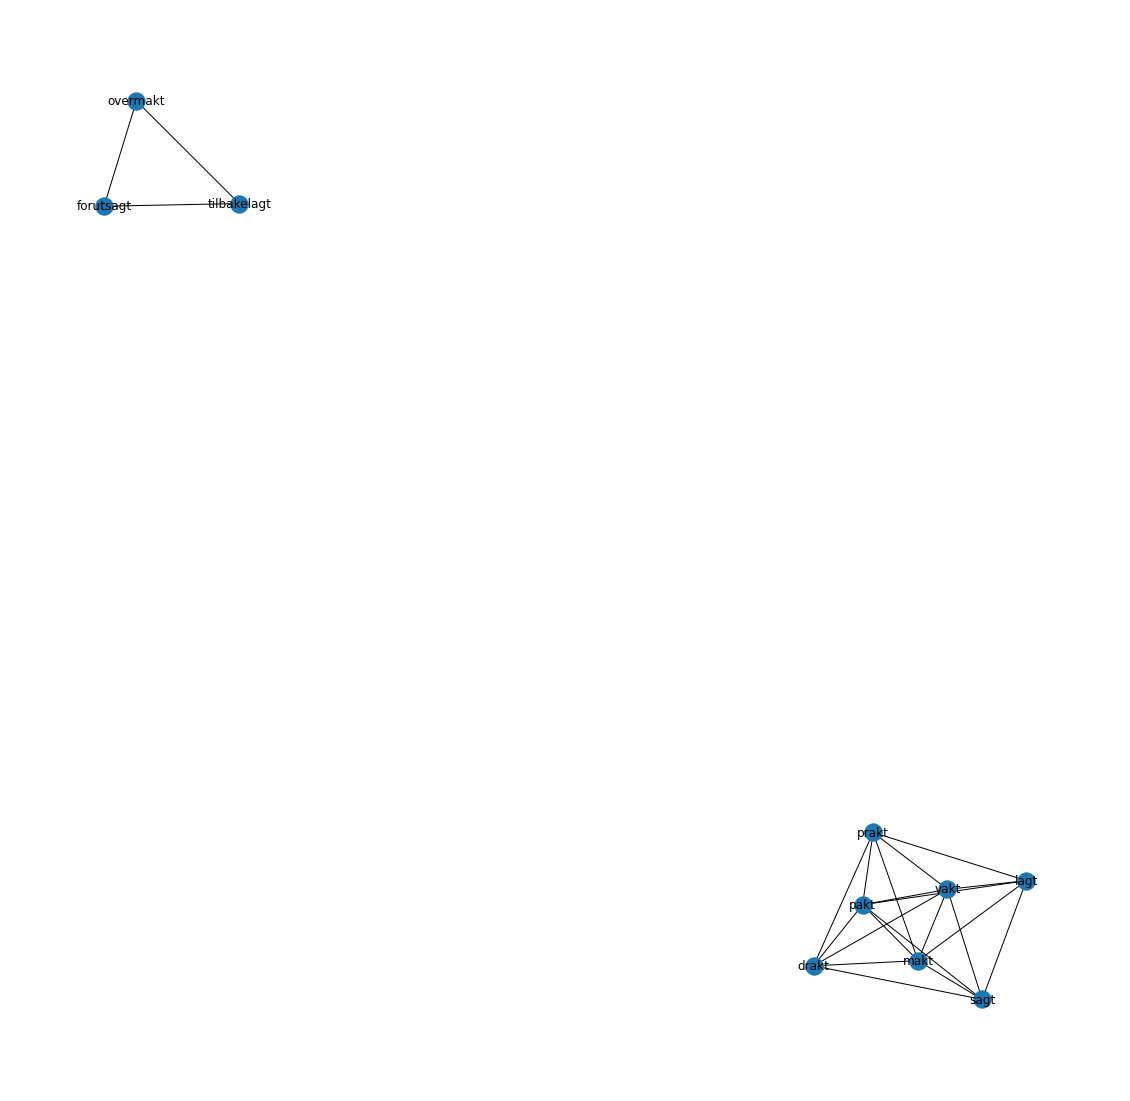

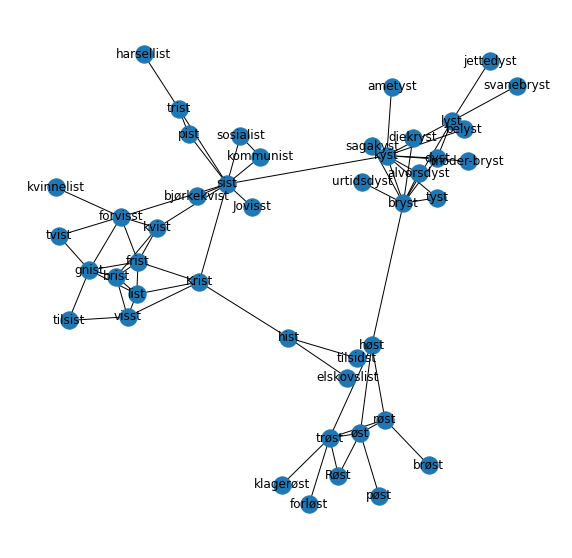

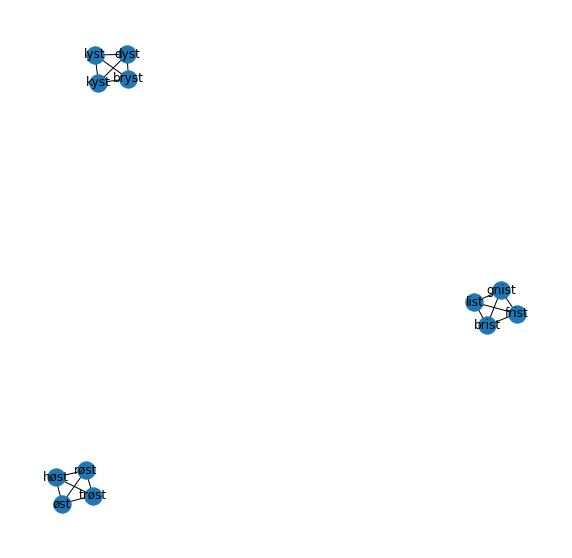

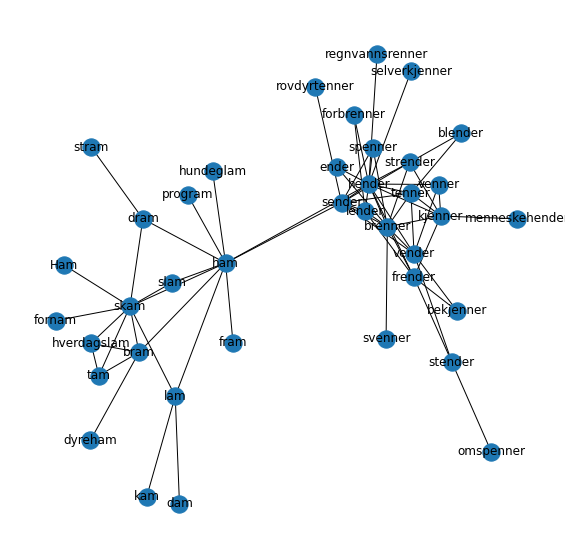

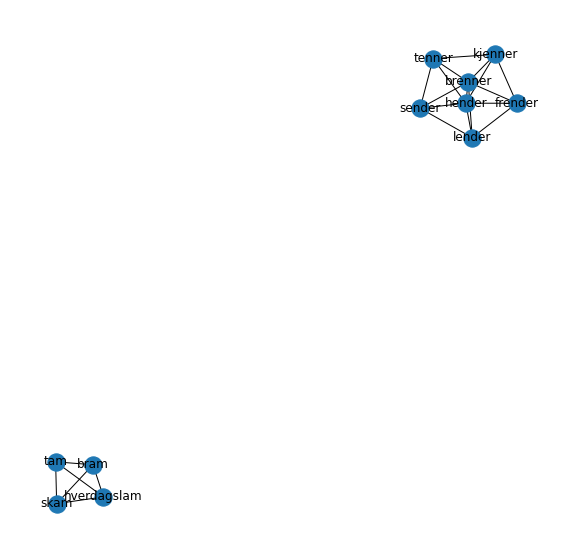

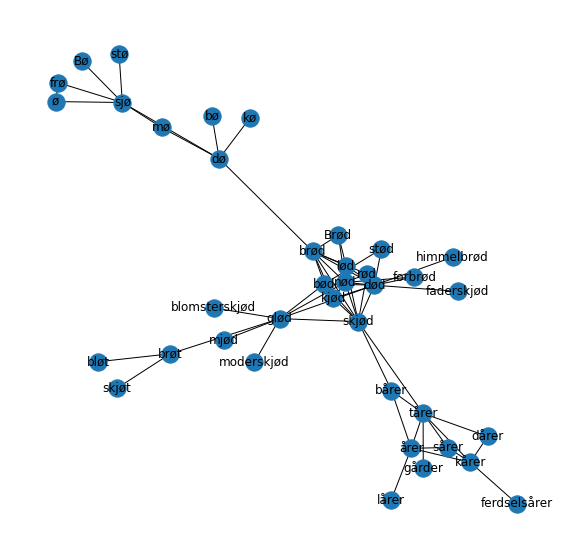

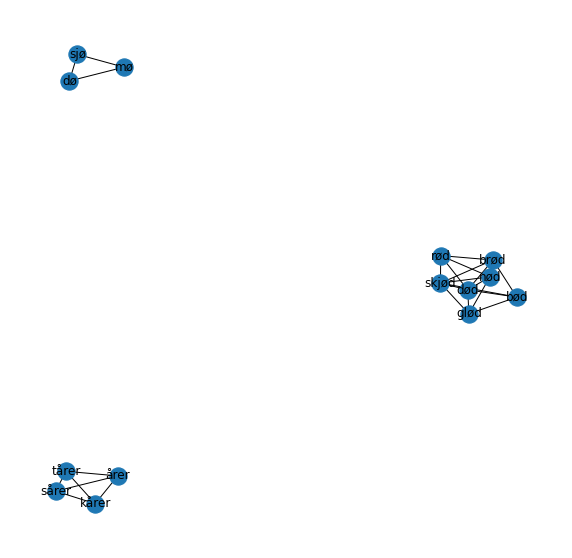

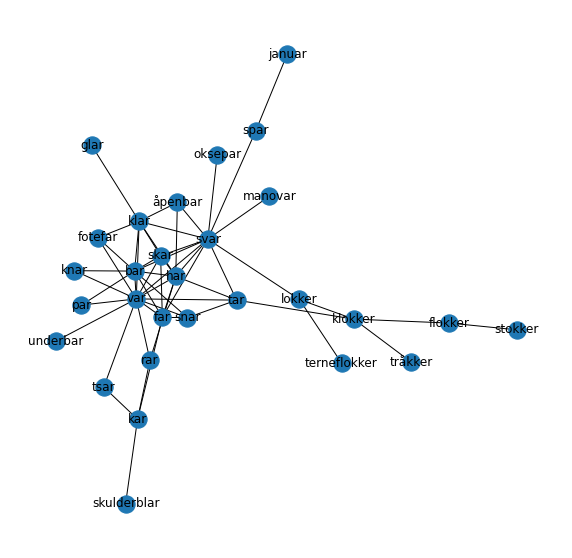

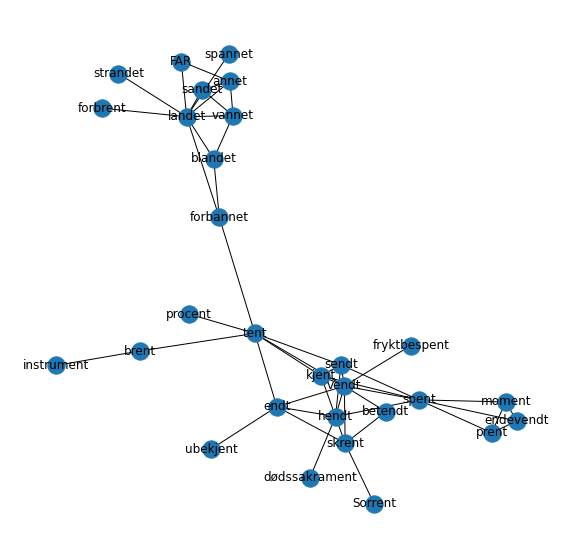

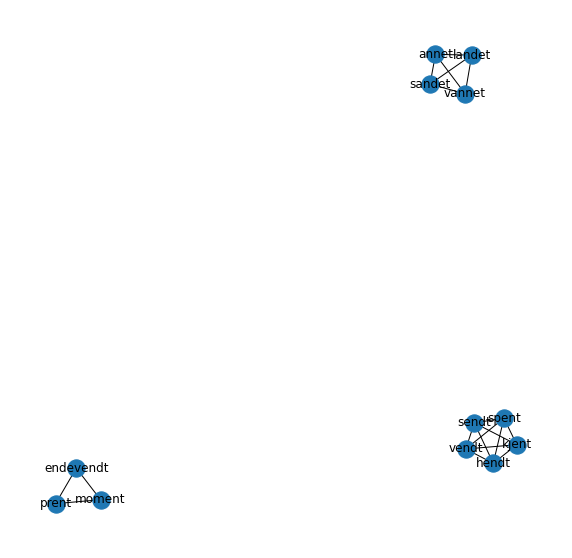

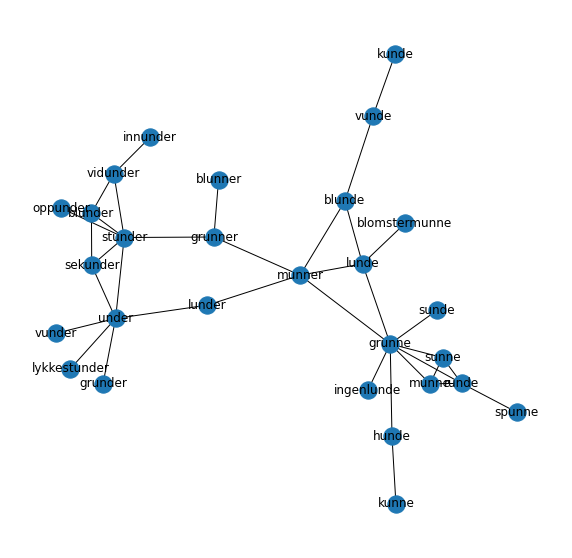

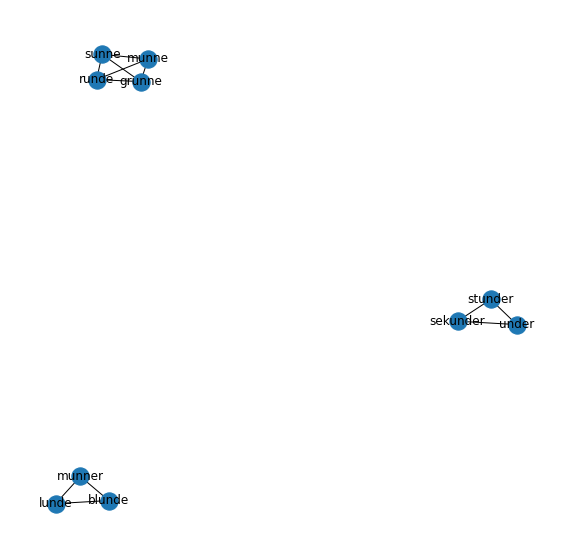

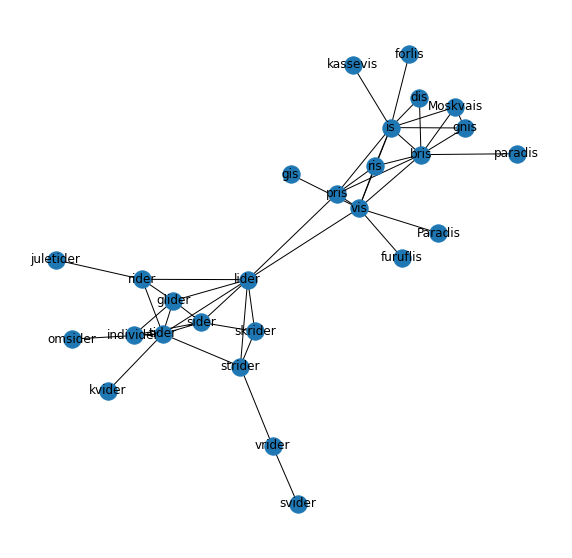

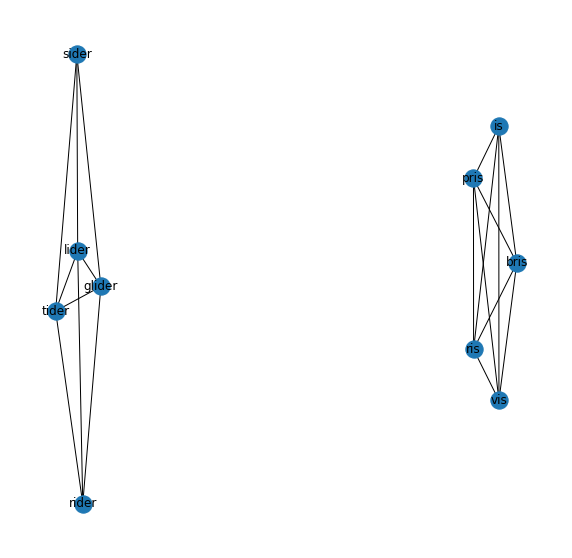

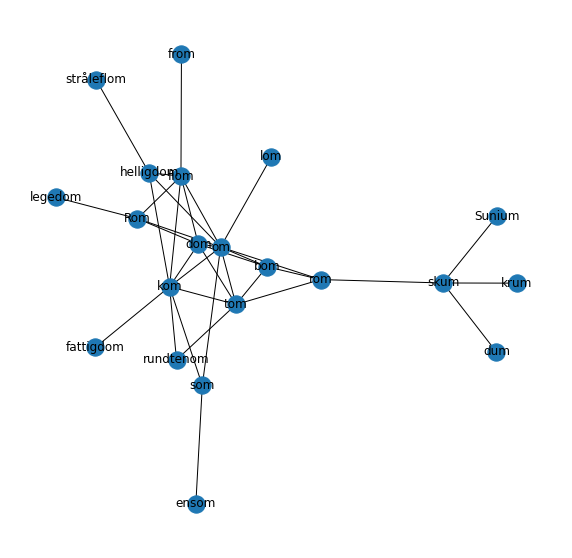

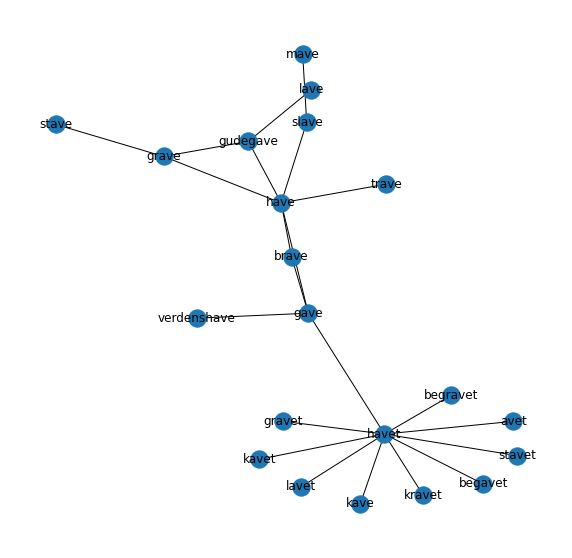

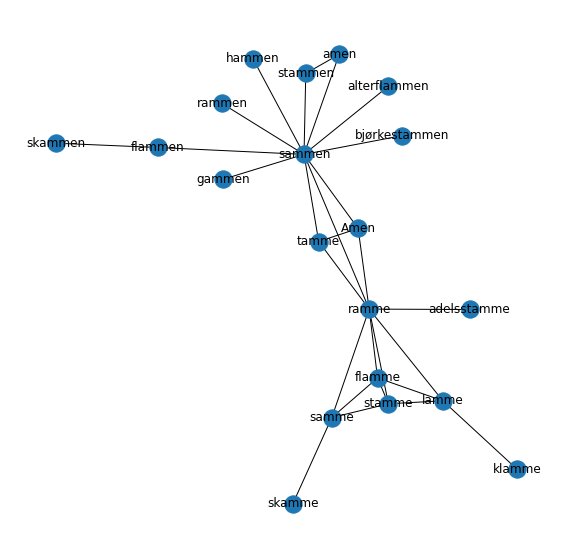

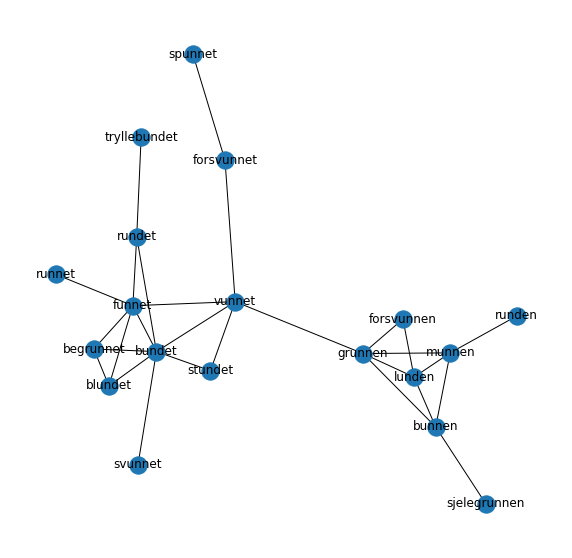

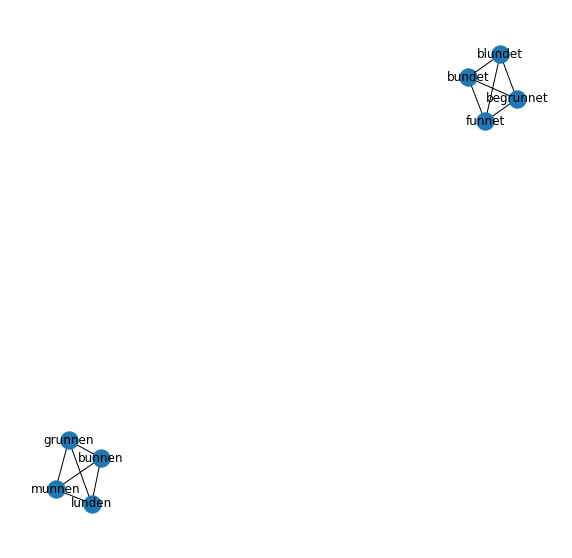

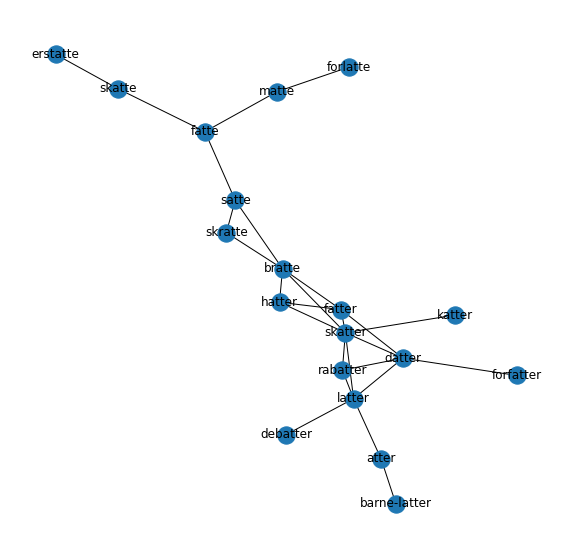

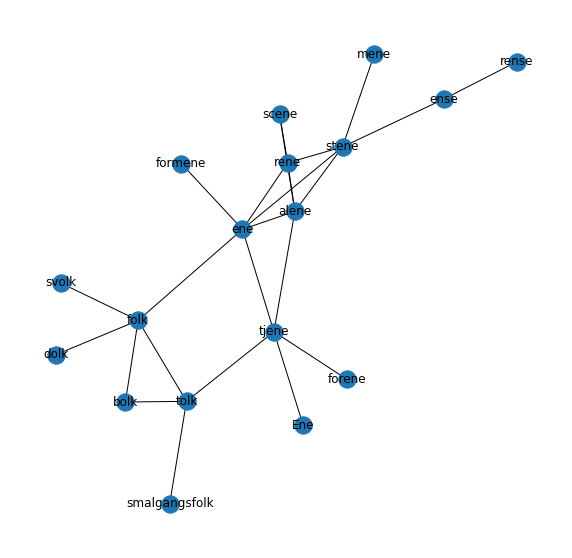

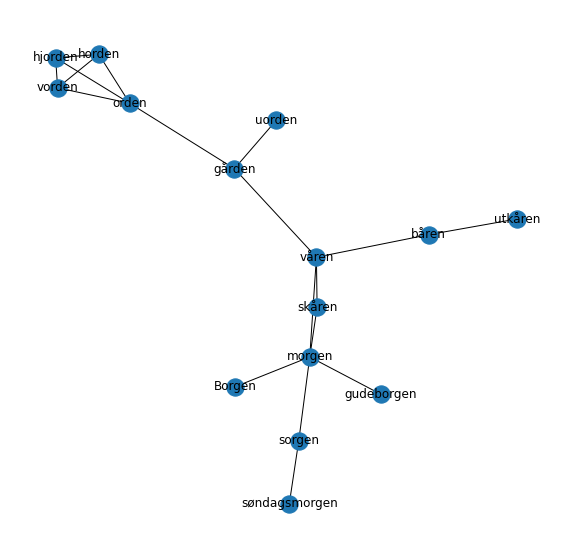

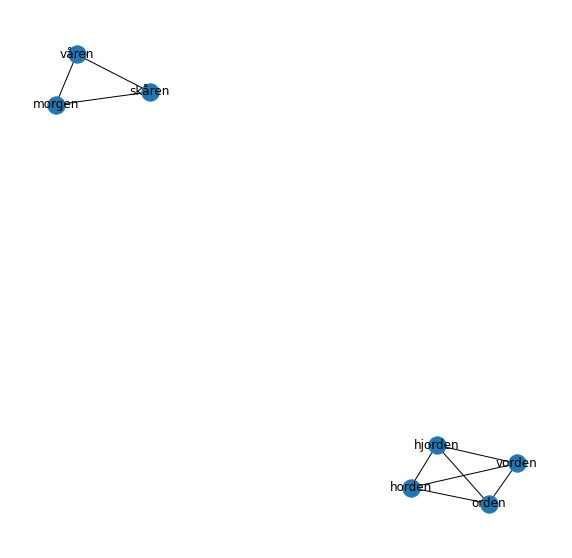

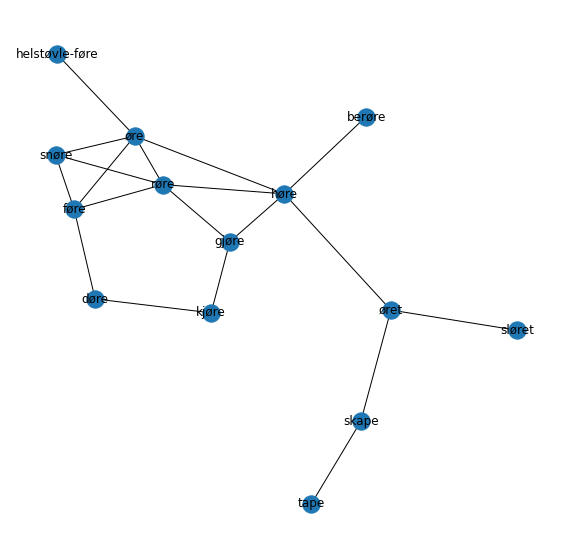

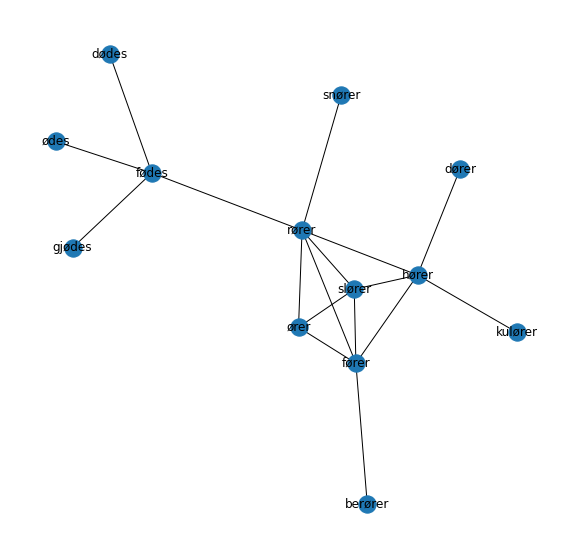

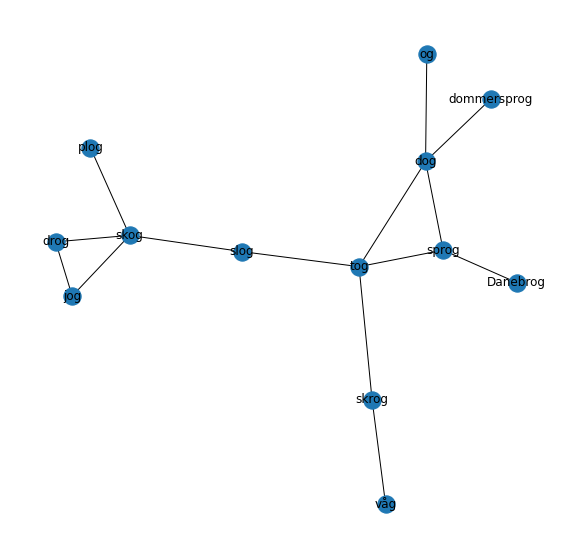

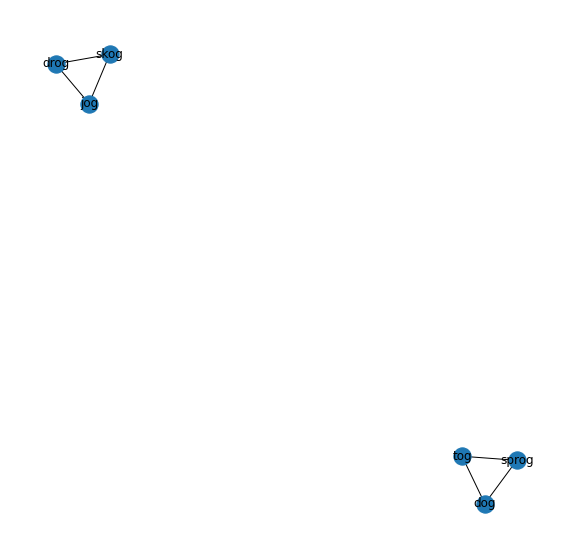

In [27]:
more_buckets = []
lost_words = 0
not_divided = 0

for i, (graph, cluster) in enumerate(zip(graphs, clusters)):
    size = len(graph.nodes)
    words_, buckets_ = get_buckets_and_lost_words(cluster)    
    f = get_fig(size)
    nx.draw(graph, ax=f.add_subplot(111), with_labels=True)
    f.savefig(f"figs/pre_clustering_graph_{i}.png")
    
    if len(buckets_) == 1:
        not_divided += 1
        continue

    f = get_fig(size)
    nx.draw(nx.restricted_view(cluster, edges=[], nodes=(words_)), ax=f.add_subplot(111),  with_labels=True)
    f.savefig(f"figs/post_clustering_graph_{i}.png")
    
    more_buckets += buckets_
    lost_words += len(words_)

In [28]:
len(more_buckets), not_divided

(62, 8)

In [29]:
tot_words = sum(len(bucket) for bucket in more_buckets)
print(f"""For the {len(more_buckets)} more buckets:
Total words: {tot_words}
% of vocab: {tot_words/len(vocab)*100}
Avg length: {tot_words/len(more_buckets)}
""")

For the 62 more buckets:
Total words: 308
% of vocab: 4.896661367249602
Avg length: 4.967741935483871



In [30]:
with open('hcs_rhyme_graph_buckets.pickle','wb') as f:
    pickle.dump(buckets, f)

with open('hcs_rhyme_graph_buckets.pickle','rb') as f:
    buckets = pickle.load(f)

In [31]:
more_vocab = sum([len(bucket) for bucket in more_buckets])

print(f"""
With the buckets we got from graph clustering we got
{len(more_buckets)} new buckets
Average size: {more_vocab/len(more_buckets)}
{more_vocab} words out of {len(vocab)} total
We lost {lost_words} vertices
Of the bad buckets, {not_divided} were not divided by HCS
""")



With the buckets we got from graph clustering we got
62 new buckets
Average size: 4.967741935483871
308 words out of 6290 total
We lost 1000 vertices
Of the bad buckets, 8 were not divided by HCS



## Create rhyme pairs from more_buckets

In [32]:
graph_pairs = set()

for bucket in more_buckets:
    c = list(itertools.combinations(bucket, 2))
    if c:
        rem = get_mirrored_dupes(c)
        c = set(c) - rem
        graph_pairs.update(c)
len(graph_pairs)

760

In [33]:
pairs1 = pairs.copy()
pairs1.update(graph_pairs)
len(pairs1)

24422

In [34]:
print(f"""
All combinations of the more_buckets give us {len(graph_pairs)} rhyme pairs.
Of these, {len(graph_pairs)- (len(pairs1)-len(pairs))} already existed in the pairs data set.
We increased the pair set by {len(pairs1)-len(pairs)}.
""")


All combinations of the more_buckets give us 760 rhyme pairs.
Of these, 321 already existed in the pairs data set.
We increased the pair set by 439.



In [35]:
words_a, words_b = zip(*pairs1)
pair_df = pd.DataFrame({"word_a" : words_a, "word_b": words_b, "rhyme": [1]*len(pairs1)})
pair_df.to_csv("hcs_plus_good_buckets_positive_pairs.tsv", sep="\t", index=False)

In [36]:
pair_df

word_a        word_b  rhyme
0        kvinner        finner      1
1            vil          vill      1
2      tordensky  solskinnsfly      1
3         Kviste         niste      1
4            kår           vår      1
...          ...           ...    ...
24417       ritt          litt      1
24418      brede       dernede      1
24419        seg           deg      1
24420  farveller        teller      1
24421      svang    underklang      1

[24422 rows x 3 columns]

## Manually remove bad edges

ord som den  
men/mén  
seg/seg  
brød dø, nød  
råd få, dåd  
morgen sorgen, våren  

In [37]:
manual_buckets = []

In [38]:
len(graphs)

26

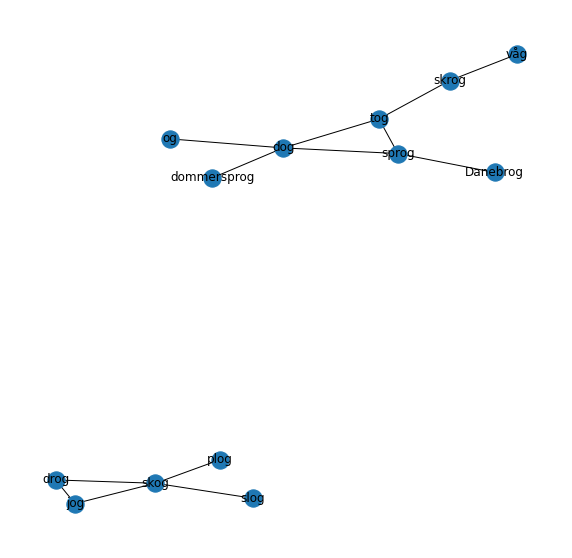

In [39]:
i = 25
g = graphs[i].copy()
size = len(g.nodes)

# f = get_fig(size)
# nx.draw(g, ax=f.add_subplot(111), with_labels=True)
# plt.show()

for e in [("tog", "slog")]:
    g.remove_edge(*e)

f = get_fig(size)
nx.draw(g, ax=f.add_subplot(111), with_labels=True)
f.savefig(f"figs/manual_repair_{i}.png")

manual_buckets += list(nx.connected_components(g))

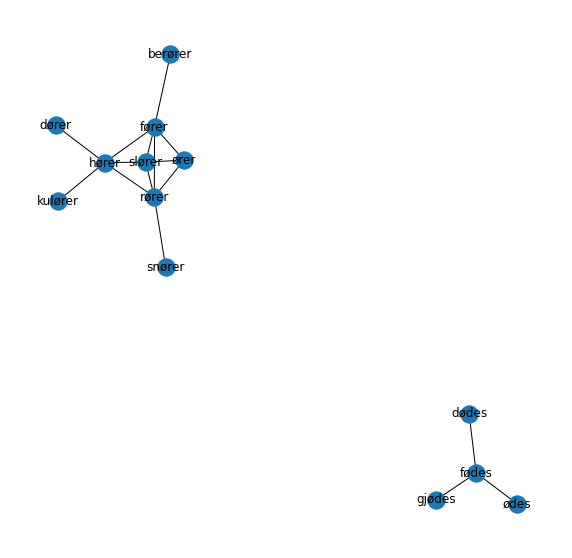

In [40]:
i = 24
g = graphs[i].copy()
size = len(g.nodes)

# f = get_fig(size)

# nx.draw(g, ax=f.add_subplot(111), with_labels=True)
# plt.show()

for e in [("rører", "fødes")]:
    g.remove_edge(*e)

f = get_fig(size)

nx.draw(g, ax=f.add_subplot(111), with_labels=True)
f.savefig(f"figs/manual_repair_{i}.png")

manual_buckets += list(nx.connected_components(g))

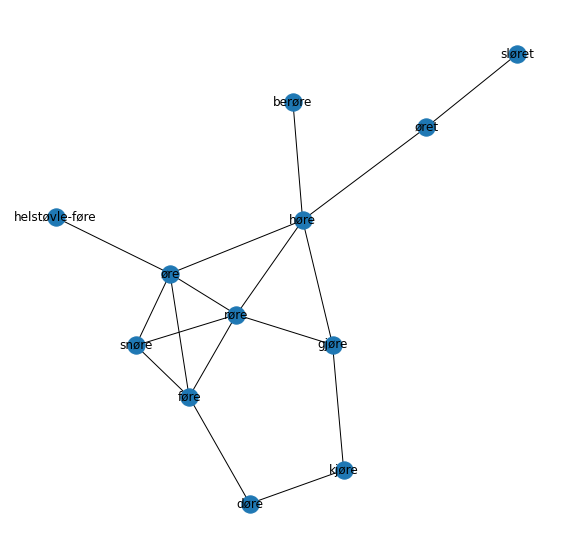

In [41]:
i = 23
g = graphs[i].copy()
size = len(g.nodes)

# f = get_fig(size)

# nx.draw(g, ax=f.add_subplot(111), with_labels=True)
# plt.show()

for e in ["skape", "tape"]:
    g.remove_node(e)
    
f = get_fig(size)

nx.draw(g, ax=f.add_subplot(111), with_labels=True)
f.savefig(f"figs/manual_repair_{i}.png")

manual_buckets += list(nx.connected_components(g))

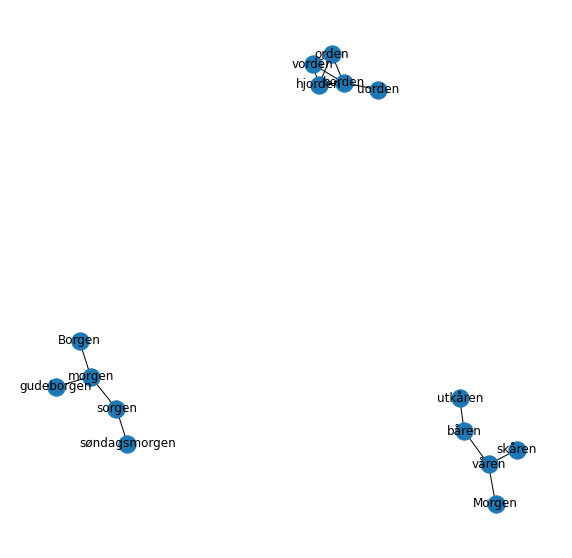

In [42]:
i = 22
g = graphs[i].copy()
size = len(g.nodes)

# f = get_fig(size)

# nx.draw(g, ax=f.add_subplot(111), with_labels=True)
# plt.show()

g.remove_node("gården")

for e in [("morgen", "våren"), ("morgen", "skåren")]:
    g.remove_edge(*e)

g.add_edge("Morgen", "våren")

g.add_edge("uorden", "horden")
    
f = get_fig(size)

nx.draw(g, ax=f.add_subplot(111), with_labels=True)

f.savefig(f"figs/manual_repair_{i}.png")

manual_buckets += list(nx.connected_components(g))

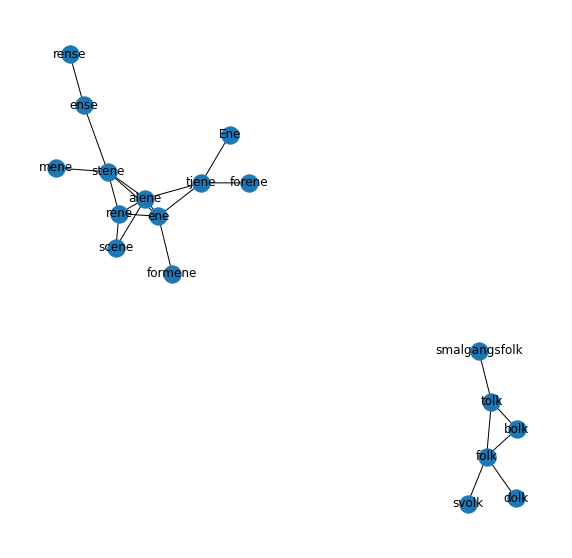

In [43]:
i = 21
g = graphs[i].copy()
size = len(g.nodes)

# f = get_fig(size)

# nx.draw(g, ax=f.add_subplot(111), with_labels=True)
# plt.show()


for e in [("tolk", "tjene"), ("folk", "ene")]:
    g.remove_edge(*e)
    
f = get_fig(size)

nx.draw(g, ax=f.add_subplot(111), with_labels=True)
f.savefig(f"figs/manual_repair_{i}.png")

manual_buckets += list(nx.connected_components(g))

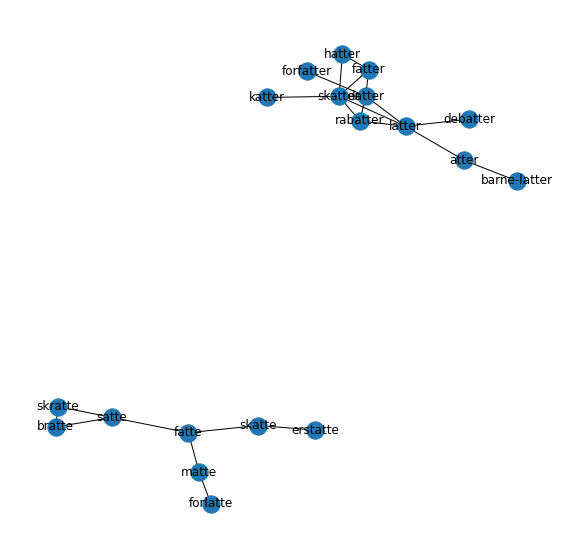

In [44]:
i = 20
g = graphs[i].copy()
size = len(g.nodes)

# f = get_fig(size)

# nx.draw(g, ax=f.add_subplot(111), with_labels=True)
# plt.show()


for e in [("bratte", "hatter"), ("bratte", "fatter"), ("bratte", "skatter")]:
    g.remove_edge(*e)

f = get_fig(size)

nx.draw(g, ax=f.add_subplot(111), with_labels=True)
f.savefig(f"figs/manual_repair_{i}.png")

manual_buckets += list(nx.connected_components(g))

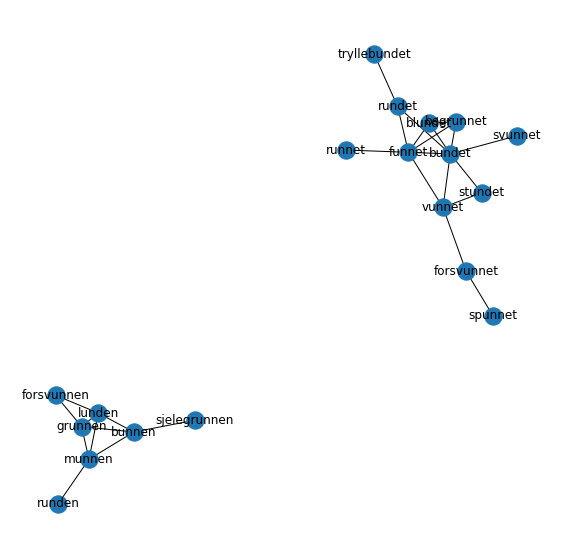

In [45]:
i = 19
g = graphs[i].copy()
size = len(g.nodes)

# f = get_fig(size)

# nx.draw(g, ax=f.add_subplot(111), with_labels=True)
# plt.show()


for e in [("vunnet", "grunnen")]:
    g.remove_edge(*e)
    
f = get_fig(size)

nx.draw(g, ax=f.add_subplot(111), with_labels=True)
f.savefig(f"figs/manual_repair_{i}.png")

manual_buckets += list(nx.connected_components(g))

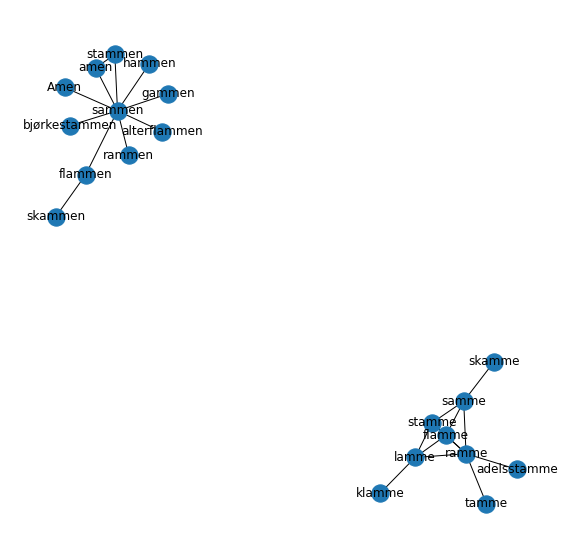

In [46]:
i = 18
g = graphs[i].copy()
size = len(g.nodes)

# f = get_fig(size)

# nx.draw(g, ax=f.add_subplot(111), with_labels=True)
# plt.show()

for e in [("Amen", "ramme"), ("sammen", "tamme"), ("sammen", "ramme"), ("tamme", "Amen")]:
    g.remove_edge(*e)

f = get_fig(size)

nx.draw(g, ax=f.add_subplot(111), with_labels=True)
f.savefig(f"figs/manual_repair_{i}.png")

manual_buckets += list(nx.connected_components(g))

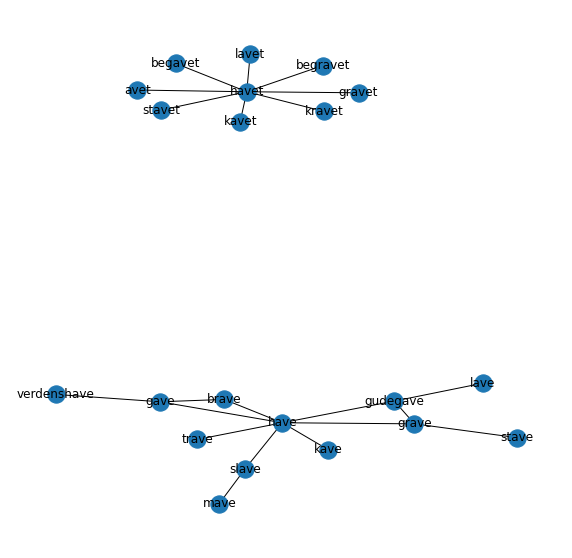

In [47]:
i = 17
g = graphs[i].copy()
size = len(g.nodes)

# f = get_fig(size)

# nx.draw(g, ax=f.add_subplot(111), with_labels=True)
# plt.show()



for e in [("gave", "havet"), ("kave", "havet")]:
    g.remove_edge(*e)
    
g.add_edge("kave", "have")
    
f = get_fig(size)

nx.draw(g, ax=f.add_subplot(111), with_labels=True)
f.savefig(f"figs/manual_repair_{i}.png")

manual_buckets += list(nx.connected_components(g))

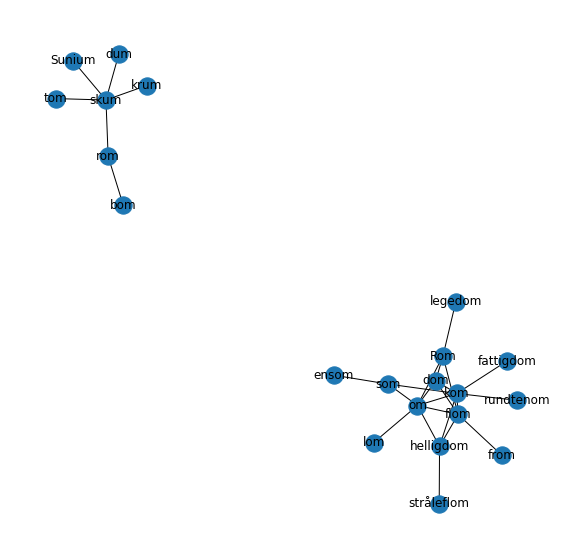

In [48]:
i = 16
g = graphs[i].copy()
size = len(g.nodes)

# f = get_fig(size)

# nx.draw(g, ax=f.add_subplot(111), with_labels=True)
# plt.show()

for e in [("bom", "dom"), ("rom", "om"), ("bom", "om")]:
    g.remove_edge(*e)
    
g.remove_node("tom")
g.add_edge("tom", "skum")
    
f = get_fig(size)

nx.draw(g, ax=f.add_subplot(111), with_labels=True)
f.savefig(f"figs/manual_repair_{i}.png")

manual_buckets += list(nx.connected_components(g))

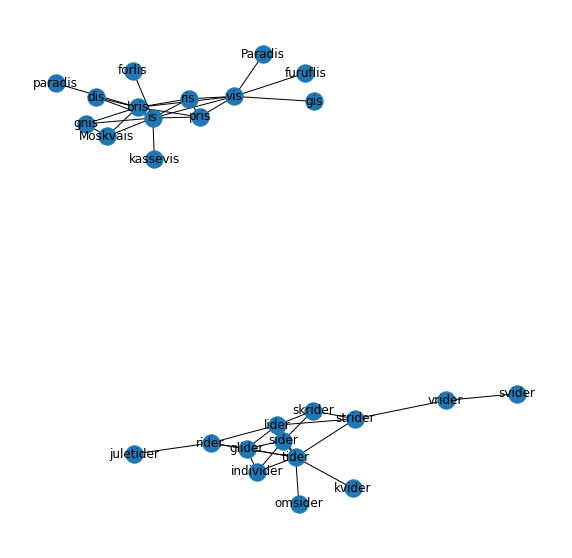

In [49]:
i = 15
g = graphs[i].copy()
size = len(g.nodes)

# f = get_fig(size)

# nx.draw(g, ax=f.add_subplot(111), with_labels=True)
# plt.show()

for e in [("pris", "lider"), ("vis", "lider")]:
    g.remove_edge(*e)
    
f = get_fig(size)
    
nx.draw(g, ax=f.add_subplot(111), with_labels=True)
f.savefig(f"figs/manual_repair_{i}.png")

manual_buckets += list(nx.connected_components(g))

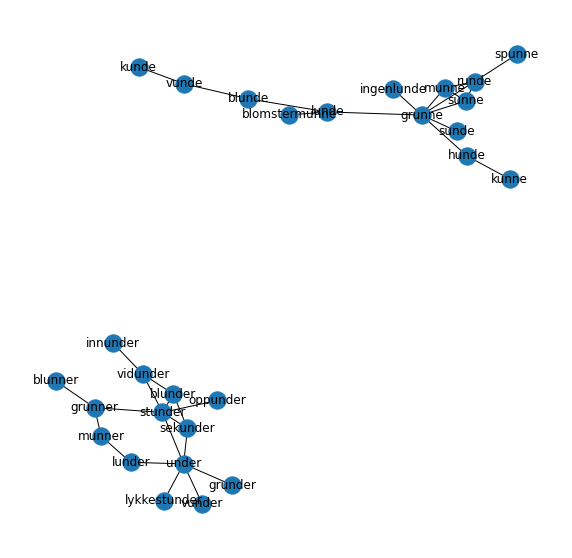

In [50]:
i = 14
g = graphs[i].copy()
size = len(g.nodes)

# f = get_fig(size)

# nx.draw(g, ax=f.add_subplot(111), with_labels=True)
# plt.show()

for e in [("munner", "grunne"), ("munner", "lunde"), ("munner", "blunde")]:
    g.remove_edge(*e)

f = get_fig(size)

nx.draw(g, ax=f.add_subplot(111), with_labels=True)
f.savefig(f"figs/manual_repair_{i}.png")

manual_buckets += list(nx.connected_components(g))

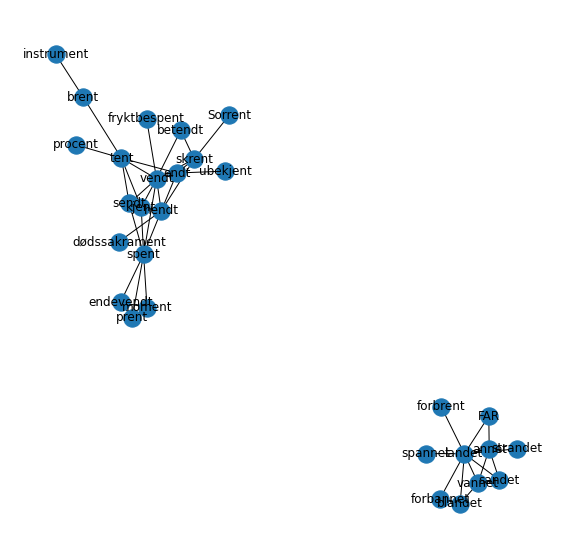

In [51]:
i = 13
g = graphs[i].copy()
size = len(g.nodes)

# f = get_fig(size)

# nx.draw(g, ax=f.add_subplot(111), with_labels=True)
# plt.show()

for e in [("forbannet", "tent")]:
    g.remove_edge(*e)
    
f = get_fig(size)
    
nx.draw(g, ax=f.add_subplot(111), with_labels=True)
f.savefig(f"figs/manual_repair_{i}.png")

manual_buckets += list(nx.connected_components(g))

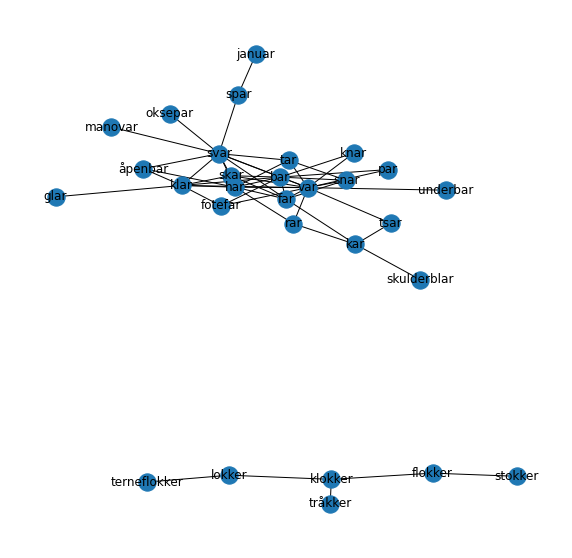

In [52]:
i = 12
g = graphs[i].copy()
size = len(g.nodes)

# f = get_fig(size)

# nx.draw(g, ax=f.add_subplot(111), with_labels=True)
# plt.show()

for e in [("klokker", "tar"), ("lokker", "svar")] :
    g.remove_edge(*e)
    
f = get_fig(size)
    
nx.draw(g, ax=f.add_subplot(111), with_labels=True)
f.savefig(f"figs/manual_repair_{i}.png")

manual_buckets += list(nx.connected_components(g))

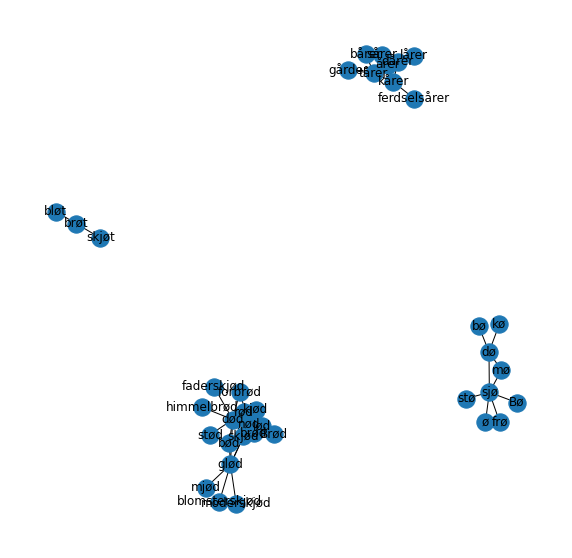

In [53]:
i = 11
g = graphs[i].copy()
size = len(g.nodes)

# f = get_fig(size)

# nx.draw(g, ax=f.add_subplot(111), with_labels=True)
# plt.show()

for e in [("skjød", "bårer"), ("skjød", "tårer"), ("glød", "brøt"), ("brød", "dø")]:
    g.remove_edge(*e)

f = get_fig(size)

nx.draw(g, ax=f.add_subplot(111), with_labels=True)
f.savefig(f"figs/manual_repair_{i}.png")

manual_buckets += list(nx.connected_components(g))

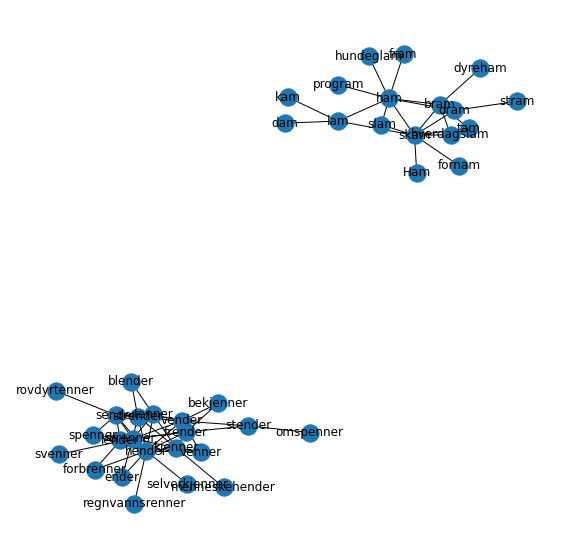

In [54]:
i = 10
g = graphs[i].copy()
size = len(g.nodes)

# f = get_fig(size)

# nx.draw(g, ax=f.add_subplot(111), with_labels=True)
# plt.show()


for e in [("ham", "sender"), ("ham", "hender")]:
    g.remove_edge(*e)

f = get_fig(size)

nx.draw(g, ax=f.add_subplot(111), with_labels=True)
f.savefig(f"figs/manual_repair_{i}.png")

manual_buckets += list(nx.connected_components(g))

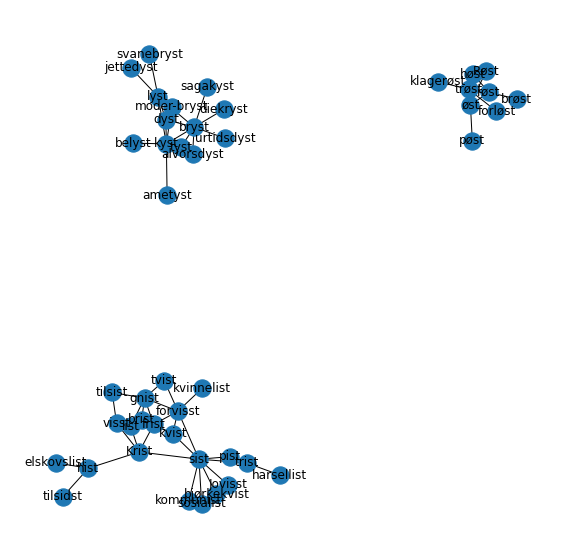

In [55]:
i = 9
g = graphs[i].copy()
size = len(g.nodes)

# f = get_fig(size)

# nx.draw(g, ax=f.add_subplot(111), with_labels=True)
# plt.show()


for e in  [("sist", "kyst"), ("bryst", "høst")]:
    g.remove_edge(*e)

f = get_fig(size)

nx.draw(g, ax=f.add_subplot(111), with_labels=True)
f.savefig(f"figs/manual_repair_{i}.png")

manual_buckets += list(nx.connected_components(g))

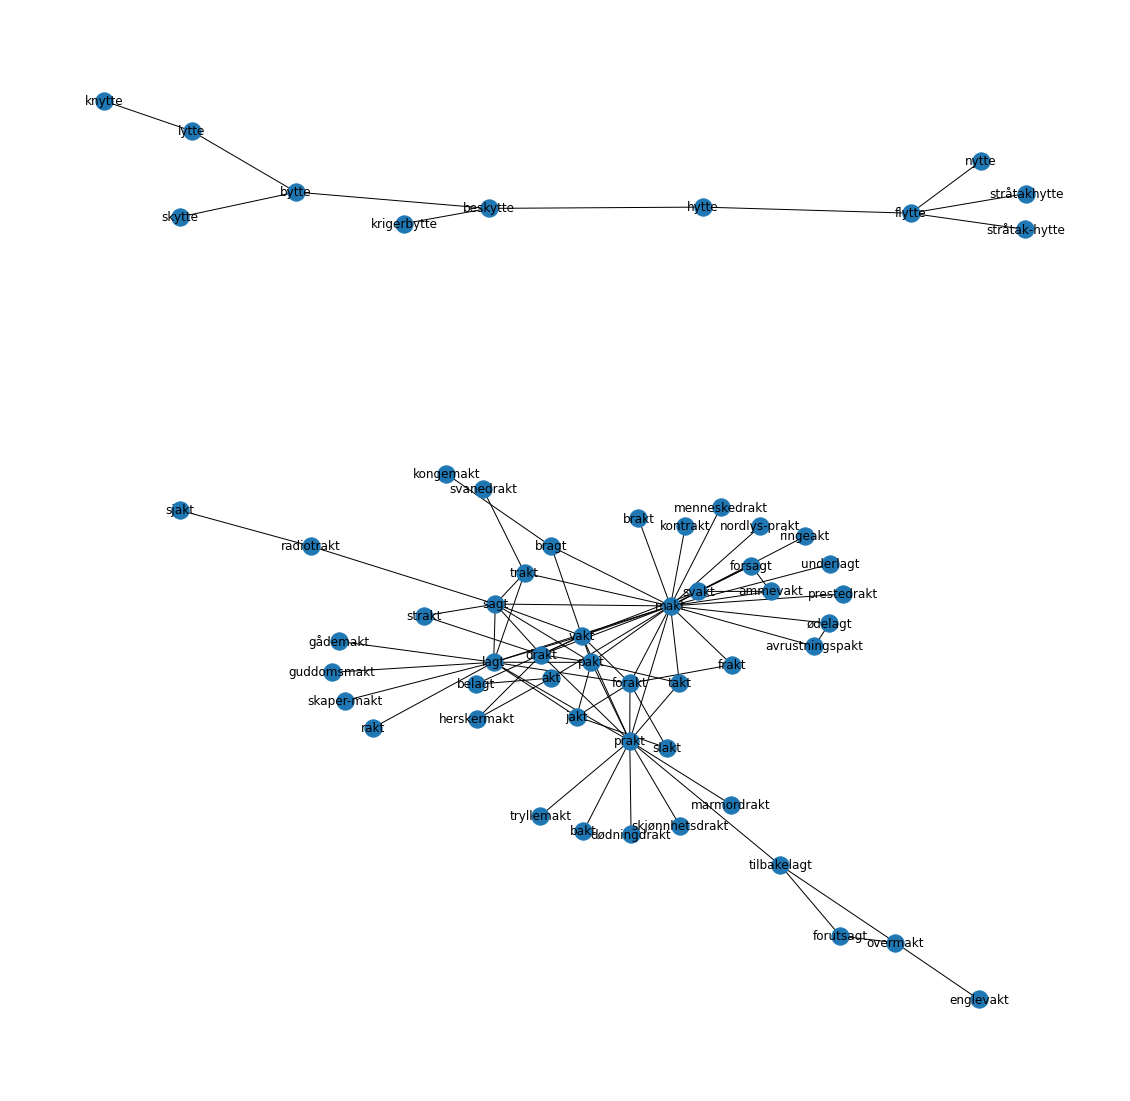

In [56]:
i = 8
g = graphs[i].copy()
size = len(g.nodes)

# f = get_fig(size)

# nx.draw(g, ax=f.add_subplot(111), with_labels=True)
# plt.show()

for e in [("hytte", "makt"), ("beskytte", "prakt")]:
    g.remove_edge(*e)

f = get_fig(size)

nx.draw(g, ax=f.add_subplot(111), with_labels=True)
f.savefig(f"figs/manual_repair_{i}.png")

manual_buckets += list(nx.connected_components(g))

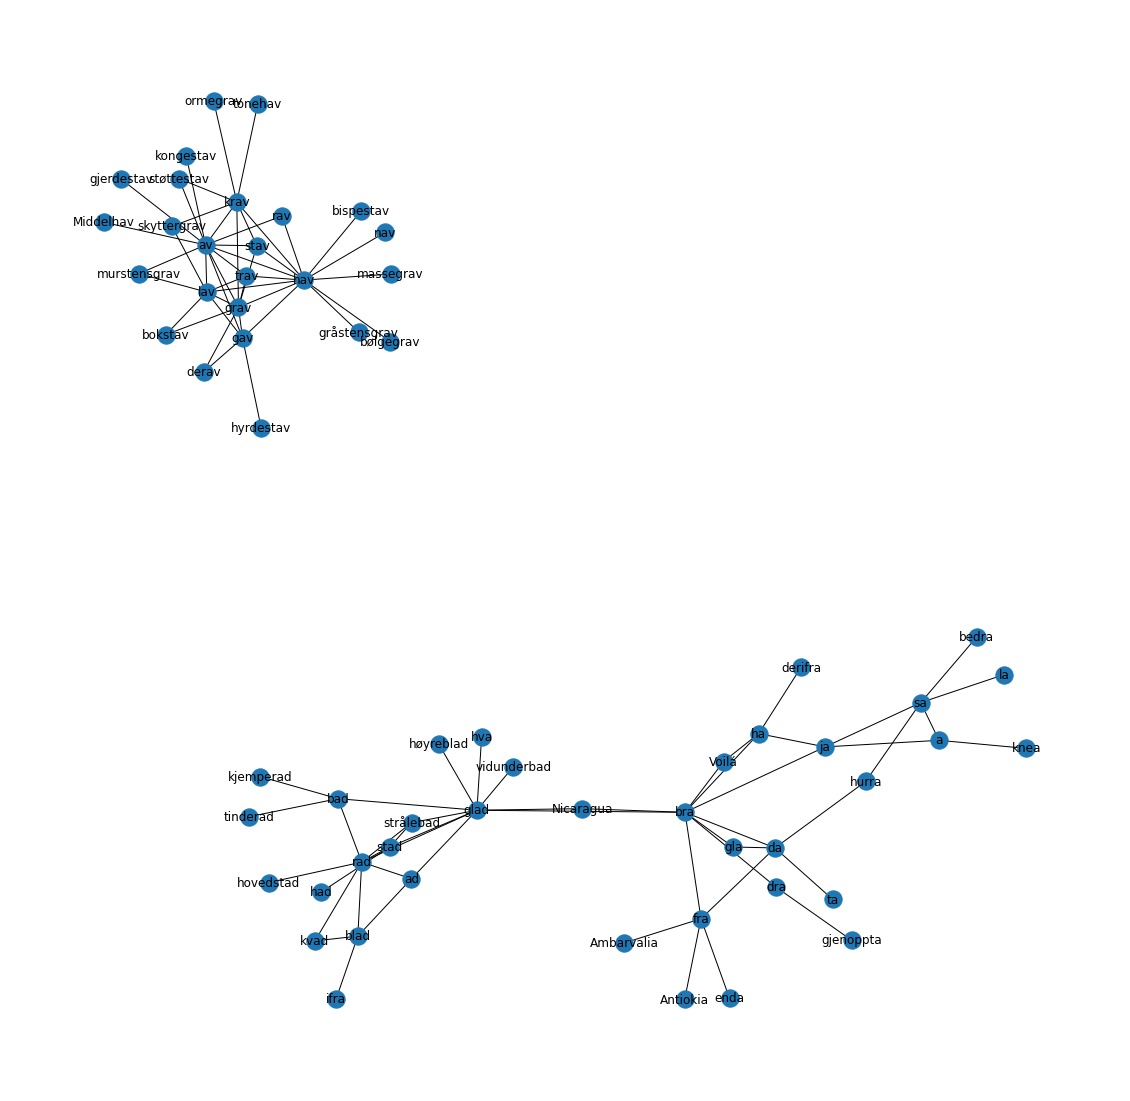

In [57]:
i = 7
g = graphs[i].copy()
size = len(g.nodes)

# f = get_fig(size)

# nx.draw(g, ax=f.add_subplot(111), with_labels=True)
# plt.show()

for e in [("sa", "av")]:
    g.remove_edge(*e)
    
f = get_fig(size)
nx.draw(g, ax=f.add_subplot(111), with_labels=True)
f.savefig(f"figs/manual_repair_{i}.png")

manual_buckets += list(nx.connected_components(g))


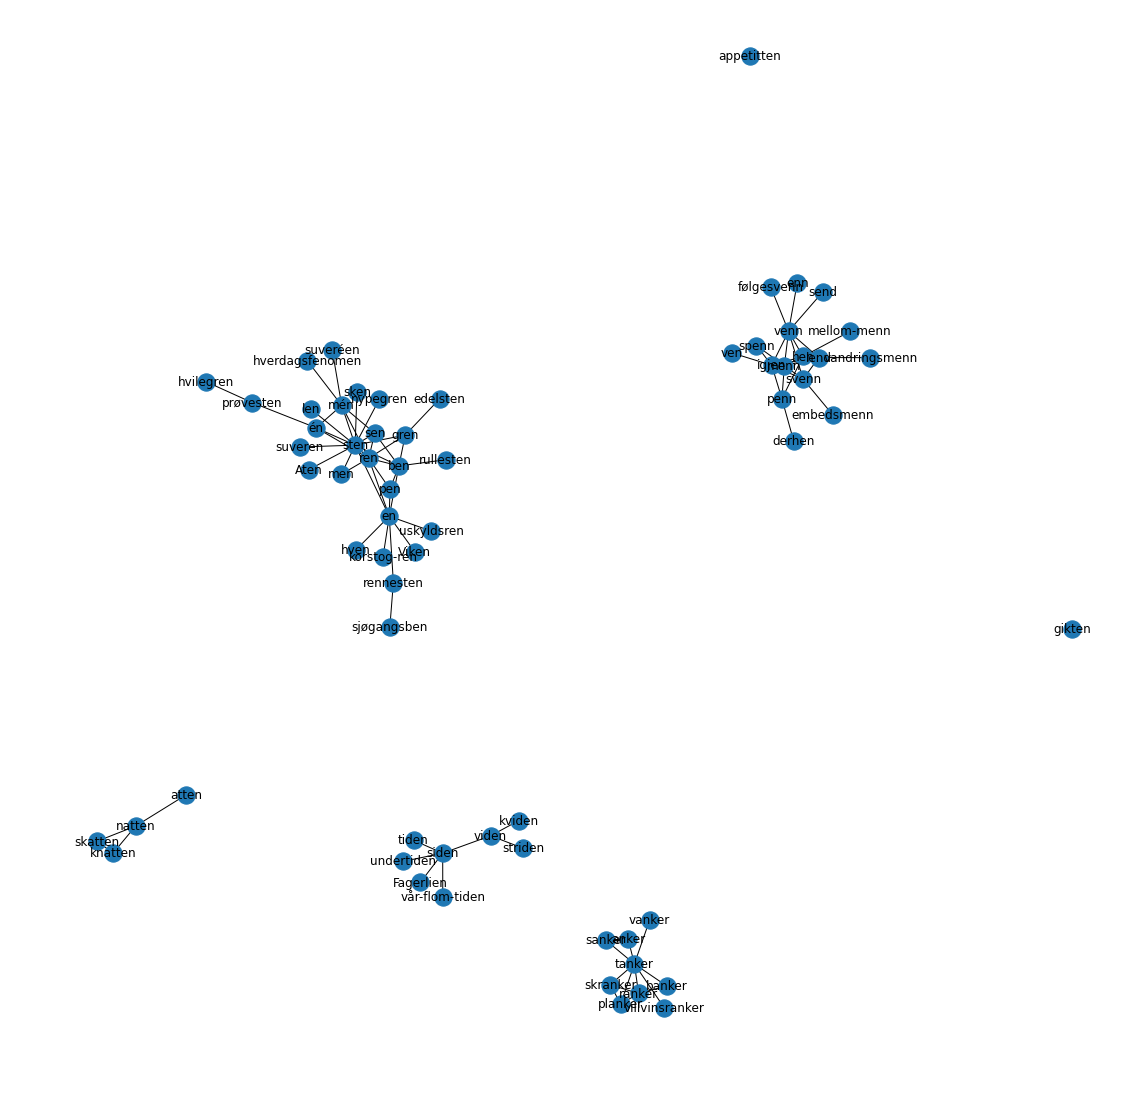

In [58]:
i = 6
g = graphs[i].copy()
size = len(g.nodes)

# f = get_fig(size)

# nx.draw(g, ax=f.add_subplot(111), with_labels=True)
# plt.show()

g.remove_node("den")

for e in [("en", "lend"), ("ranker", "venn"), ("tanker", "ben"), ("én", "anker"), ("tanker", "menn"), ("men", "menn")]:
    g.remove_edge(*e)
    
f = get_fig(size)

nx.draw(g, ax=f.add_subplot(111), with_labels=True)
# f.savefig(f"figs/manual_repair_{i}.png")

# manual_buckets += list(nx.connected_components(g))

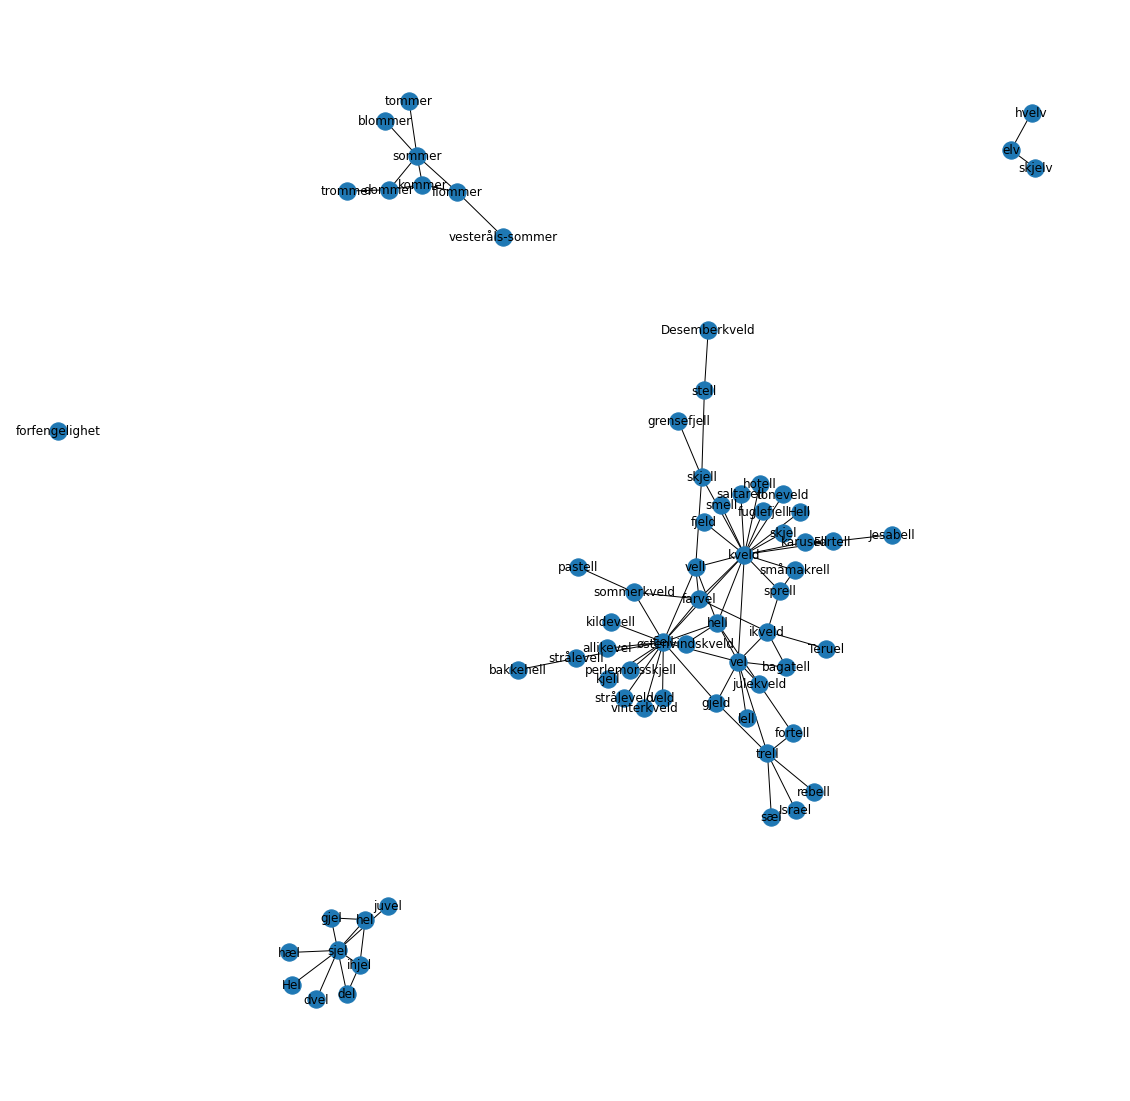

In [59]:
i = 5
g = graphs[i].copy()
size = len(g.nodes)

# f = get_fig(size)
# nx.draw(g, ax=f.add_subplot(111), with_labels=True)
# plt.show()

g.remove_node("selv")

for e in [("sjel", "vell"),  ("del", "trommer"), ("sjel", "dommer")]: 
    #("lek", "steg"), ("lik", "seg")]:
    g.remove_edge(*e)

for e in [("stell", "skjell"), ("grensefjell", "skjell"), ("skjelv", "elv")]:
    g.add_edge(*e)
    
f = get_fig(size)
nx.draw(g, ax=f.add_subplot(111), with_labels=True)
f.savefig(f"figs/manual_repair_{i}.png")

manual_buckets += list(nx.connected_components(g))

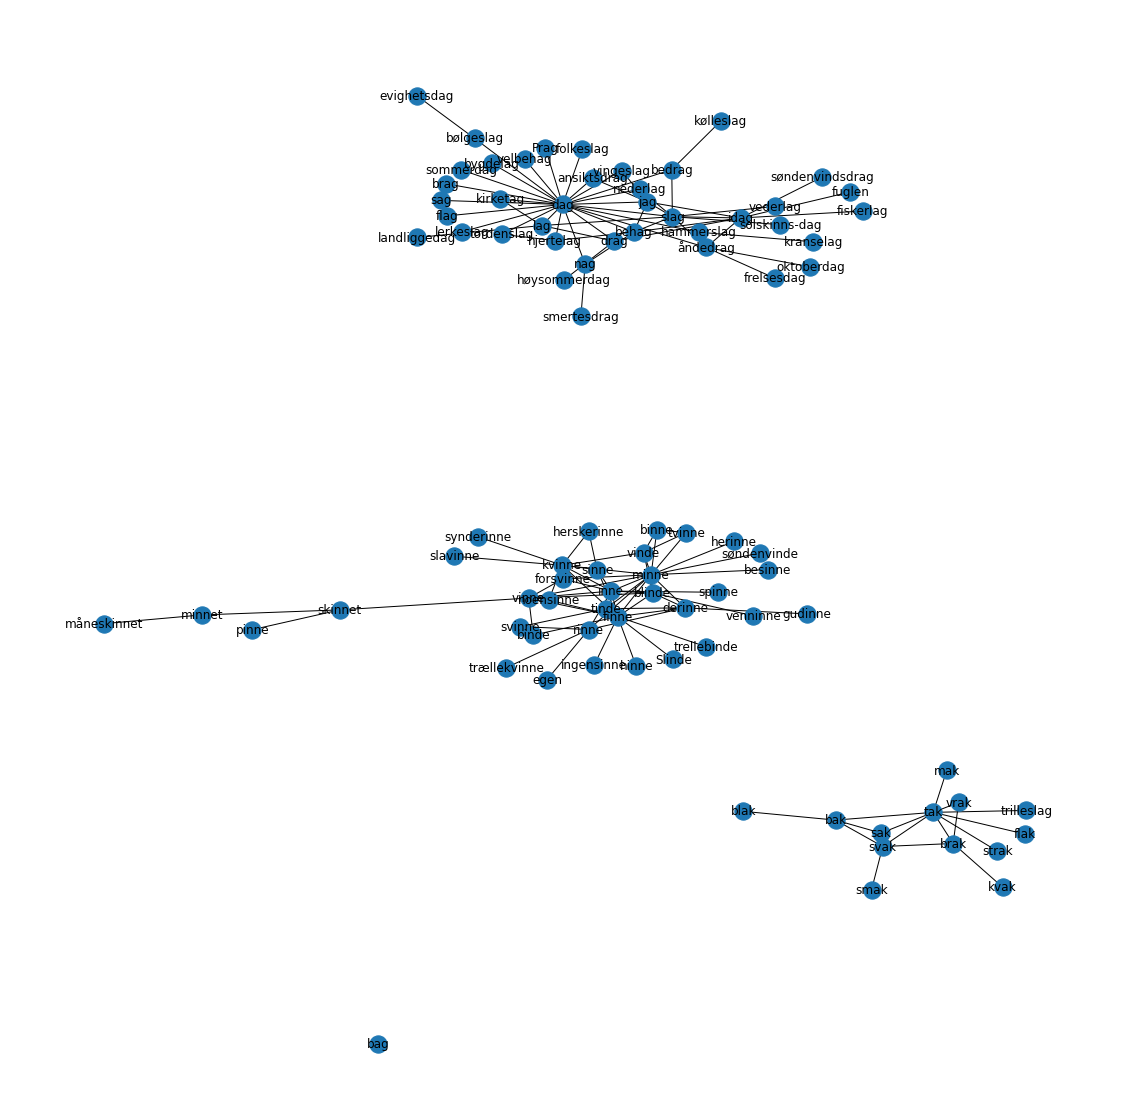

In [60]:
i = 4
g = graphs[i].copy()
size = len(g.nodes)

# f = get_fig(size)

# nx.draw(g, ax=f.add_subplot(111), with_labels=True)
# plt.show()

for e in ("solskinsdag", "hyttetak"):
    g.remove_node(e)

for e in [("tak", "nag")]:
    g.remove_edge(*e)
    
f = get_fig(size)

nx.draw(g, ax=f.add_subplot(111), with_labels=True)
# f.savefig(f"figs/manual_repair_{i}.png")

# manual_buckets += list(nx.connected_components(g))

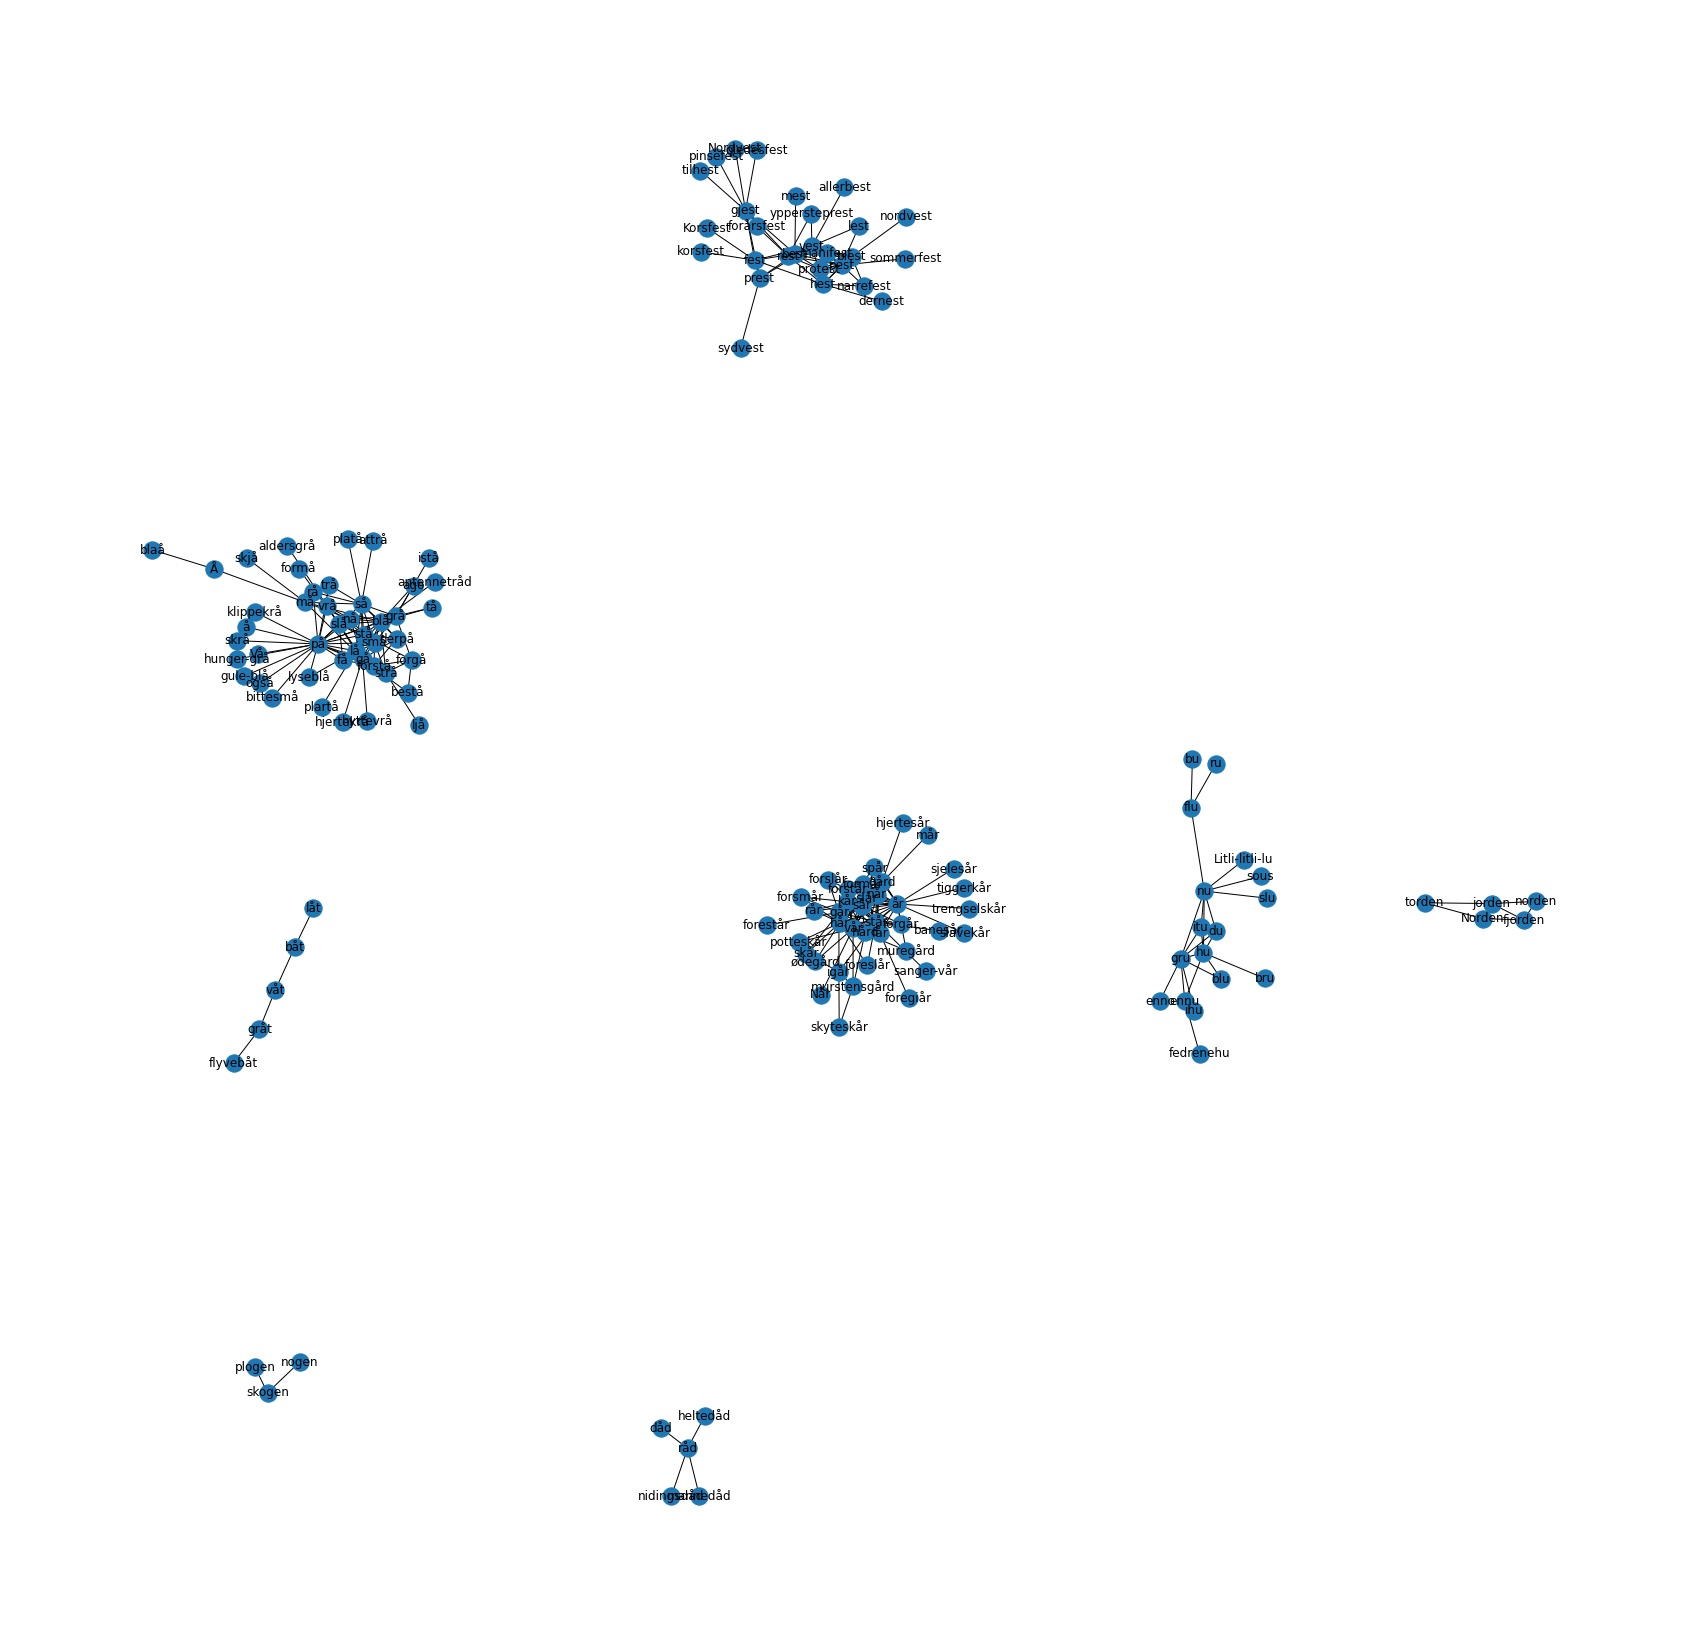

In [61]:
i = 3
g = graphs[i].copy()
size = len(g.nodes)

# f = get_fig(size)

# nx.draw(g, ax=f.add_subplot(111), with_labels=True)
# plt.show()

for e in [("råd", "få"),  ("du", "nå"), ("hu", "nå"),
          ("skogen", "sår"), ("plogen", "går"), ("fjorden", "skogen"),
          ("forstå", "fest"),("best", "forstå"), ("forgå", "når"),
          ("gråt", "dåd"), ("gråt", "nidingsdåd")]:
    g.remove_edge(*e)
    
f = get_fig(size)
nx.draw(g, ax=f.add_subplot(111), with_labels=True)
f.savefig(f"figs/manual_repair_{i}.png")

manual_buckets += list(nx.connected_components(g))

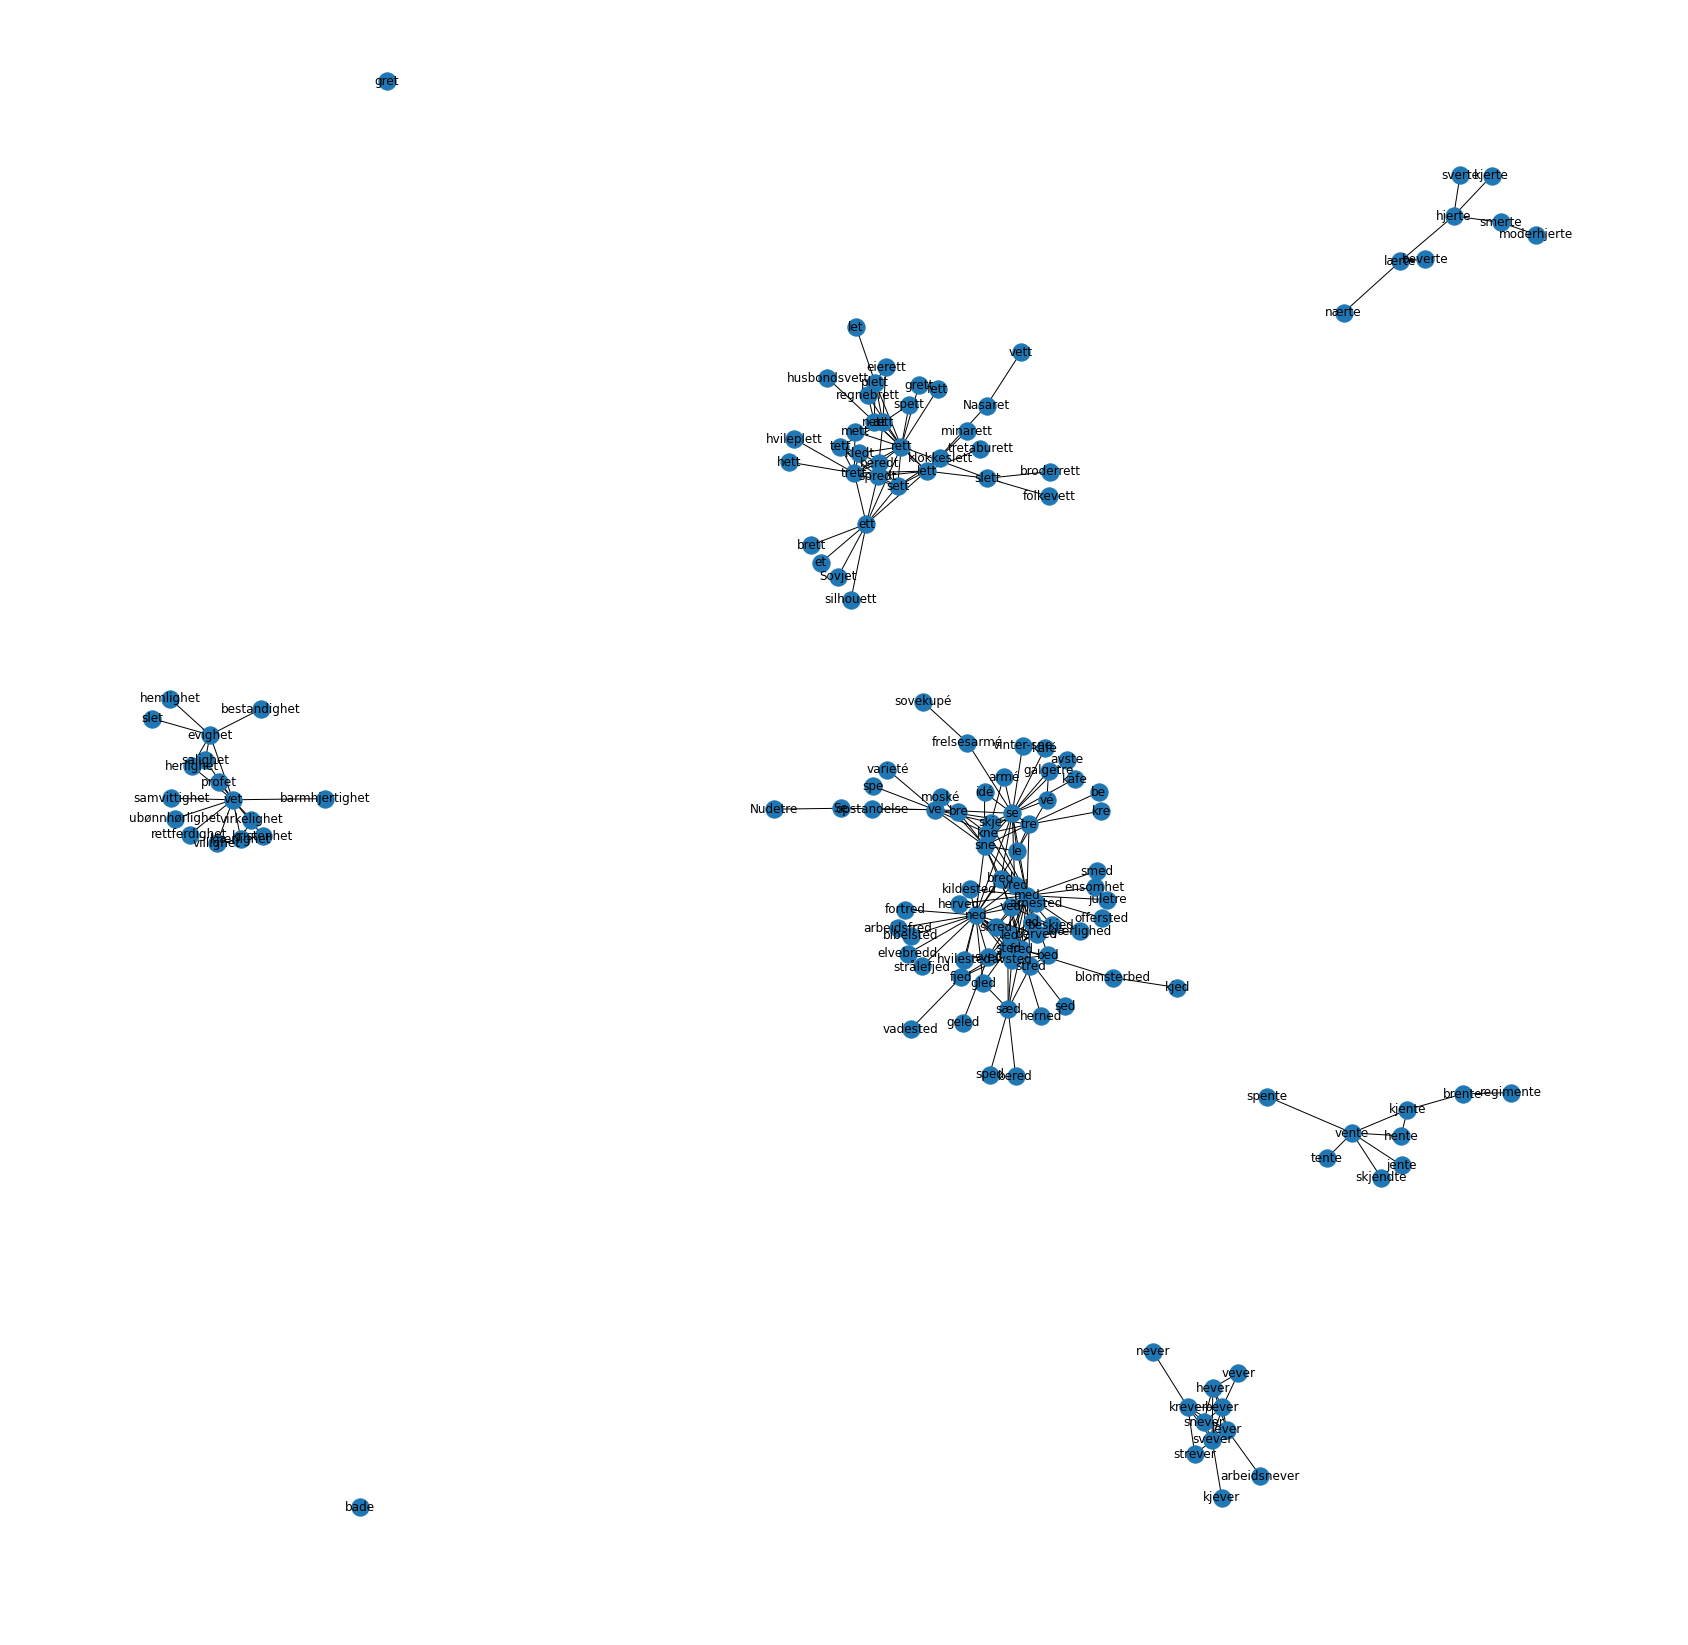

In [62]:
i = 2
g = graphs[i].copy()
size = len(g.nodes)

# f = get_fig(size)
# nx.draw(g, ax=f.add_subplot(111), with_labels=True)
# plt.show()

for e in ["det"]:
    g.remove_node(e)

for e in [("vred", "lever"), ("fred", "bever"), ("evighet", "ed"), ("vet", "ned"),
          ("ned", "kjærlighet"), ("ned", "gret"), ]:
    g.remove_edge(*e)
    
g.add_edge("frelsesarmé", "sovekupé")
    
f = get_fig(size)
nx.draw(g, ax=f.add_subplot(111), with_labels=True)
# f.savefig(f"figs/manual_repair_{i}.png")

# manual_buckets += list(nx.connected_components(g))

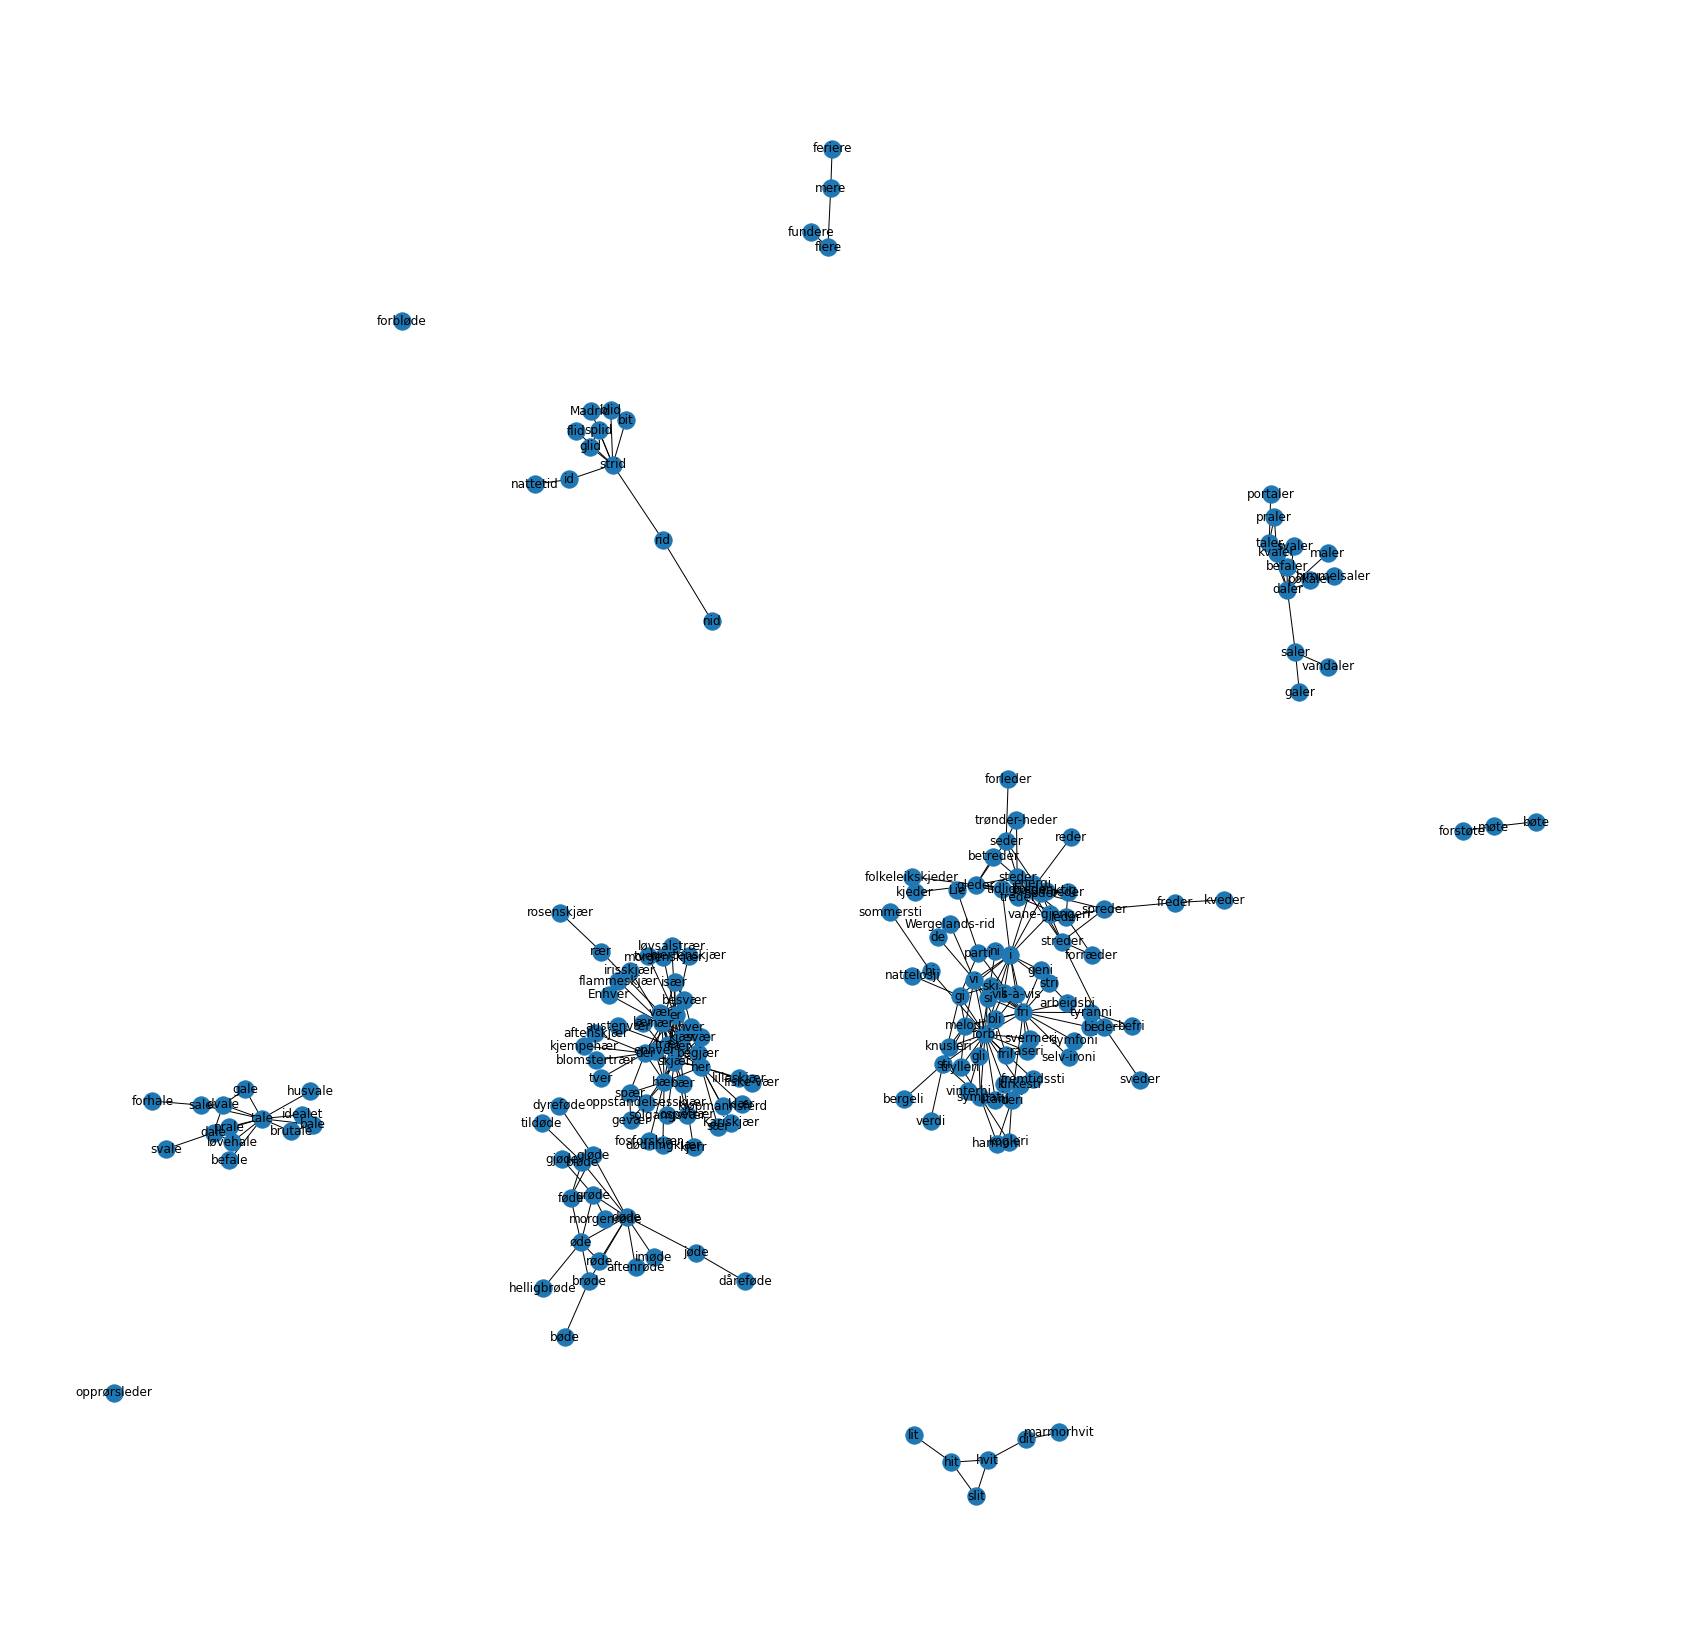

In [63]:
i = 1
g = graphs[i].copy()
size = len(g.nodes)

# f = get_fig(size)
# nx.draw(g, ax=f.add_subplot(111), with_labels=True)
# plt.show()

for e in ["tid", "dere"]:
    g.remove_node(e)

for e in [("døde", "møte"), ("gløde", "strid"), ("daler", "tale"), ("heder", "der")]:
    g.remove_edge(*e)
    
f = get_fig(size)

nx.draw(g, ax=f.add_subplot(111), with_labels=True)
f.savefig(f"figs/manual_repair_{i}.png")

manual_buckets += list(nx.connected_components(g))

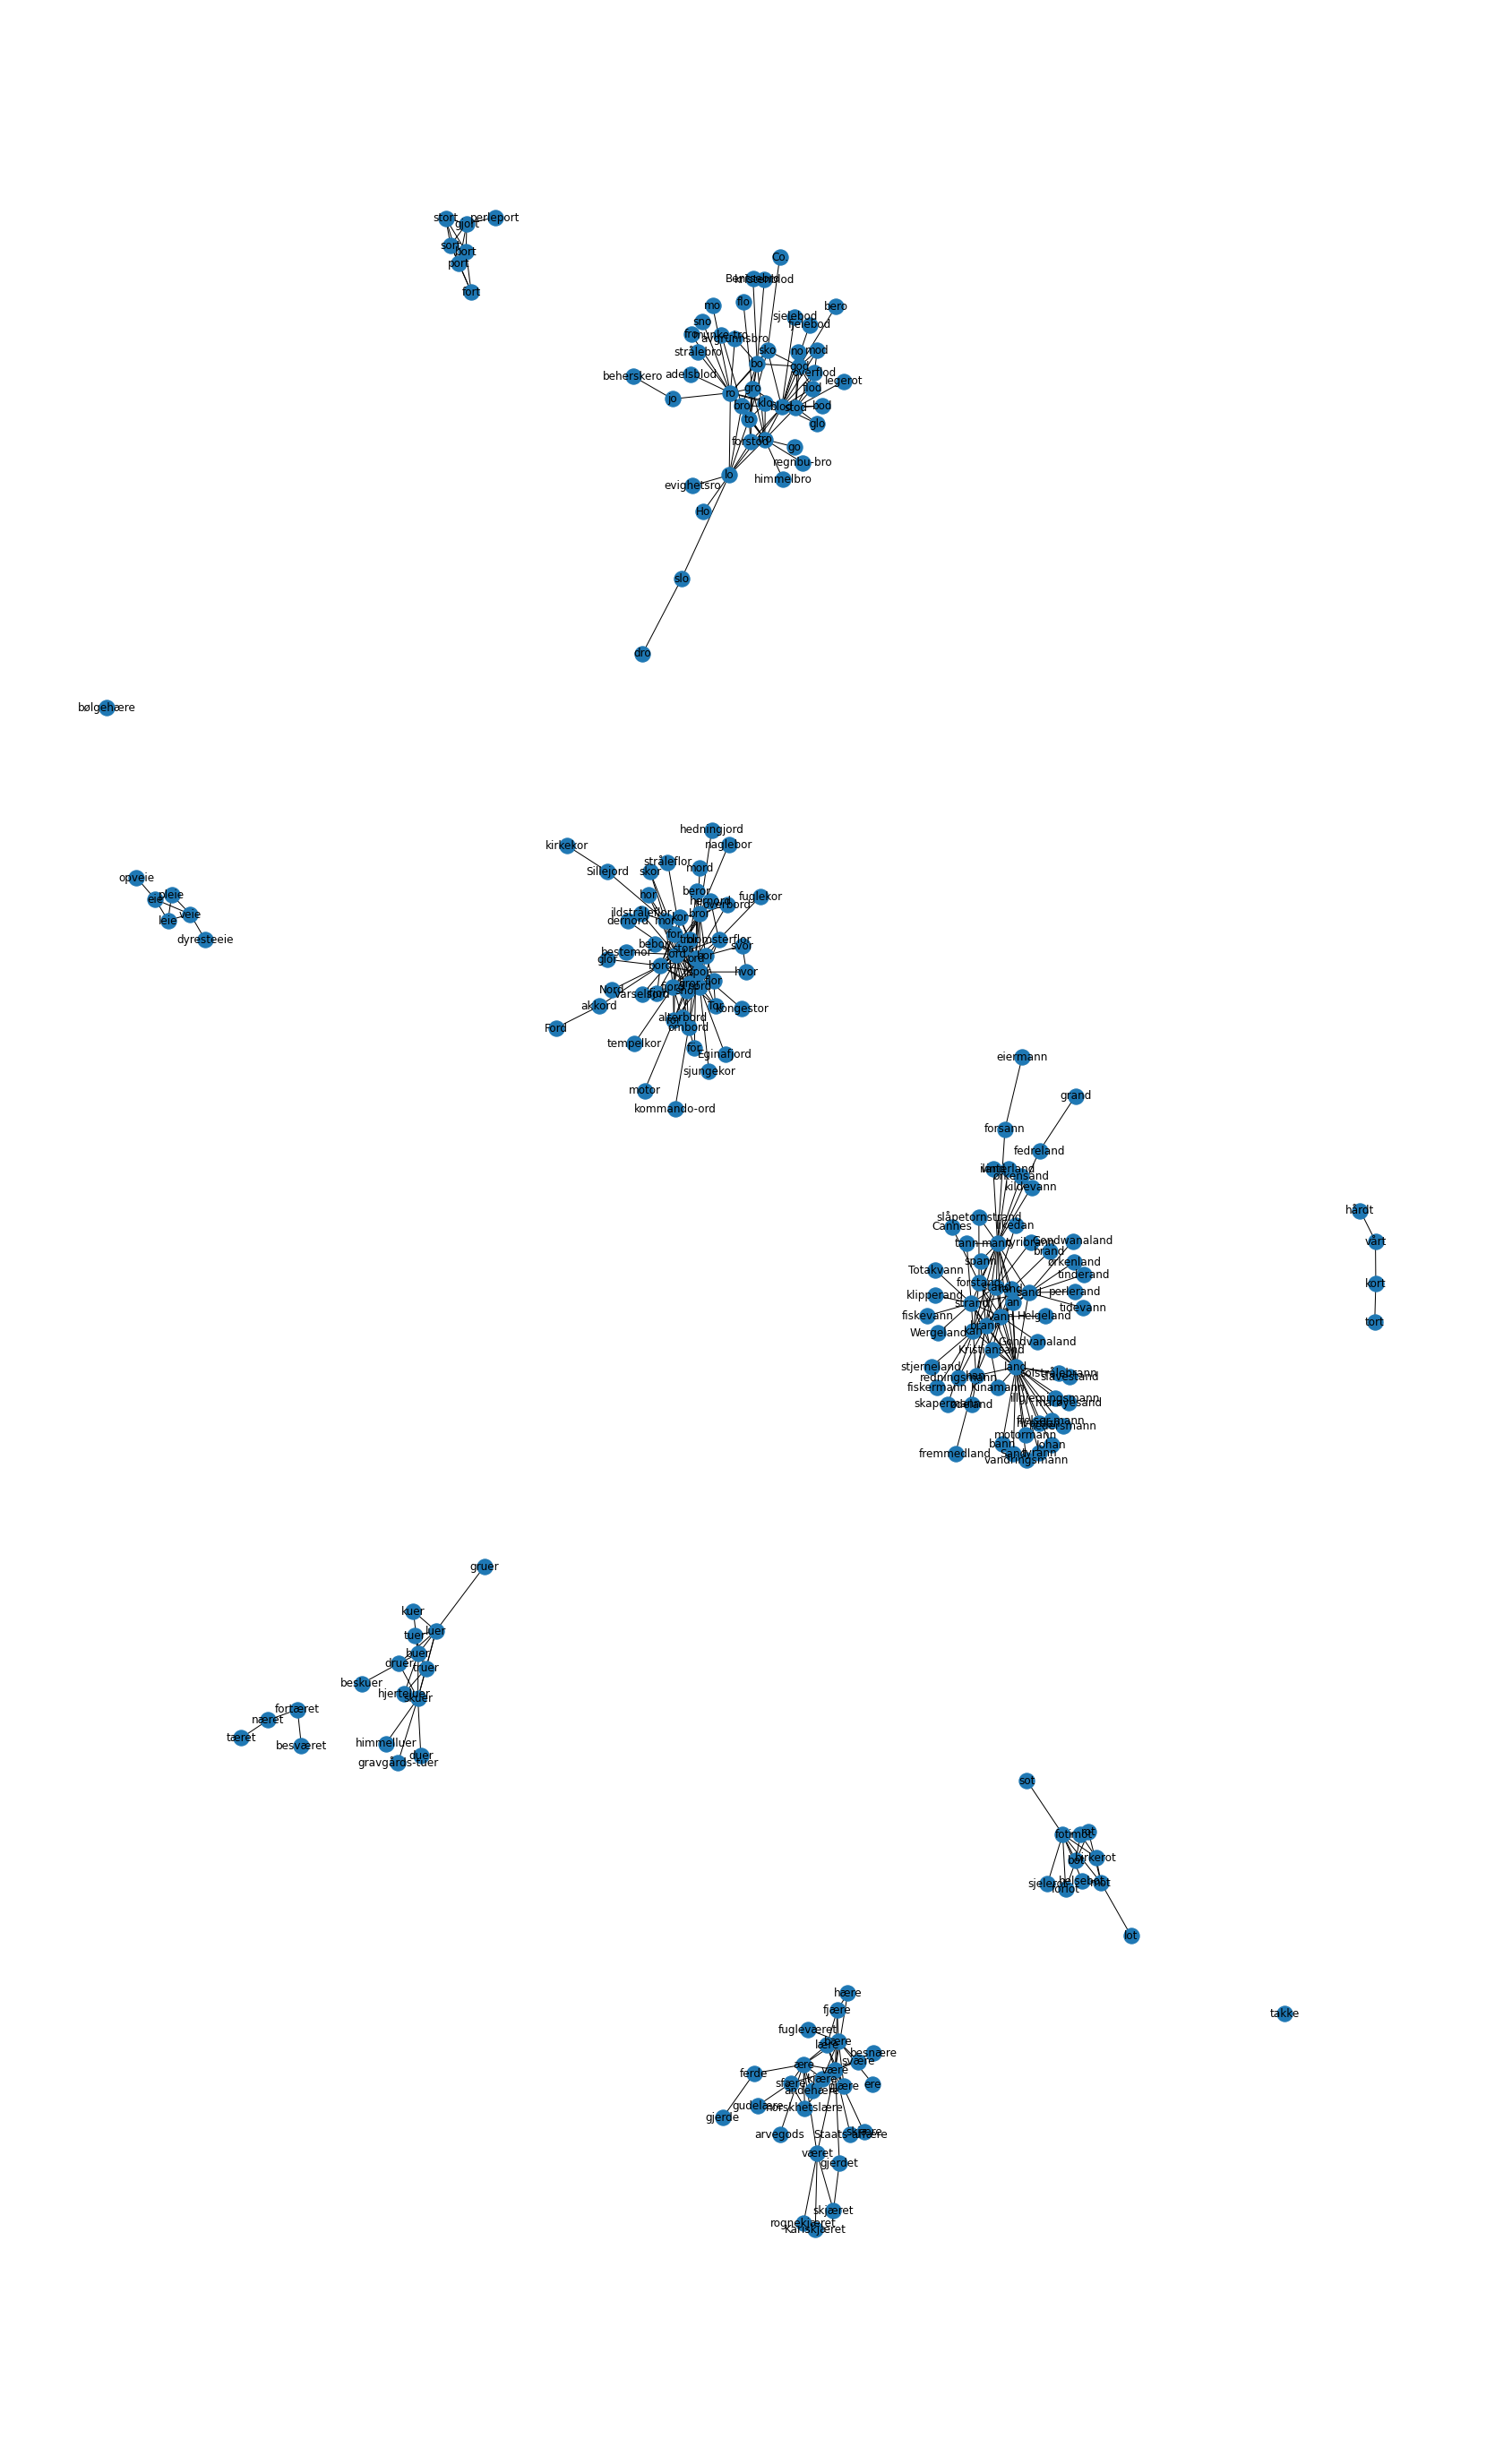

In [64]:
i = 0
g = graphs[i].copy()
size = len(g.nodes)

# f = get_fig(size)
# nx.draw(g, ax=f.add_subplot(111), with_labels=True)
# plt.show()
    
bad_edges = [("ære", "takke"),("land","bære"), ("strand", "bølgehære"), ("fot", "stod"), 
             ("fot", "blod"), ("bot", "flod"), ("været", "besværet"), ("været", "fortæret"), 
            ("imot", "lære"),("stort", "kan"), ("skuer", "fot"), ("bort", "vårt"), ("bort", "kort"),
            ("land", "veie"), ("tro", "jord"),("lot", "blod"),("land", "stort")]

for e in bad_edges:
    g.remove_edge(*e)
    
f = get_fig(size)

nx.draw(g, ax=f.add_subplot(111), with_labels=True)
f.savefig(f"figs/manual_repair_{i}.png")
manual_buckets += list(nx.connected_components(g))

In [65]:
manual_buckets = [e for e in manual_buckets if len(e) > 2]

In [66]:
tot_words = sum(len(bucket) for bucket in manual_buckets)
print(f"""For the {len(manual_buckets)} more buckets:
Total words: {tot_words}
% of vocab: {tot_words/len(vocab)*100}
Avg length: {tot_words/len(manual_buckets)}
""")

For the 73 more buckets:
Total words: 1146
% of vocab: 18.21939586645469
Avg length: 15.698630136986301



In [67]:
with open('manual_repair_buckets.pickle','wb') as f:
    pickle.dump(manual_buckets, f)

In [68]:
m_pairs = set()

for bucket in manual_buckets:
    c = list(itertools.combinations(bucket, 2))
    if c:
        rem = get_mirrored_dupes(c)
        c = set(c) - rem
        m_pairs.update(c)
len(m_pairs)

15144

In [69]:
pairs2 = pairs.copy()
pairs2.update(m_pairs)
len(pairs2)

38167

In [74]:
v = [w for b in manual_buckets for w in b]
print(f"""
With the buckets we got from manual graph clustering we got {len(manual_buckets)} new buckets
Average size: {len(v)/len(manual_buckets)}
{len(v)} words out of {len(vocab)} total
We lost {tot_len-len(v)} vertices

All combinations of the buckets give us {len(m_pairs)} rhyme pairs.
Of these, {len(m_pairs)-(len(pairs2)-len(pairs))} already existed in the pairs data set.
We increased the pair set by {len(pairs2)-len(pairs)}.
""")



With the buckets we got from manual graph clustering we got 73 new buckets
Average size: 15.698630136986301
1146 words out of 6290 total
We lost 317 vertices

All combinations of the buckets give us 15144 rhyme pairs.
Of these, 960 already existed in the pairs data set.
We increased the pair set by 14184.



In [71]:
words_a, words_b = zip(*pairs2)
pair_df = pd.DataFrame({"word_a" : words_a, "word_b": words_b, "rhyme": [1]*len(pairs2)})
pair_df.to_csv("manual_repair_plus_good_buckets_positive_pairs.tsv", sep="\t", index=False)